In [1]:
import pymaid
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import random
from tqdm import tqdm
import networkx as nx
import time
import sys
import csv
import itertools

pymaid.set_loggers('WARNING')


"""

CATMAID credentials in the form of pymaid.CatmaidInstance(server, authname, authpassword, authtoken)

"""


## Plot (normalized) dendrograms from neurons

(Main algorithm by Dr. Philipp Schlegel)

In [25]:
from collections import OrderedDict

def plot(x, plot_connectors=False,vol = None,seo = False, highlight_connectors=[],con_names=[], coldict = {},colors = [], shade_by_length=False, normalize_distance=False, ax=None, remote_instance=None):
    """ Plots neuron as dendrogram. Preserves distances along branches.
    
    Parameters
    ----------
    x :                     pymaid.CatmaidNeuron | string that can be parsed by pymaid.get_neuron()
    plot_connectors :       bool, optional
                            If True, will plot connectors on dendrogram
    highlight_connectors:   list of connector IDs, optional
                            Will highlight these connector IDs.
    shade_by_length :       bool, optional
                            Change shade of branch with length.
    normalize_distance :    bool, optional
                            If True, will normalise all distances to the longest neurite.
    ax :                    matplotlib.ax, optional
                            Ax to plot on. Will create new one if not provided.
    vol:                    Brain volume for which the starting point is marked; For the mNSCs, the ring gland was used
    seo:                    bool; If set to True, it will consider the neuron to be an Se0 neuron
    remote_instance :       pymaid.CatmaidInstance
                            
        
    Return
    ------
    matplotlib.ax
                            
    """
    # Origin in coordinate system
    ORIGIN = (0,0)  
    # Start angle (0 -> to right)
    START_ANGLE = 0
    # Length of orthogonal synapse markers
    SYN_MARKER_LEN = 1.9
    # Angle between branch and its child    
    ANGLE_CHANGE = 45
    # Distance threshold for inverting angle (i.e. flip branch direction)
    SWITCH_DIST = 1
    
    # Change scale of markers if we normalise to max neurite length
    if normalize_distance:
        SYN_MARKER_LEN /= 1000
        SWITCH_DIST /= 1000        
    
    # If x is not already a neuron, try fetching it
    if not isinstance(x, (pymaid.CatmaidNeuron, pymaid.CatmaidNeuronList)):
        x = pymaid.get_neuron( x, remote_instance = remote_instance )   

    # If x is a list of neurons, complain
    if isinstance(x, pymaid.CatmaidNeuronList) and len(x) > 1:
        raise ValueError('Please provide only a single neuron')
        
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 6))

        

    # Work on the copy of the neuron
    x = x.copy()

    root_nodes = x.nodes[x.nodes.type=='root'].treenode_id.tolist()
    xname = list(pymaid.get_names(x).values())[0]

    if seo: 
        if 'L' in xname:
            snode = x.nodes['treenode_id'].loc[x.nodes['z']==22000].values.tolist()
        elif 'R' in xname:
            snode = x.nodes['treenode_id'].loc[x.nodes['z']==12400].values.tolist()

        first = snode[0]
    else:
        first = root_nodes[0]


    # Reroot to soma (if applicable)
#     x.reroot(x.soma)

    # Rerooting to the CNS exit point if seo and soma otherwise
    x.reroot(first)

    # Calc distances -> this adds a "distance to parent" column to neuron.nodes
    x = pymaid.calc_cable(x, return_skdata=True)
    
    # First collect leafs and root
    leaf_nodes = x.nodes[x.nodes.type=='end'].treenode_id.tolist()
#     root_nodes = x.nodes[x.nodes.type=='root'].treenode_id.tolist()
    branch_nodes = x.nodes[x.nodes.type=='branch'].treenode_id.tolist()
    orig_root = root_nodes[0]
    

    d = {}
    gr = x.graph
    for j in range(0,len(branch_nodes)):
        lens = []
        leaves = []
        for i in range(0,len(leaf_nodes)):
            try:
                p = nx.shortest_path(gr,leaf_nodes[i],branch_nodes[j])
                lens.append(len(p))
                leaves.append(leaf_nodes[i])
            except nx.NetworkXNoPath:
                pass
            
        d[branch_nodes[j]] = [lens,leaves]
        
        
    newd = {}
    for key in d.keys():
        val = d[key]
        sm = min(val[0])
        leaf = val[1][val[0].index(sm)]
        newd[key] = leaf

    force_nx = True
    if x.igraph and not force_nx:
        # Convert treenode IDs to igraph vertex indices
        leaf_ix = [v.index for v in x.igraph.vs if v['node_id'] in leaf_nodes]
        root_ix = [v.index for v in x.igraph.vs if v['node_id'] in root_nodes]

        # Now get paths from all tips to the root
        paths = x.igraph.get_shortest_paths(root_ix[0], leaf_ix, mode='ALL')

        # Translate indices back into treenode ids
        paths_tn = [[x.igraph.vs[i]['node_id'] for i in p] for p in paths]
    else:
        # Fall back to networkX
        iterator = nx.shortest_path(x.graph, target = first) 
        #I guess here it uses the parent dist to find the shortest paths
        paths_tn = [iterator[l][::-1] for l in leaf_nodes] 
        #basically the values of the iterator dictionary only without itself

    path_df = pd.DataFrame([[p, x.nodes.set_index('treenode_id').loc[p].reset_index()] for p in paths_tn],
                            columns=['path','nodes'])
    #   path_df has two columns: path (with a list of the nodes in the path) and nodes (treenode_id, parent_id literally)

    
    # Now calculate cable of each of the paths
    path_df['cable'] = path_df.nodes.map(lambda x: x.parent_dist.sum())
#     rg_path_df['cable'] = rg_path_df.nodes.map(lambda rg_x: rg_x.parent_dist.sum())

    # Sort DataFrame by cable length
    path_df.sort_values('cable', inplace=True, ascending=False)
    path_df.reset_index(inplace=True)


    positions = {first: ORIGIN}
    angles = {first: START_ANGLE}
    
    end = None

    count = 0
  
    for k, p in enumerate(tqdm(path_df.itertuples(), total=path_df.shape[0], desc='Dendrogram')):
        
        # Because the paths are always from tip to root, we have to find out which of the nodes
        # have already been plotted and at which branch point we should add this path to the
        # dendrogram
        
        path = p.path # the path column

        dist = 0
    
        n_branch_points = 0
#         print(len(branch_nodes))
        # Walk down the path and count branch points
        
        for i, tn in enumerate(path):
            # Stop If this treenode has already been added 
            if tn not in positions:
                break
        
        
            # Count the number of branch points from root
#             if tn in k:
#                 print tn

            # Code to determine in which direction the next branch will be drawn
            if tn in branch_nodes:

                tnx = x.nodes['x'].loc[x.nodes['treenode_id']==tn].values.tolist()[0]
                tny = x.nodes['y'].loc[x.nodes['treenode_id']==tn].values.tolist()[0]
                
#                 endp = zlist[[zlist.index(k) for k in zlist if tn in k][0]][1]
                endp = newd[tn]
                xp = x.nodes['x'].loc[x.nodes['treenode_id']==endp].values.tolist()[0]
                yp = x.nodes['y'].loc[x.nodes['treenode_id']==endp].values.tolist()[0]
            
                # Considering the real morphology of the neurons; for Se0s, the branches spread out vertically and for the mNSCs horizontally
                if seo:
                    dist = tny - yp
                else:
                    dist = tnx - xp
                    
                n_branch_points += 1
    

        
        # Walk up the path and subset to only the bit that needs to be added
        for i, tn in enumerate(path[::-1]):            
            if tn in positions:                
                path = path[len(path)-i:]
                start_point = np.array(positions[tn])
                last_angle = angles[tn]               
                break
                


        distances = x.nodes.set_index('treenode_id').loc[path].parent_dist.values

        distances[0] = 0
        distances = np.cumsum(distances)        
        # Normalise distances
        if normalize_distance:
            longest_dist = path_df.iloc[0].cable
            distances /= longest_dist
        # Make sure the longest neurite goes horizontally (or whatever START_ANGLE is)
        if k != 0:           
            angle = ANGLE_CHANGE
        else:
            angle = START_ANGLE


        # Switch the angle to negative if the x/y coordinates are smaller than the branch point
        if distances[-1] >= SWITCH_DIST and dist<0:
            angle *= - 1
            # Angle to radians
        angle *= math.pi/180        

        # Add to last angle
        angle += last_angle        


        
        y_coords = np.array([math.sin(angle) * v for v in distances])
        x_coords = np.array([math.cos(angle) * v for v in distances])
        
        # Offset by starting point
        
        y_coords += start_point[1]
        x_coords += start_point[0]
        
#         rg_ys += start_point[1]
#         rg_xs += start_point[0]

        # Apply shade
        if shade_by_length:                        
            color = tuple([.8 - .8 * distances[-1] / path_df.cable.max()] * 3)
        else:
            if boja:
                color = boja[0] #site granki including the primary
            else:
                color = (.1,.1,.1)


        # Change linewidths with path length - za pokratkite granki da se potenki i poneizrazani
        lw = 1 * distances[-1] / path_df.cable.max() + .5
 
        # Plot 
        
        if k==0:
            end = max(x_coords.tolist())


        ax.plot(x_coords, y_coords, color=(0.6,0.6,0.6), zorder=path_df.shape[0]-k, linewidth=lw)
        # Keep track of positions for each treenode and angle of each path
        for i, coords in enumerate(zip(x_coords, y_coords)): #tuka e vaznoto
            positions[path[i]] = coords      

            if path[i] not in angles:
                angles[path[i]] = angle

           
    # If it is an Se0 neuron, draw the soma as a red dot
    if seo:
        ax.scatter([positions[root_nodes[0]][0]],[positions[root_nodes[0]][1]], color = (1,0,0),label= 'soma')

    # If it is an mNSCs neuron, draw the rg entry point as a red dot
    if vol:
        rg = pymaid.get_volume(vol)
        rg_x = pymaid.in_volume(x,rg)

        rg_x = rg_x.copy()
        rg_x = pymaid.calc_cable(rg_x, return_skdata = True)
        rg_nodes = rg_x.nodes.treenode_id.tolist()
        rg_leaf_nodes = rg_x.nodes[rg_x.nodes.type=='end'].treenode_id.tolist()
        rg_branch_nodes = rg_x.nodes[rg_x.nodes.type=='branch'].treenode_id.tolist()
        rg_root_nodes = rg_x.nodes[rg_x.nodes.type=='root'].treenode_id.tolist()

        first = rg_nodes[0]
        last = rg_nodes[-1]
        cfirst = positions[first]
        clast = positions[last]

        y_coord = np.array([math.sin(angle) * v for v in distances])
        x_coord = np.array([math.cos(angle) * v for v in distances])
        y_coord += cfirst[1]
        x_coord += cfirst[0]
        rg_start = (x_coord.tolist()[0],y_coord.tolist()[0])

        ylast = np.array([math.sin(angle) * v for v in [-.2,.2]])
        xlast = np.array([math.cos(angle) * v for v in [-.4,.4]])
        ylast += clast[1]
        xlast += clast[0]

        ax.scatter([x_coord[0]],[0], color='red', s=25, label = 'RG entry')


    if plot_connectors:
        # Start progress bar
        pbar = tqdm(total=x.connectors.shape[0], desc='Connectors', leave=False)
        # Plot synapses
        for rel, c in zip([0, 1], [(0, 0, 0), (0.6, 0.6, 0.6)]):
            for tn in x.connectors[x.connectors.relation==rel].treenode_id.values:   
                pbar.update(1)
                coord = positions[tn]

                angle = angles[tn] + 90 * (math.pi / 180)

                y_coords = np.array([math.sin(angle) * v for v in [-SYN_MARKER_LEN, SYN_MARKER_LEN]])
                x_coords = np.array([math.cos(angle) * v for v in [-SYN_MARKER_LEN, SYN_MARKER_LEN]])

                y_coords += coord[1]
                x_coords += coord[0]
                
                                
                ax.plot(x_coords, y_coords, color='blue', zorder=path_df.shape[0] + 1, linewidth=1.5)

        # End progress bar
        pbar.close()
        
    # Plot highlighted connectors
    if highlight_connectors:
        if type(highlight_connectors[0]) == list:
            total = []
            for con in highlight_connectors:
                
                for tn in x.connectors[x.connectors.connector_id.isin(con)].treenode_id.values:       
                    coord = positions[tn]
                   
                    angle = angles[tn] + 90 * (math.pi / 180) 
    
                    y_coords = np.array([math.sin(angle) * v for v in [-SYN_MARKER_LEN, SYN_MARKER_LEN]])
                    x_coords = np.array([math.cos(angle) * v for v in [-SYN_MARKER_LEN, SYN_MARKER_LEN]])

                    y_coords += coord[1]
                    x_coords += coord[0]
                    
                    if highlight_connectors.index(con)==0:
                        line, = ax.plot(x_coords, y_coords, color='blue', zorder=path_df.shape[0] + 2, linewidth=2.5)
                    else:
#                         line, = ax.plot(x_coords, y_coords, color = coldict[con_names[highlight_connectors.index(con)]], zorder=path_df.shape[0] + 2, linewidth=2.5)

                        line, = ax.plot(x_coords, y_coords, color=colors[highlight_connectors.index(con)], zorder=path_df.shape[0] + 2, linewidth=2.5)
#                 ax.plot([1.2,1.23],[-0.15,-0.15],label = con_names[highlight_connectors.index(con)]+str(len(con)),color = colors[highlight_connectors.index(con)] )
                
                line.set_label(con_names[highlight_connectors.index(con)]+' ('+str(len(con))+')')
#             handles, labels = ax.get_legend_handles_labels()
#             print(handles)
#             by_label = OrderedDict(zip(labels, handles))
#             print(len(by_label))
#             ax.legend(by_label.values(), by_label.keys())
            ax.legend()
            ax.legend(fontsize='small')
#             ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
                
        else:
            for tn in x.connectors[x.connectors.connector_id.isin(highlight_connectors)].treenode_id.values:       
                coord = positions[tn]
                angle = angles[tn] + 90 * (math.pi / 180)
                y_coords = np.array([math.sin(angle) * v for v in [-SYN_MARKER_LEN, SYN_MARKER_LEN]])
                x_coords = np.array([math.cos(angle) * v for v in [-SYN_MARKER_LEN, SYN_MARKER_LEN]])

                y_coords += coord[1]
                x_coords += coord[0]

#                 ax.plot(x_coords, y_coords, color=(0,1,0), zorder=path_df.shape[0] + 2, linewidth=0.8)


    # Plot soma
    ax.scatter([ORIGIN[0]], [ORIGIN[1]], s=40, color=(.1, .1, .1)) #tuka ga crte somata

    # Make sure x/y axis are equal
    ax.set_aspect('equal')  
    ax.set_title(xname)
#     print(c)
    # Return axis
    return ax



Dendrogram: 100%|██████████| 45/45 [00:01<00:00, 31.02it/s]


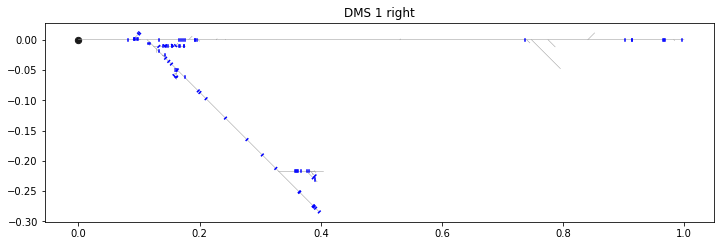

In [23]:
x = pymaid.get_neuron("DMS 1 right")
ax = plot(x, plot_connectors=True
          ,highlight_connectors=[], normalize_distance=True,seo = False,colors = [], shade_by_length=True)
    # Deactivate axis
# ax.set_axis_off()
# Add scale bar
# _ = ax.plot([150, 150], [-5, -5], lw=2, color='k')
# _ = ax.text(x=125, y=-6, s='10 um', ha='center', va='top')

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.60it/s]


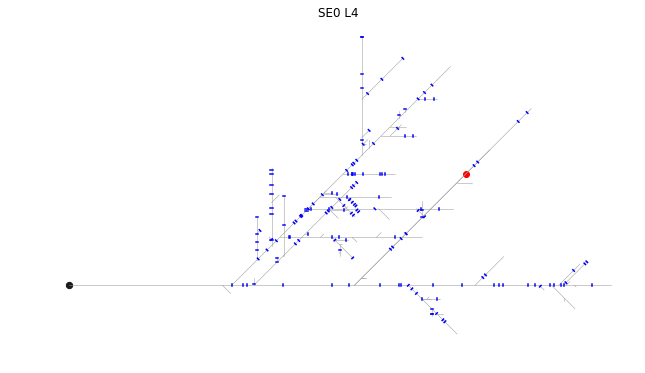

In [28]:
x = pymaid.get_neuron("SE0 L4")
ax = plot(x, plot_connectors=True
          ,highlight_connectors=[], normalize_distance=True,seo = True,colors = [], shade_by_length=True)
    # Deactivate axis
ax.set_axis_off()
# Add scale bar
# _ = ax.plot([150, 150], [-5, -5], lw=2, color='k')
# _ = ax.text(x=125, y=-6, s='10 um', ha='center', va='top')

In [24]:
x.nodes

treenode_id parent_id  creator_id      x      y      z  radius  \
0        14036325  14036324          18  33033  68097  29200      -1   
1        14036327  14036326          18  33098  68141  29100      -1   
2        14036329  14036327          18  33075  67735  29050      -1   
3        14036336  14036329          18  33345  68137  29000      -1   
4        14036342  14036329          18  33014  68191  29000      -1   
5        14036343  14036342          18  33025  68210  28950      -1   
6        14036346  14036345          18  33003  68202  28800      -1   
7        14036349  14036341          18  32767  68103  28900      -1   
8        14036356  14036353          18  32668  68092  28700      -1   
9        14036360  14036339          18  33603  68101  28850      -1   
10         952026    951936           5  38505  67469  38400      -1   
11       14129246  22272119          43  35258  69458  38950      -1   
12       14328851  22272065          18  32961  68666  35850      -1   
13        4683422  22272481           3  44148  73682  45750      -1   
14        2385135  22272273           5  38148  70360  39800      -1   
15         950711    950713           5  31141  68230  28450      -1   
16        3205452  22272799           5  42617  77896  47200      -1   
17        3356590  22272807           5  43301  78781  47750      -1   
18        3367746  22272752           5  46318  79313  51700      -1   
19       20933003  22272732          56  44950  77409  49900      -1   
20        3798905  22272267          18  37870  69870  39150      -1   
21       21000234  21047814          18  33500  67716  32200      -1   
22         952296    952294           5  43042  70391  40250      -1   
23       21047710    952276          56  42354  70455  40100      -1   
24       21047711  21047710          56  42381  70452  40150      -1   
25       21047712  21047711          56  42468  70474  40200      -1   
26       21047713    952286          56  42628  70763  40150      -1   
27       21047714  21047713          56  42643  70771  40200      -1   
28       21047715  21047712          56  42548  70482  40250      -1   
29       21047716  21047715          56  42579  70490  40300      -1   
...           ...       ...         ...    ...    ...    ...     ...   
2275     23977150  23977149          72  44758  72627  43050      -1   
2276     23977155  23977154          72  44507  72186  42800      -1   
2277     23977157  23977156          72  44328  71970  42700      -1   
2278     23977164  22272055          18  32505  70780  43450      -1   
2279     23977166  23977165          72  32431  70871  43600      -1   
2280     23977167  23977166          72  32427  70879  43650      -1   
2281     23977165  23977170          72  32469  70814  43550      -1   
2282     23977170  23977164          72  32501  70786  43500      -1   
2283     23977181  21122930          56  32794  70383  42800      -1   
2284     21122931  23977181          56  32801  70372  42850      -1   
2285     23977183  23977182          72  32792  69986  42700      -1   
2286     23977184  23977183          72  32757  69777  42650      -1   
2287     23977185  23977184          72  32963  69602  42600      -1   
2288     23977186  23977185          72  32906  69614  42550      -1   
2289     23977187  23977186          72  32909  69568  42500      -1   
2290     23977189  23977187          72  32898  69538  42450      -1   
2291     23977190  23977189          72  32792  69488  42400      -1   
2292     23977192  23977185          72  33244  69291  42550      -1   
2293     23977193  23977192          72  33263  69260  42500      -1   
2294     23977194  23977193          72  33255  69272  42450      -1   
2295     23977195  23977194          72  33327  69226  42400      -1   
2296     23977196  23977195          72  33346  69173  42350      -1   
2297     23977197  23977196          72  33327  69169  42300      -1   
2298     23977198  23977197          72  33369

In [29]:
def extract_csv_new(fname):
    with open(fname) as csv_file:
        csv_f = csv.reader(csv_file, delimiter=',')
        line_count = 0
        tars = []
        for row in csv_f:
            if line_count == 0:
    #             print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
                current = f'{row[2]}'
                if current not in tars:
                    tars.append(current)
    #             print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
                line_count += 1 
    

    sources = []
    for t in tars:
        with open(fname) as csv_file:
            csv_f = csv.reader(csv_file, delimiter=',')   
            line_=0
            all_ins = []
            for row in csv_f:
                ins=[]
                if line_ ==0:
                    line_ += 1
                elif (f'{row[2]}')==t:
                    first = (f'{row[0]}')
                    second = (f'{row[1]}')
                    ins=[first,second]
                    all_ins.append(ins)
                    line_+=1
                    
        sources.append(all_ins)

    both = [tars,sources]
    return both

# ipc_trips = extract_csv_new('triples_ipc.csv')


In [6]:
ipc_trips = extract_csv_new('triples_ipc.csv')


The next function takes a triples csv file name and similar to the other extract_csv functions returns a two element list where the first is a list of the targets, and a second is a list of several lists for each target containing the input. The second list has as elements a list of each sensory together with the interneurons that it makes triples with, such that each sensory appears only once whereas the interneurons may be part of multiple lists. 

In [7]:
def extract_final(fname):
    trips = extract_csv_new(fname)
    tars = trips[0]
    tot = []
    for i in range(0,len(tars)):
        rel = []
        for el in trips[1][i]:
            newl = [el[0]]
            newl+=[trip[1] for trip in trips[1][i] if trip[0] == el[0]]
            rel.append(newl)
        tot.append(rel)

    return [tars,tot]

In [8]:
ipc_sen = extract_final('triples_ipc.csv')
dms_sen = extract_final('triples_dms.csv')
dh_sen = extract_final('triples_dh44.csv')


In [9]:
se0p_sen = extract_final('triples_se0ph.csv')
se0ens_sen = extract_final('triples_se0ens_new3.csv')

In [10]:
dh_sen[0]

['DH44 1 left',
 'DH44 3 left',
 'DH44 2 left',
 'DH44 2 right',
 'DH44 1 right',
 'DH44 3 right']

In [11]:
from matplotlib import colors as mcolors

# In boi2 there are 34 colors
colors = dict(mcolors.TABLEAU_COLORS)
colors.keys()

dict_keys(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

Function to plot the synapses made to the target neuron from specific sensory and interneurons

In [32]:
from matplotlib import colors as mcolors

# In boi2 there are 34 colors
# colors = dict(mcolors.TABLEAU_COLORS)
# mycols = ['darkorange','darkorchid','orangered','aqua','darkolivegreen','tomato','indigo','gold','darkred',
#               'hotpink','darkturquoise','crimson','firebrick','deepskyblue','maroon','silver',
#              'orchid','royalblue','navy','thistle','mediumvioletred','chocolate','violet','darksalmon',
#           'dodgerblue','mediumspringgreen','mediumorchid','indianred','darkseagreen','mediumpurple','teal']

sub_cols = ['blueviolet','mediumspringgreen','tomato','lime','magenta','indianred','gold','darkviolet','cadetblue']
boi2 = [p for p in list(colors.keys()) if 'blue' not in p and 'green' not in p and 'gray' not in p and 'purple' not in p and 'brown' not in p]+sub_cols
def plot_connectors(n,lista,col):
    cons = []
    x = pymaid.get_neuron(n)
    y = pymaid.get_neuron(lista)
    if isinstance(y,pymaid.core.CatmaidNeuronList):
        for neur in y:
            c = pymaid.get_connectors_between(neur,x)
            cons.append(c.connector_id.values.tolist())
    else:
        c = pymaid.get_connectors_between(y,x)
        cons.append(c.connector_id.values.tolist())
    if 'SE0' in n:
        ax = plot(x, plot_connectors=False, highlight_connectors=cons, seo=True, con_names = lista,colors= col,
              normalize_distance = True,shade_by_length=True)
       

    else:
         ax = plot(x, plot_connectors=False, highlight_connectors=cons, con_names = lista,colors = col,vol = 'PS_ring_gland',
              normalize_distance = True,shade_by_length=True)
    # Deactivate axis
#     ax.set_axis_off()


#     _ = ax.plot([1.82, 1.86], [-0.15, -0.15], lw=1, color=cols[0])
#     _ = ax.text(x=1.9, y=-0.12, s=lista[0], ha='center', va='top')

#     ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    ax.set_xlabel('normalized arbor length', fontsize=11)
    n_name = n.replace(' ','')
    plt.savefig(r'/home/ben/Downloads/label-dendrograms/label-mod-dendrogram-'+n_name+'-'+lista[0]+'.png',bbox_inches='tight',dpi=1000,fontsize='small')
    return ax




In [14]:
new_boi = ['dodgerblue','orange','limegreen','magenta','teal',
           'cyan','lightpink','gold','orangered','peru']

HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 108/108 [00:06<00:00, 17.37it/s]


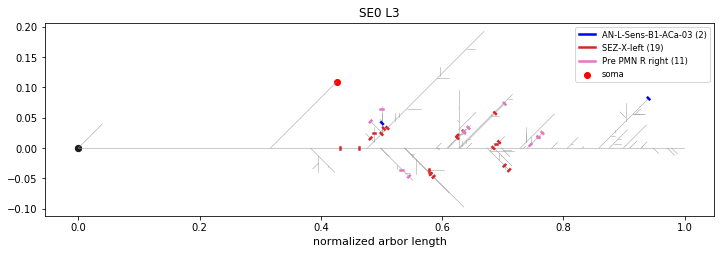

In [27]:
plot_connectors('SE0 L3',['AN-L-Sens-B1-ACa-03', 'SEZ-X-left', 'Pre PMN R right'],boi2)

Function to plot all dendrograms for a target type ('IPC','DMS' etc.)

In [31]:
def all_dendrograms(sen_l,boi):
    ints = [[sen_l[1][i][j][1:] for j in range(0,len(sen_l[1][i]))] for i in range(0,len(sen_l[0]))]
    new_i = list(itertools.chain.from_iterable(ints))
    new2_i = list(set(list(itertools.chain.from_iterable(new_i))))

    for i in range(0,len(sen_l[0])):
        for j in range(0,len(sen_l[1][i])):
            plot_connectors(sen_l[0][i],sen_l[1][i][j],boi)
        
    return None


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 22.43it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 23.14it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 22.83it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 22.90it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 22.80it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 22.88it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 22.79it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 30.44it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 21.67it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 55/55 [00:02<00:00, 24.27it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 55/55 [00:02<00:00, 24.24it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 55/55 [00:02<00:00, 24.66it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 55/55 [00:02<00:00, 24.76it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 55/55 [00:02<00:00, 22.36it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:01<00:00, 31.10it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 40.05it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:01<00:00, 40.58it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:01<00:00, 40.32it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 45/45 [00:01<00:00, 24.86it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 45/45 [00:01<00:00, 28.69it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

Dendrogram: 100%|██████████| 45/45 [00:02<00:00, 22.16it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 24/24 [00:00<00:00, 48.90it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 24/24 [00:00<00:00, 51.68it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 41/41 [00:01<00:00, 29.86it/s]


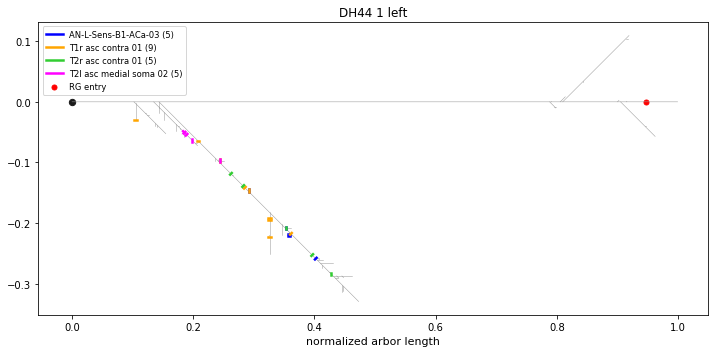

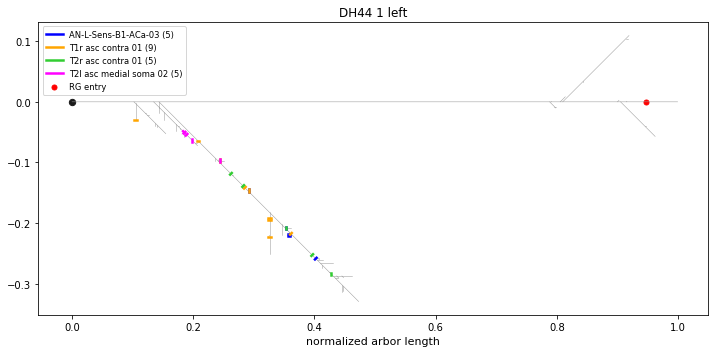

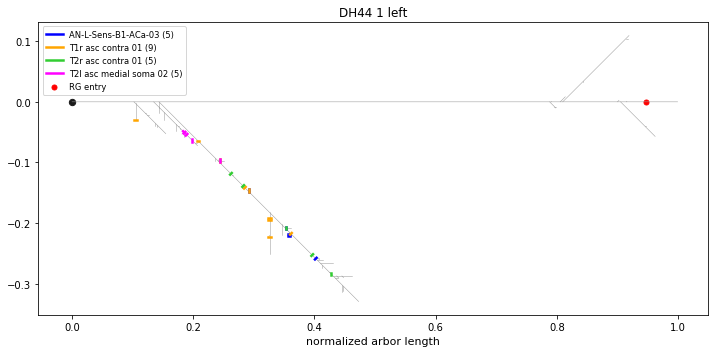

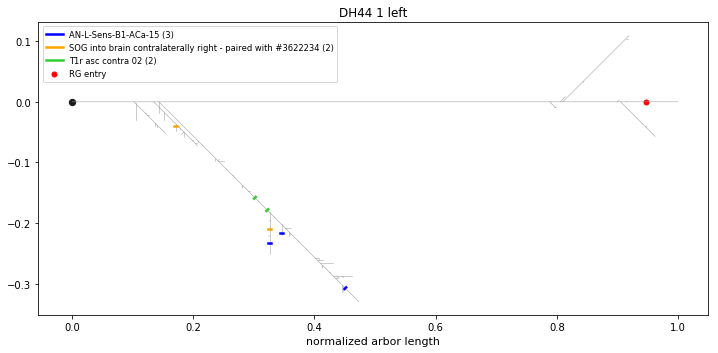

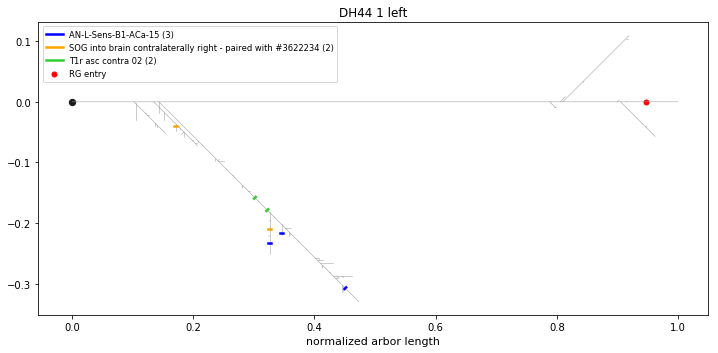

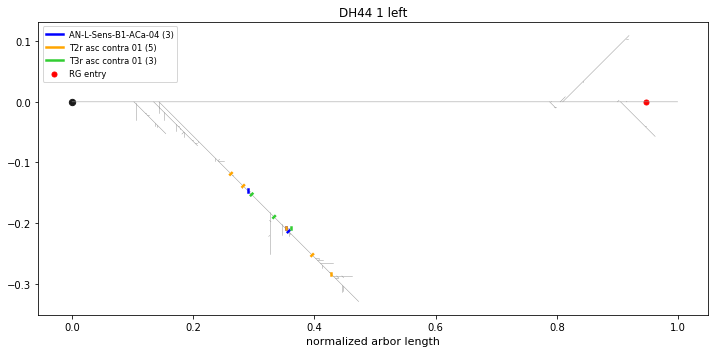

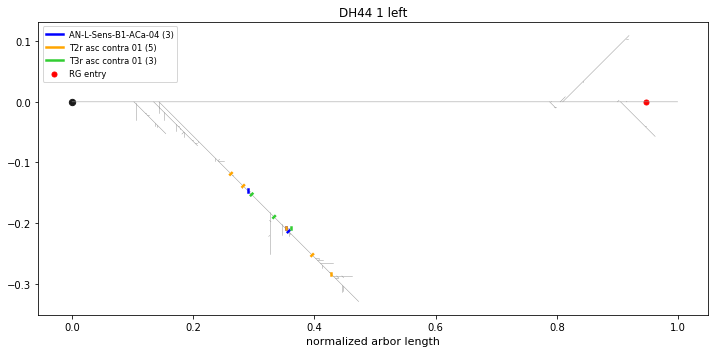

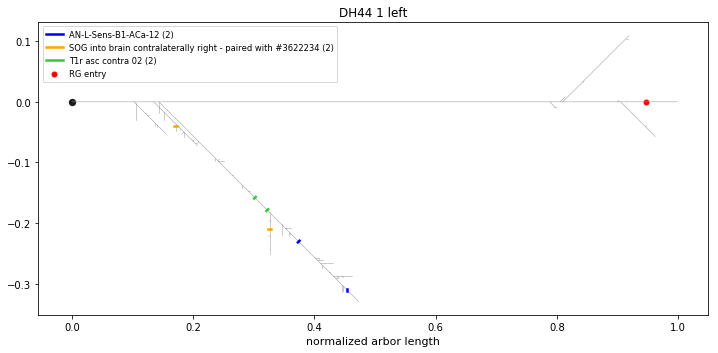

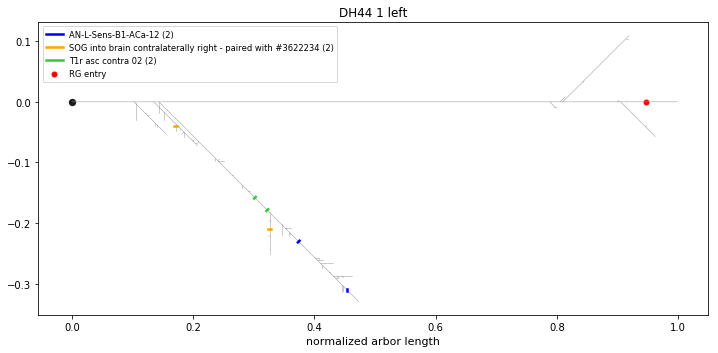

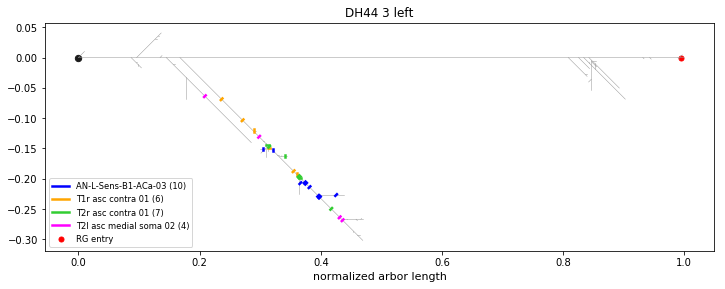

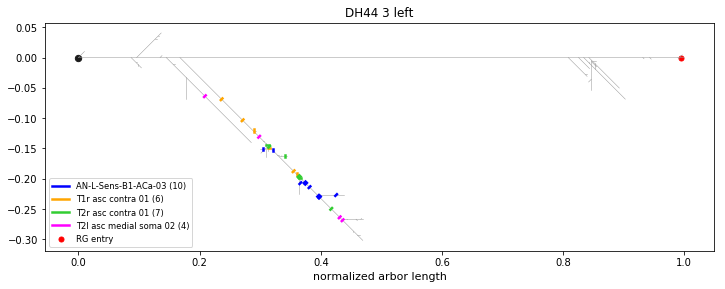

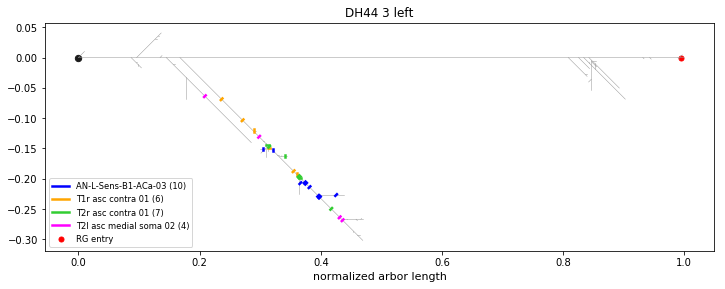

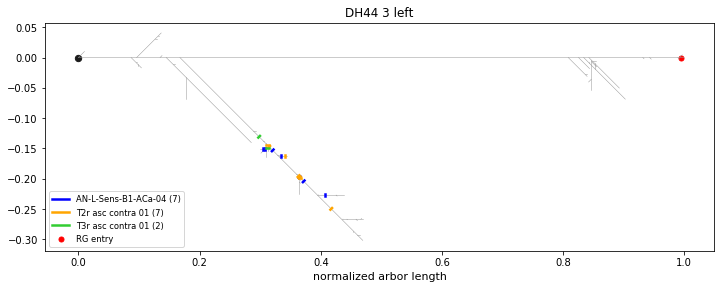

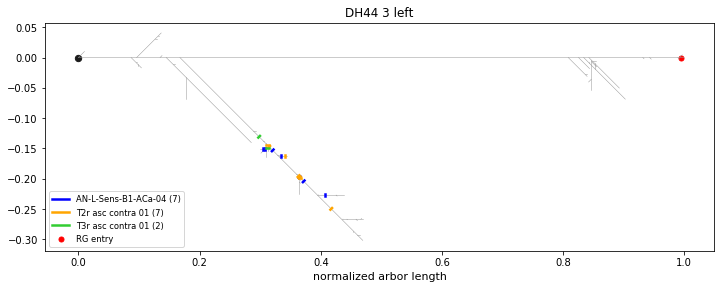

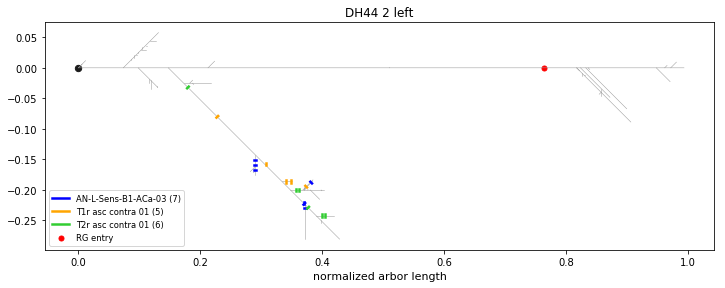

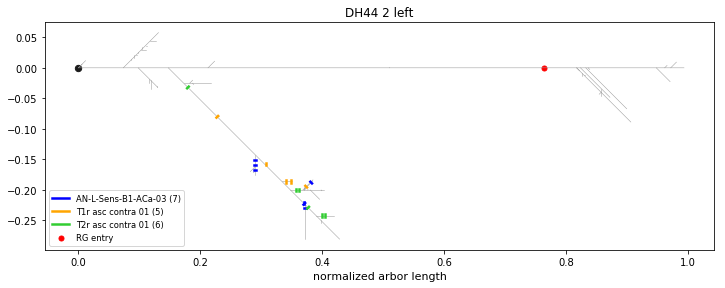

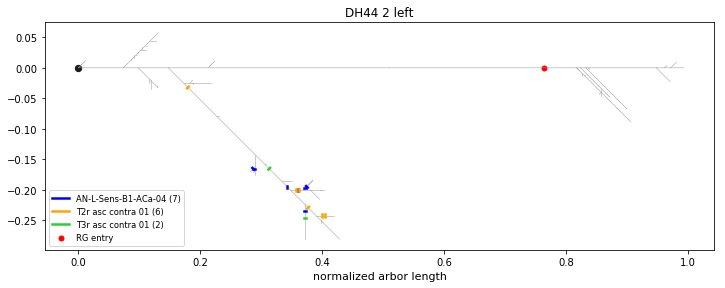

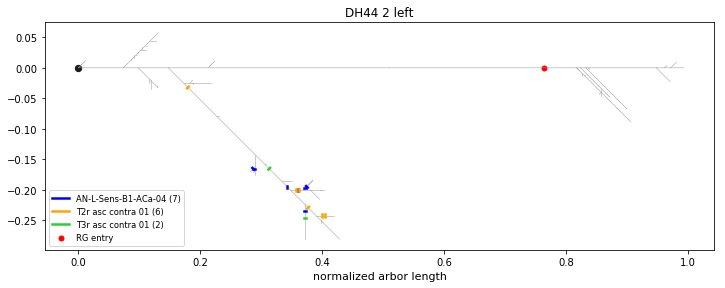

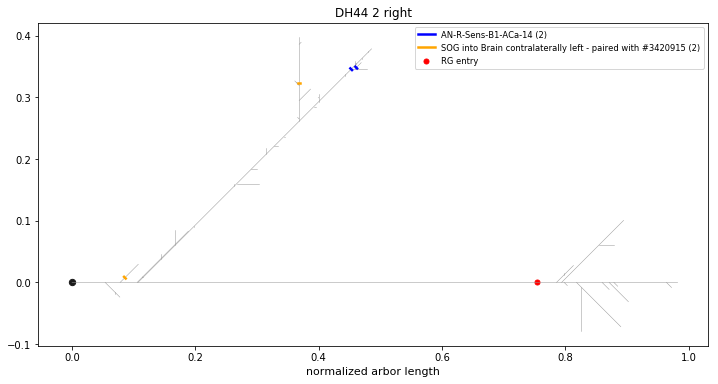

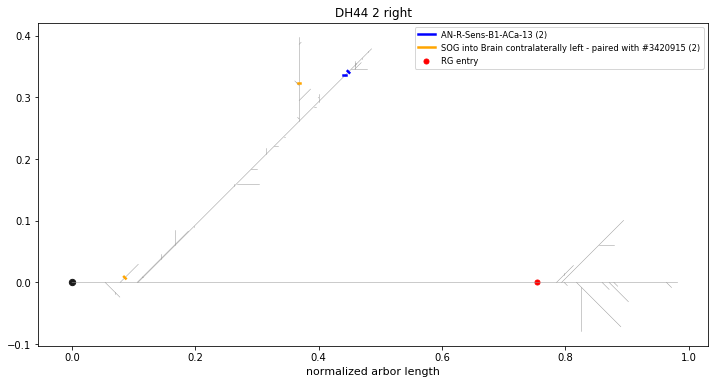

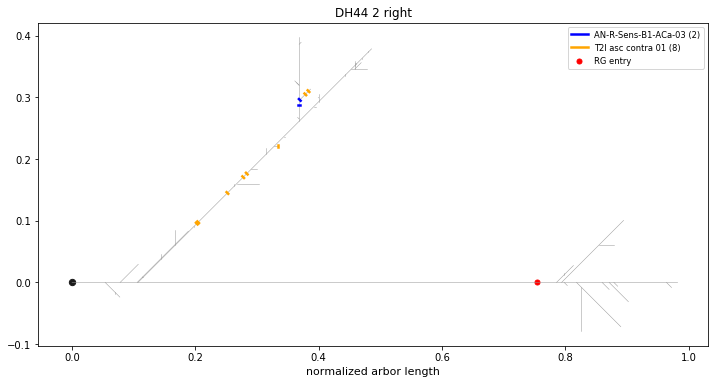

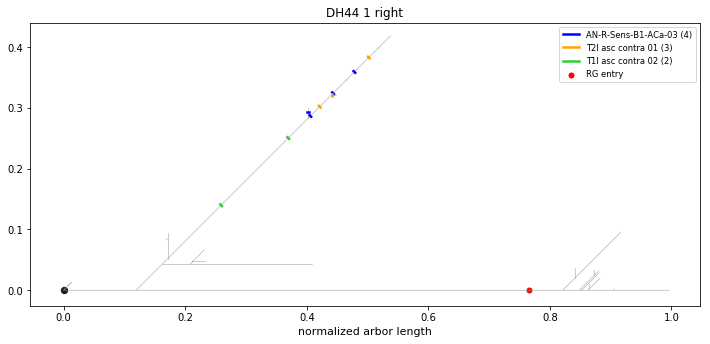

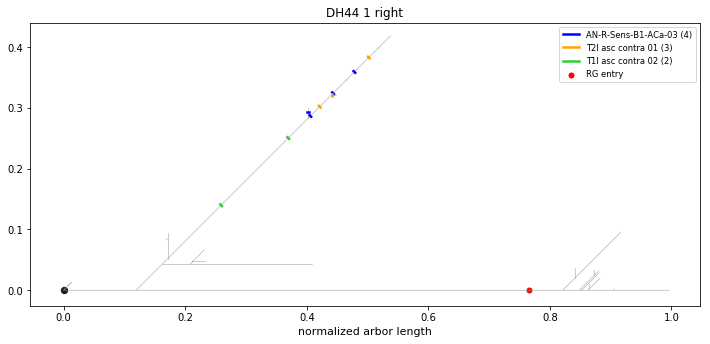

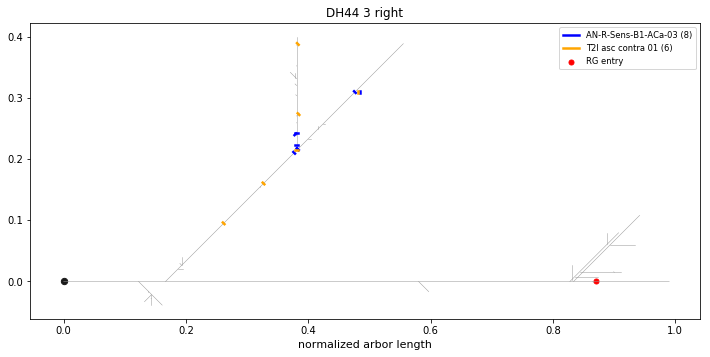

In [40]:
# all_dendrograms(dh_sen,new_boi)

HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.01it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 33.40it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.61it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.56it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.60it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.21it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.22it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 33.26it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.45it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.40it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:03<00:00, 29.77it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.53it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.53it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.30it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.41it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 20.40it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 45/45 [00:01<00:00, 31.29it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 23.89it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 23.83it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 23.76it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 22.19it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 23.75it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 23.61it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 23.66it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 22.21it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 23.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 23.93it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 56/56 [00:02<00:00, 24.01it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 49/49 [00:01<00:00, 25.12it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 49/49 [00:01<00:00, 24.84it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 49/49 [00:01<00:00, 24.79it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 49/49 [00:01<00:00, 24.67it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 49/49 [00:01<00:00, 24.99it/s]


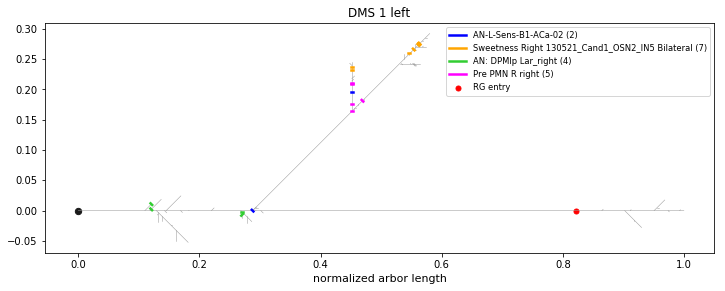

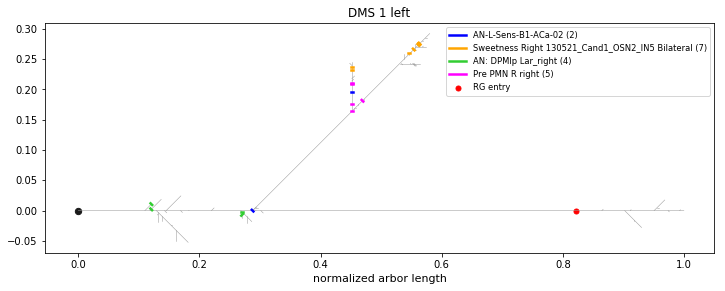

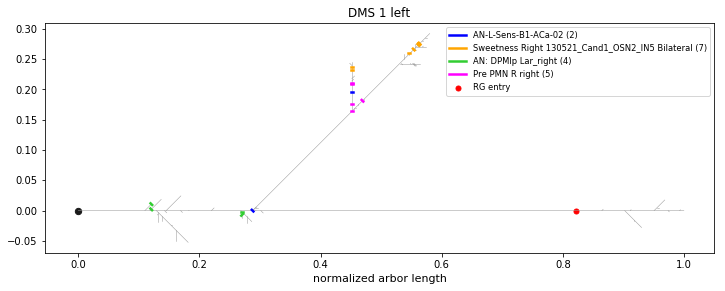

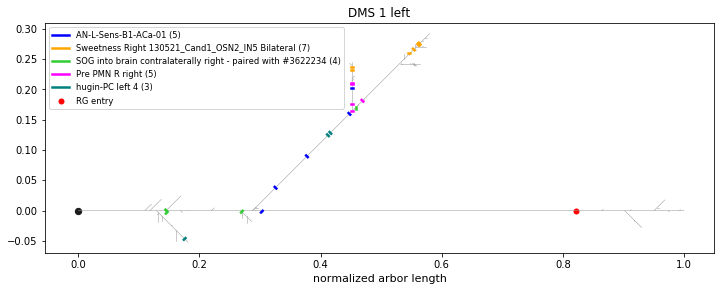

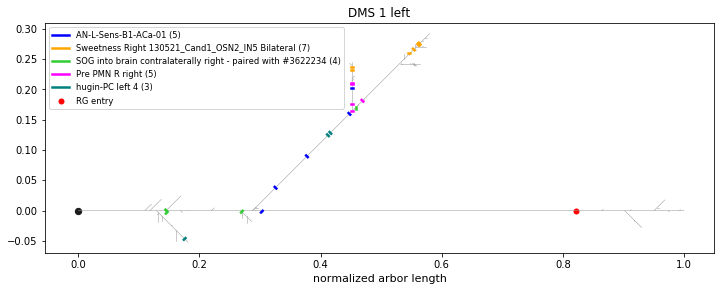

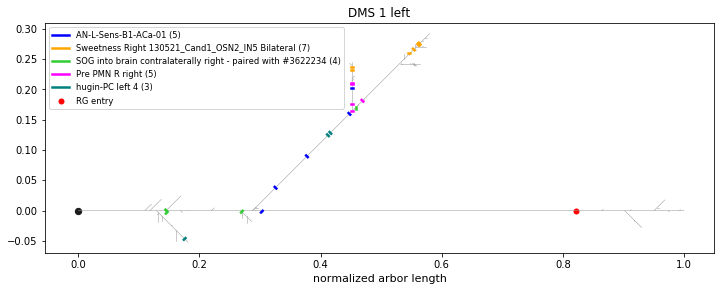

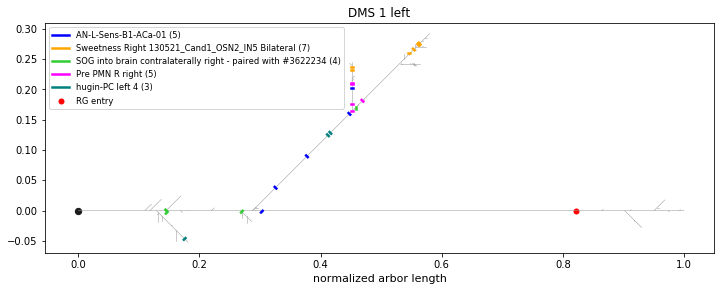

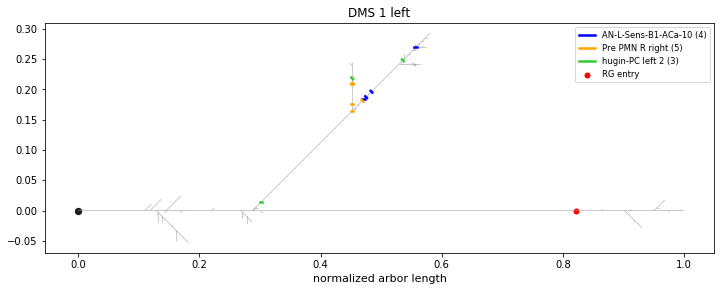

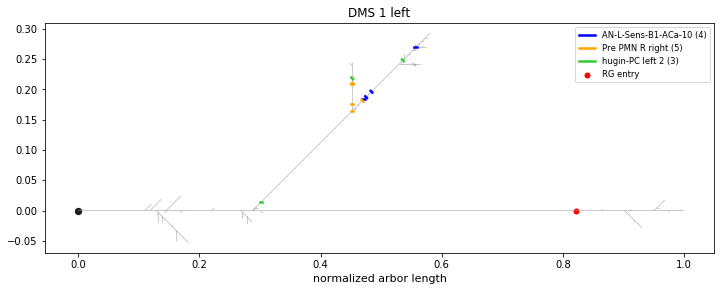

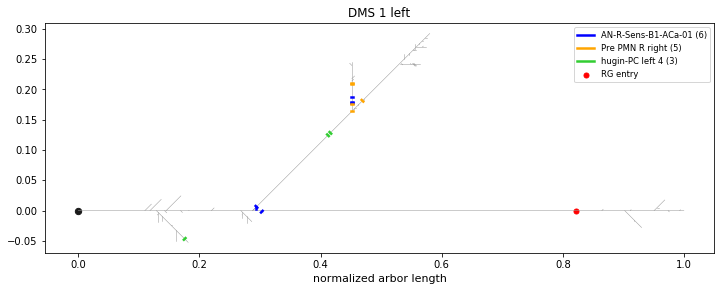

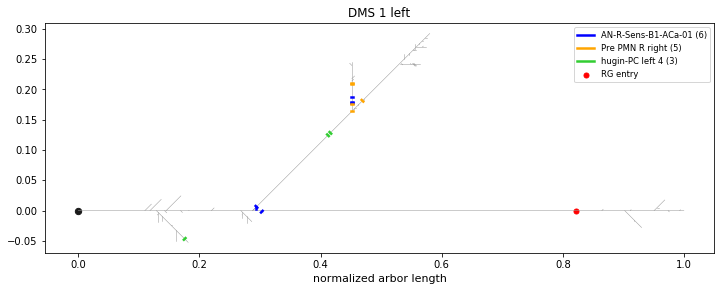

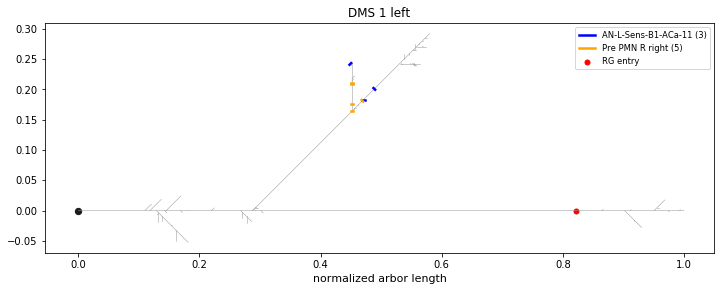

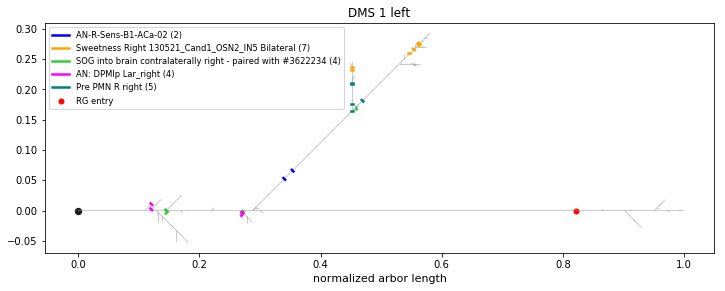

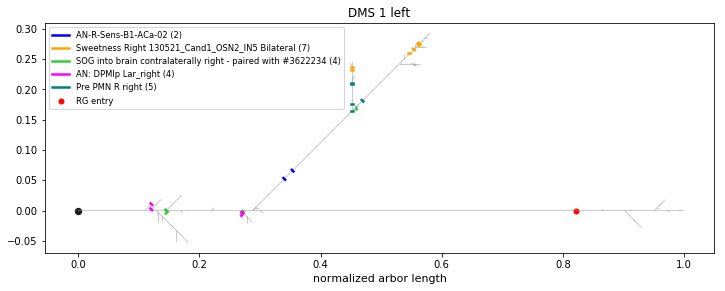

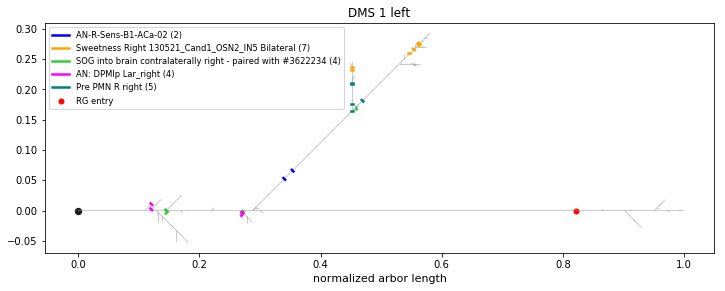

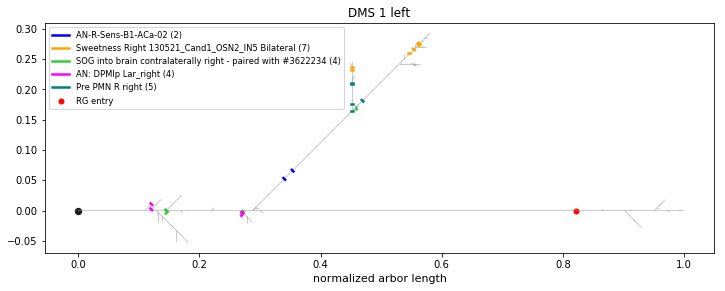

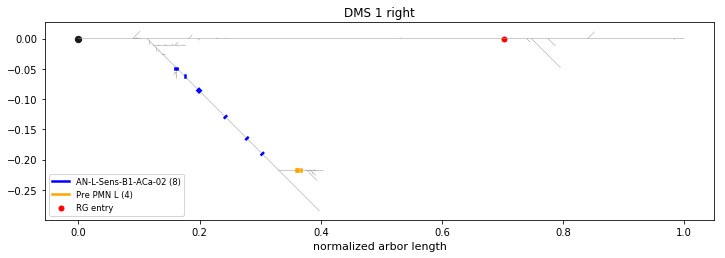

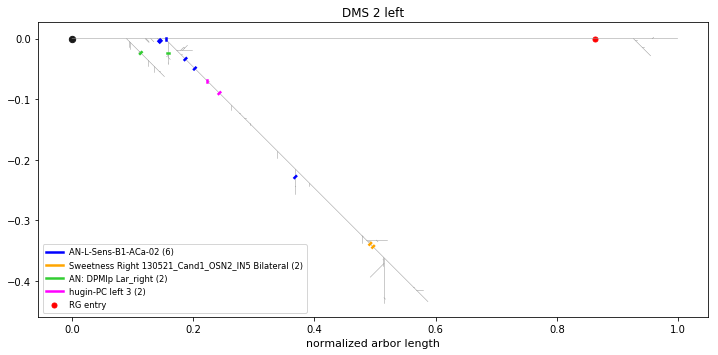

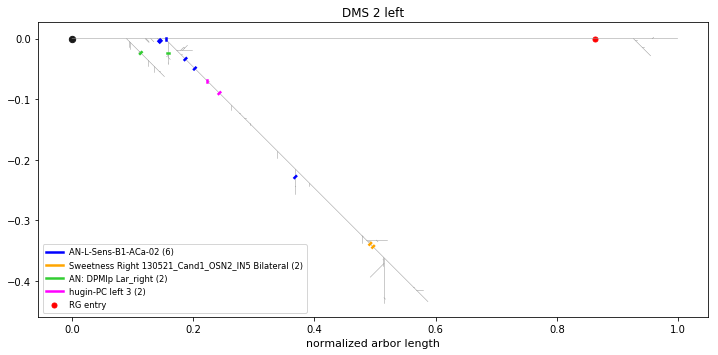

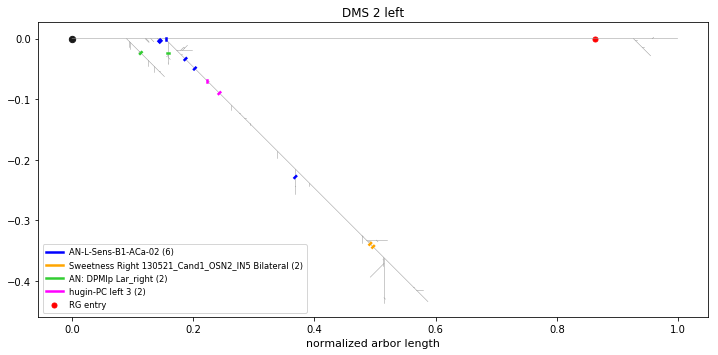

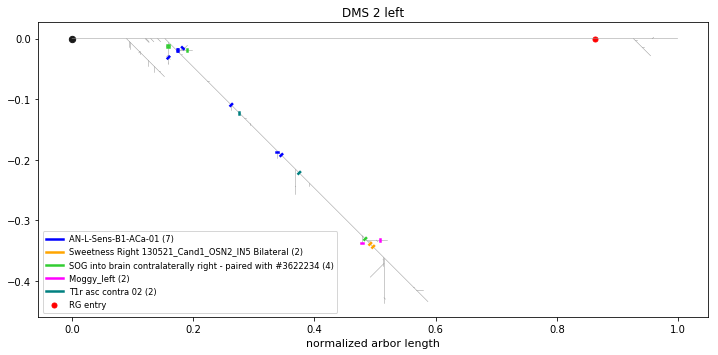

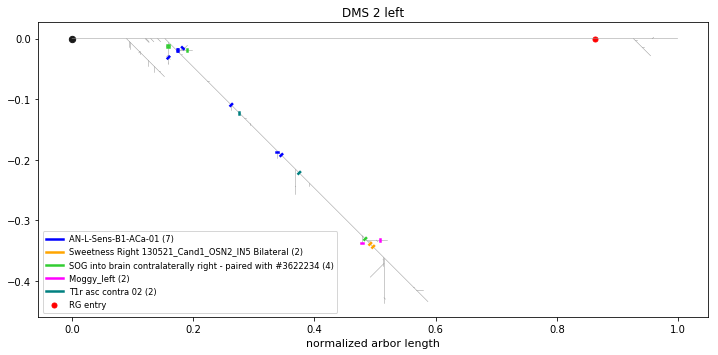

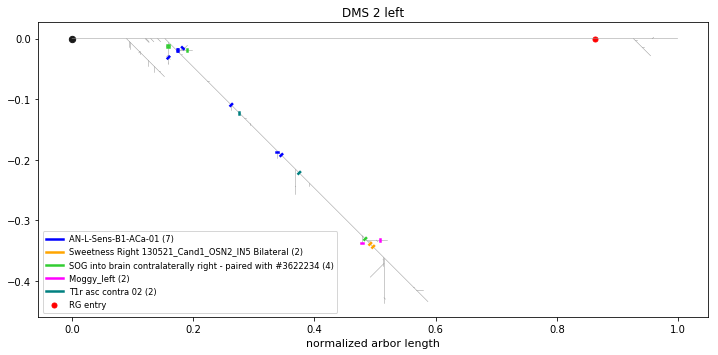

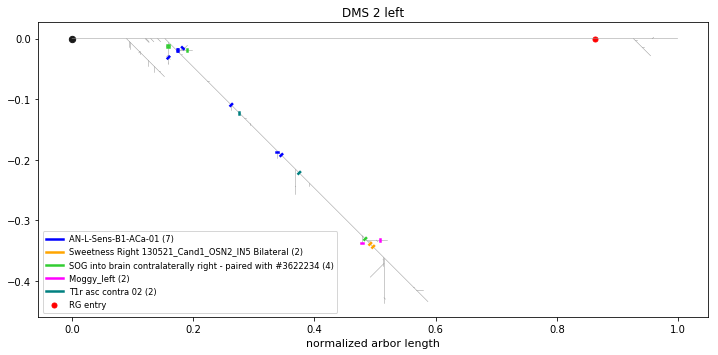

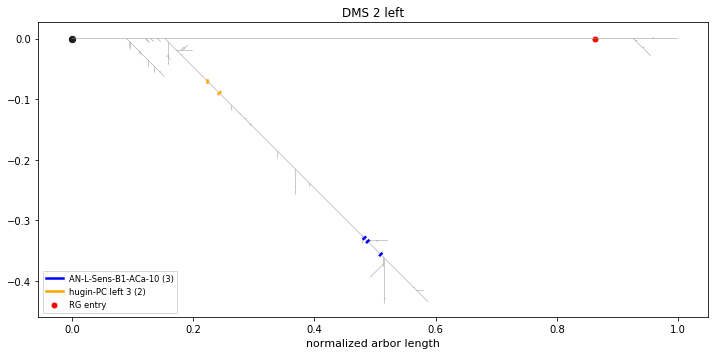

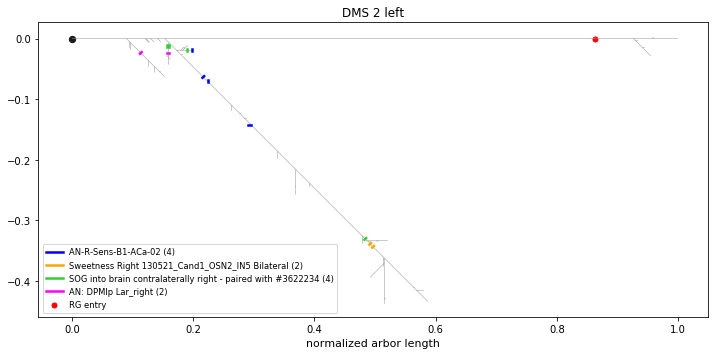

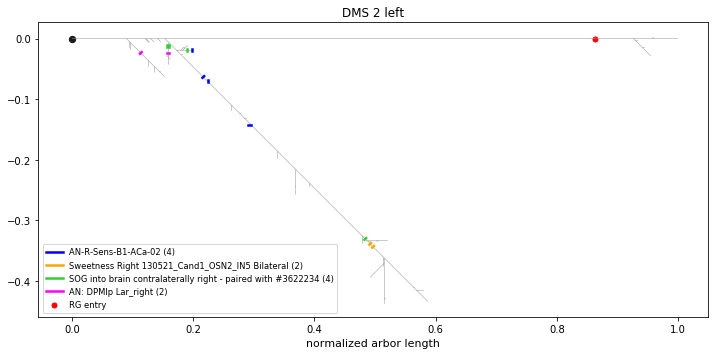

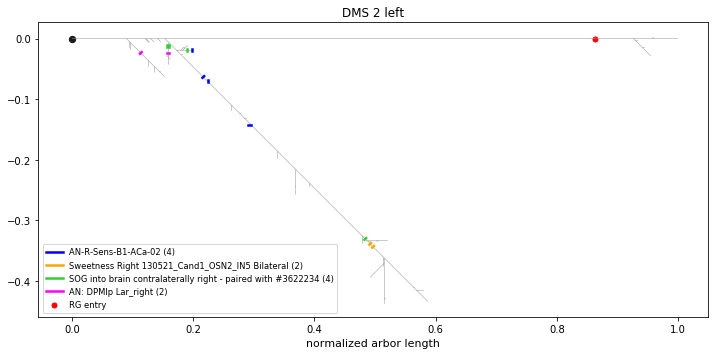

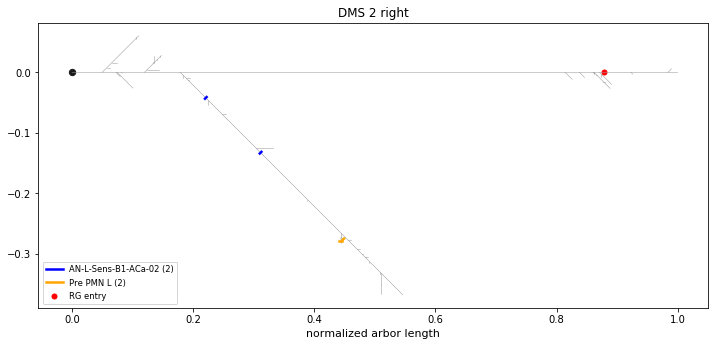

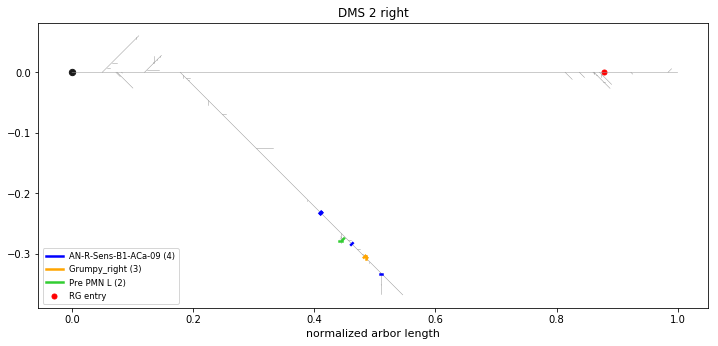

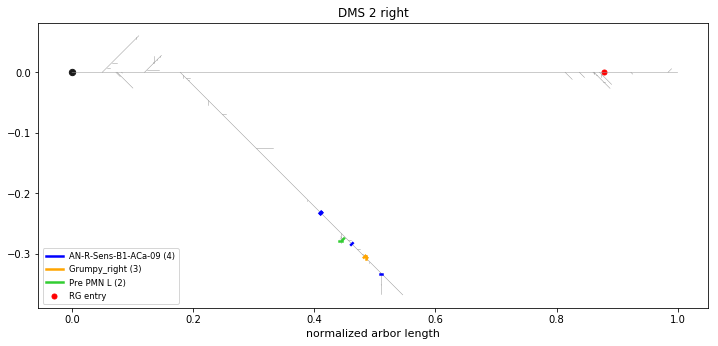

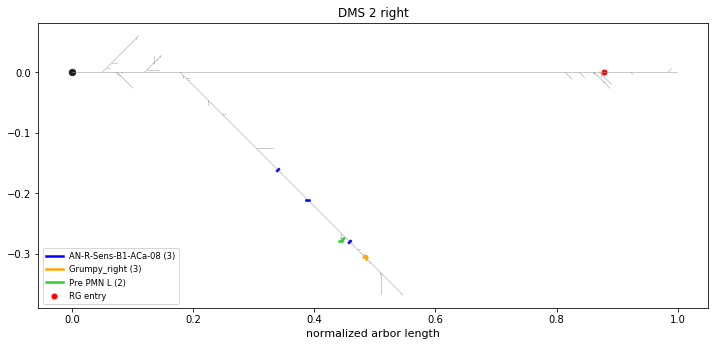

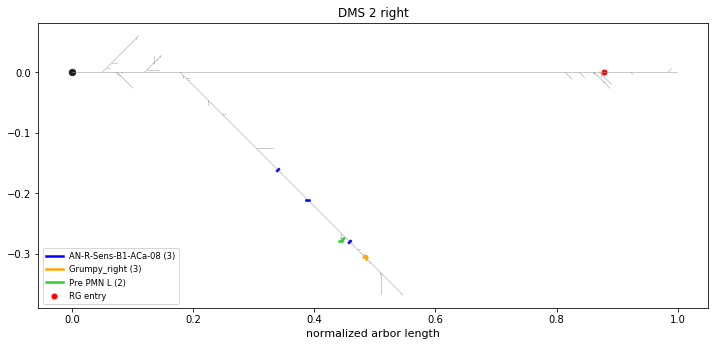

In [42]:
# all_dendrograms(dms_sen,new_boi)

HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:01<00:00, 30.78it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:01<00:00, 31.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:01<00:00, 44.33it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:02<00:00, 29.51it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:01<00:00, 42.19it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 60/60 [00:01<00:00, 44.00it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 52/52 [00:01<00:00, 30.47it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 52/52 [00:01<00:00, 41.54it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 52/52 [00:01<00:00, 34.45it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 93/93 [00:03<00:00, 39.44it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 93/93 [00:03<00:00, 25.36it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 93/93 [00:03<00:00, 25.05it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 93/93 [00:03<00:00, 25.01it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 93/93 [00:03<00:00, 24.94it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 64/64 [00:01<00:00, 34.55it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 64/64 [00:02<00:00, 43.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 64/64 [00:01<00:00, 32.81it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 64/64 [00:01<00:00, 32.22it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 64/64 [00:01<00:00, 35.26it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:01<00:00, 32.59it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

Dendrogram: 100%|██████████| 61/61 [00:01<00:00, 31.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:01<00:00, 30.80it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 28.37it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:01<00:00, 30.95it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:01<00:00, 31.86it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:01<00:00, 32.37it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 64/64 [00:02<00:00, 30.26it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 64/64 [00:02<00:00, 30.42it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 64/64 [00:02<00:00, 29.31it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 64/64 [00:02<00:00, 29.61it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 58/58 [00:02<00:00, 24.44it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 58/58 [00:02<00:00, 22.92it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 55/55 [00:01<00:00, 36.92it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 55/55 [00:01<00:00, 28.79it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 55/55 [00:01<00:00, 28.88it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 55/55 [00:02<00:00, 36.28it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 32.23it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 31.97it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 77/77 [00:02<00:00, 46.55it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 77/77 [00:02<00:00, 31.98it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 61/61 [00:02<00:00, 26.92it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 57/57 [00:01<00:00, 29.51it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 57/57 [00:01<00:00, 28.79it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 57/57 [00:01<00:00, 29.04it/s]


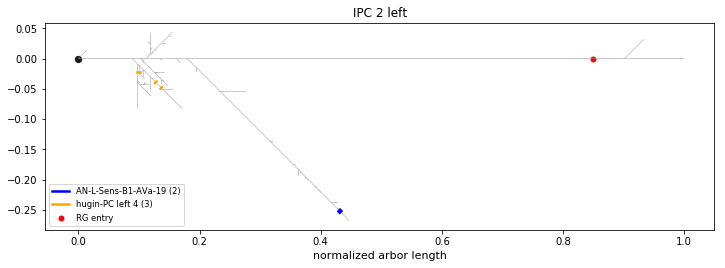

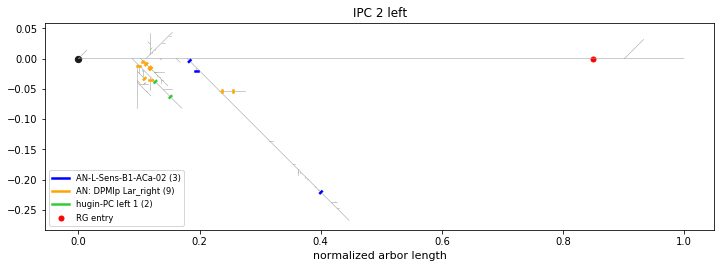

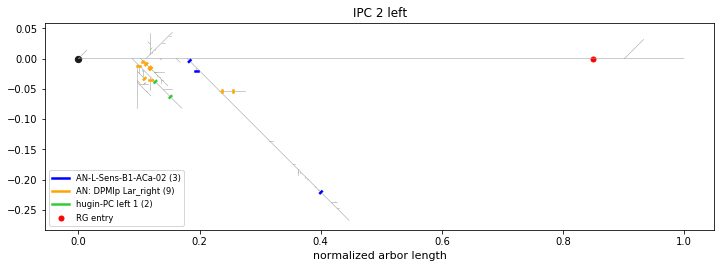

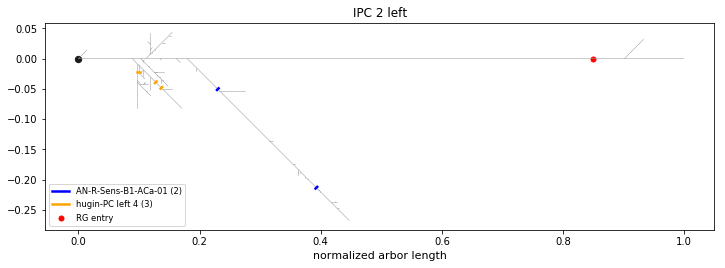

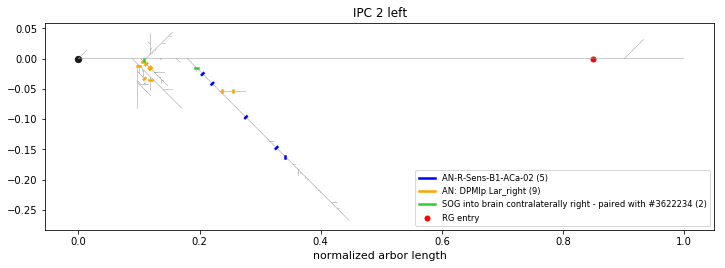

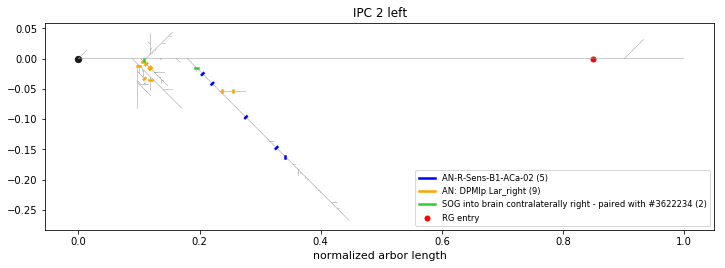

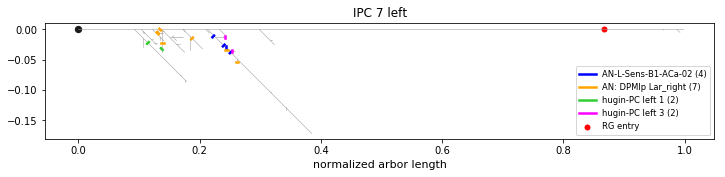

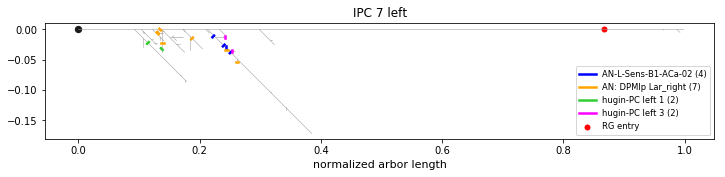

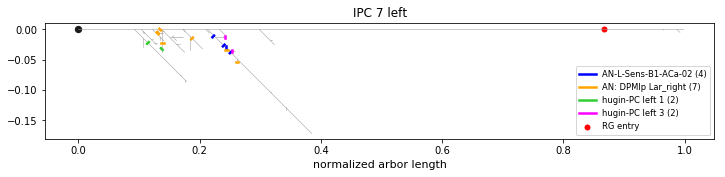

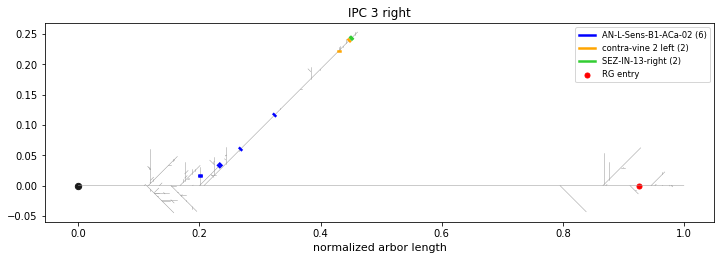

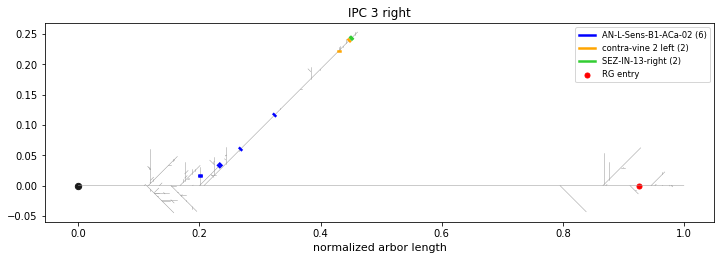

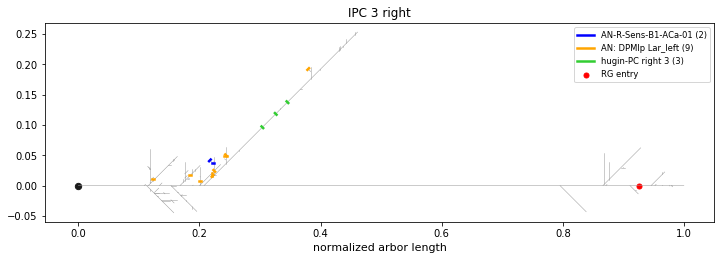

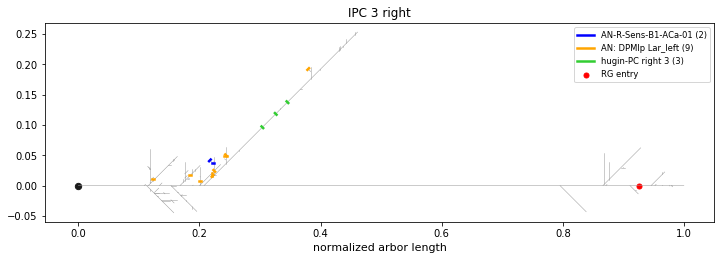

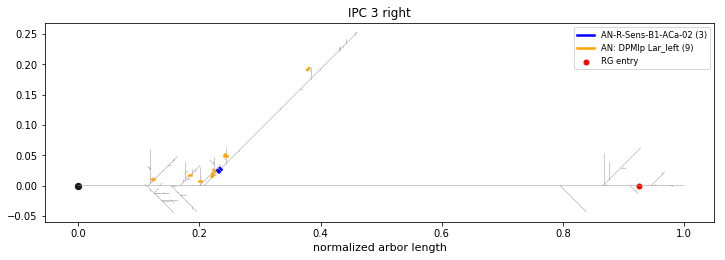

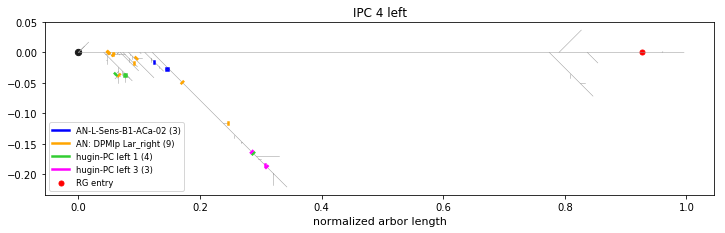

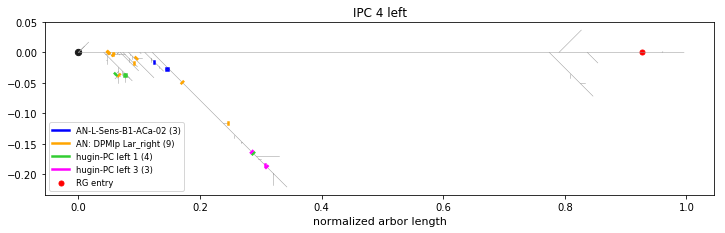

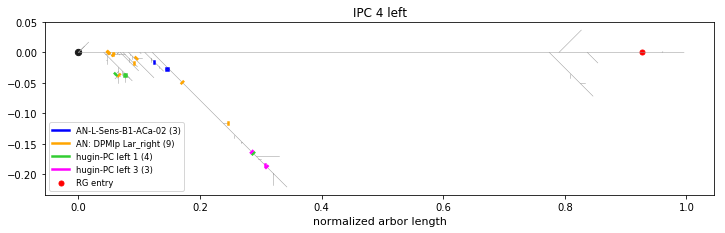

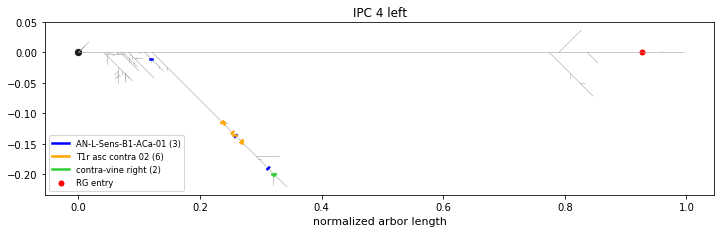

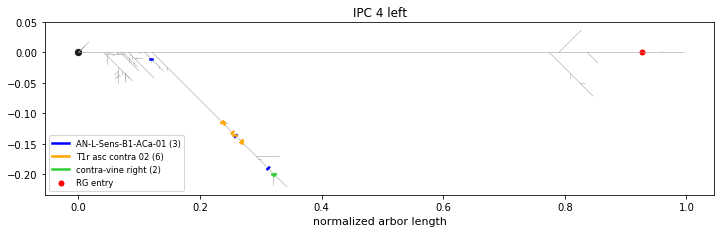

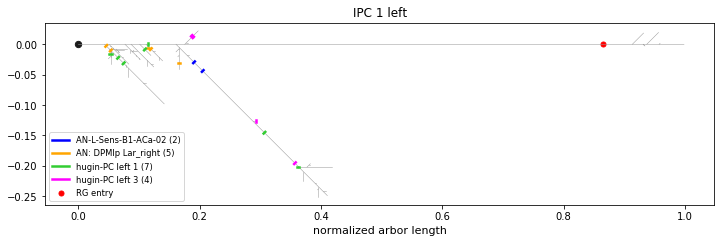

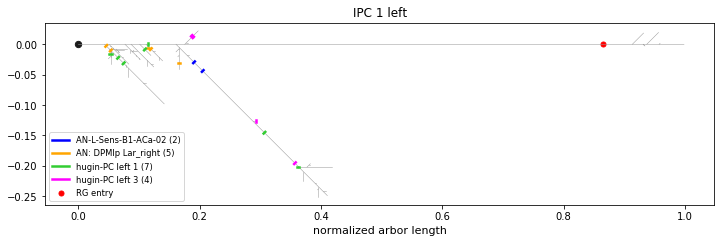

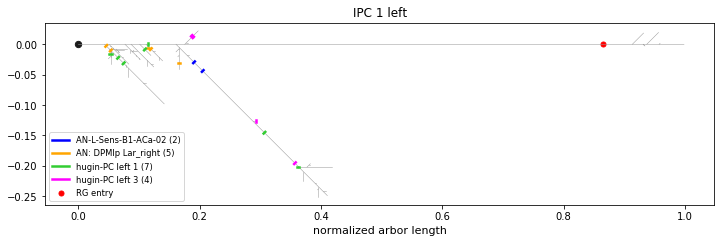

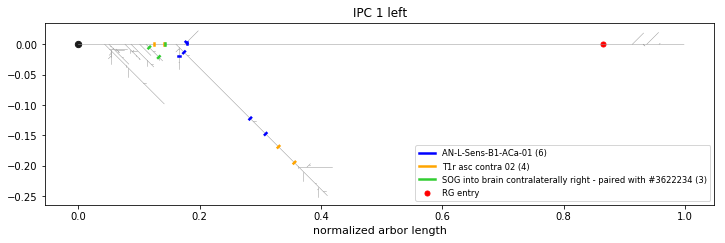

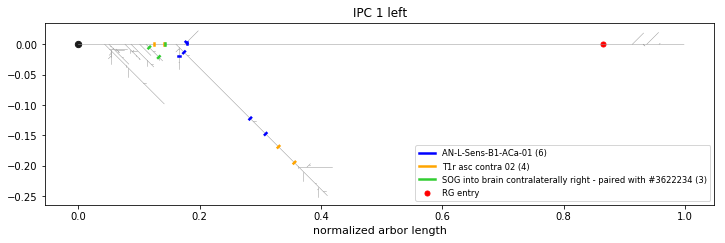

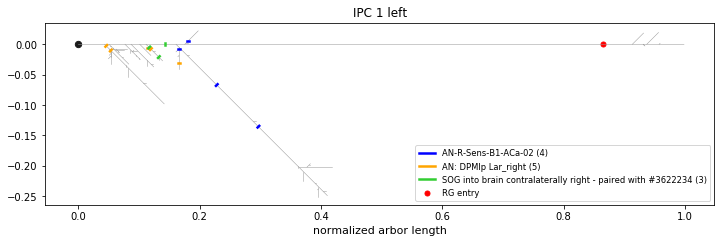

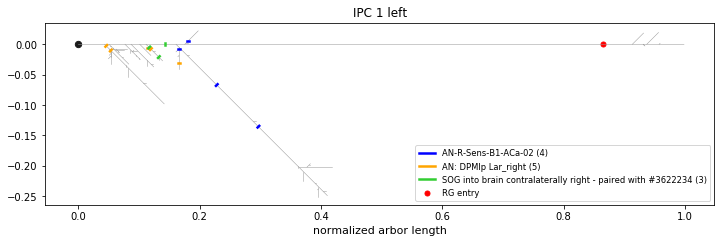

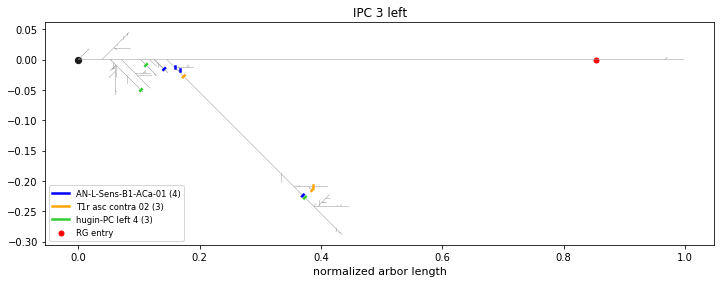

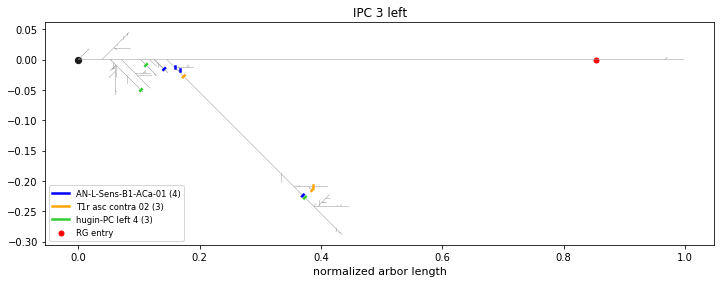

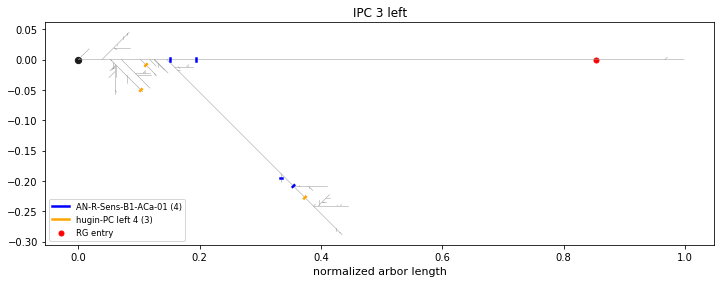

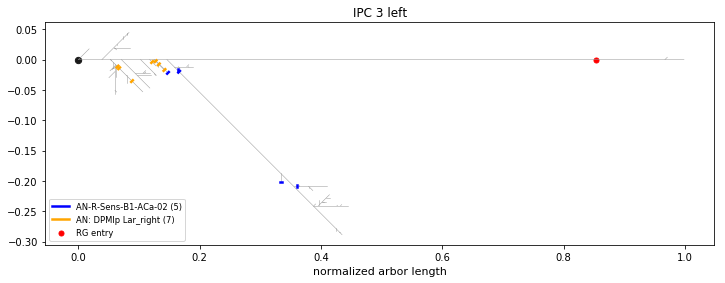

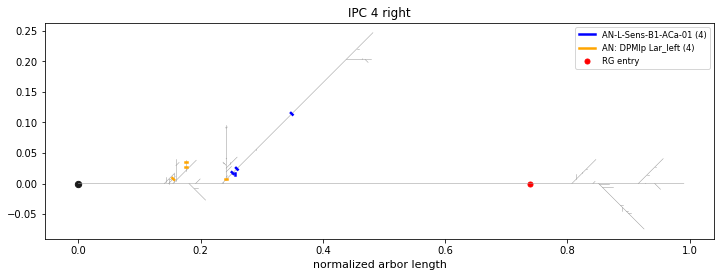

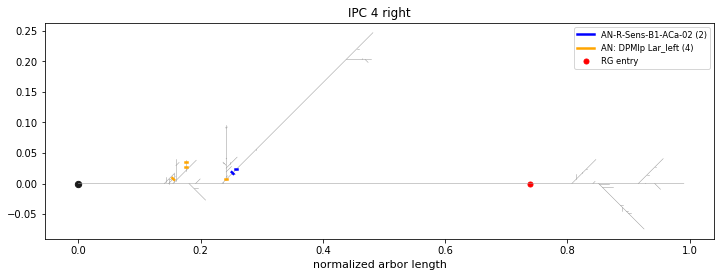

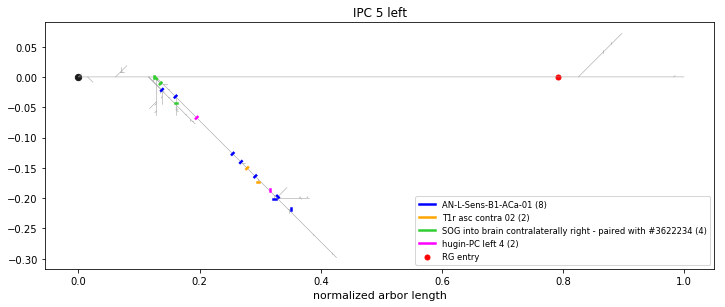

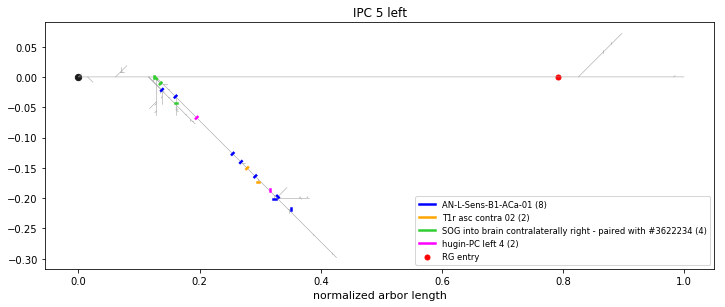

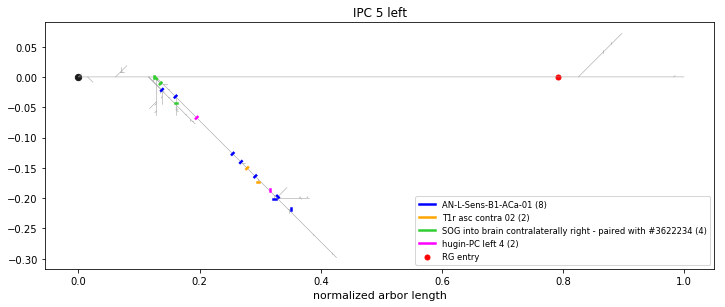

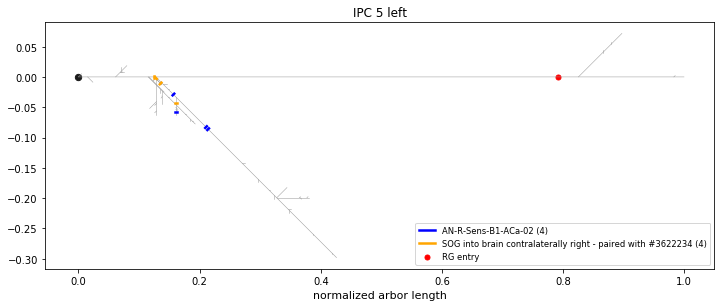

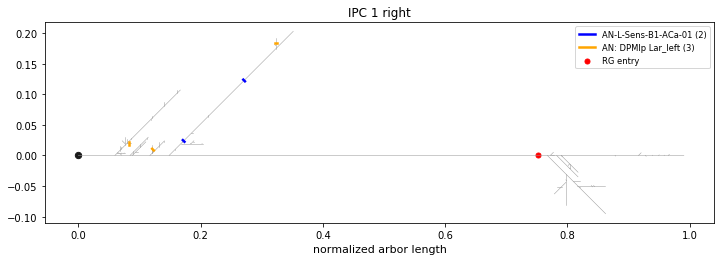

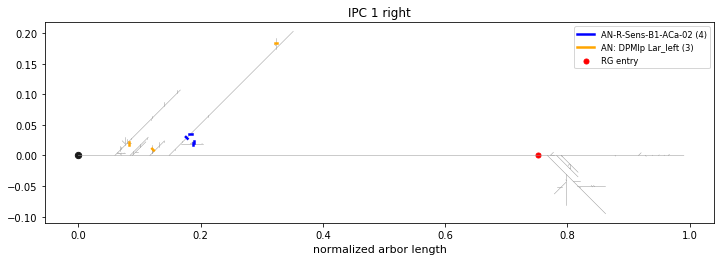

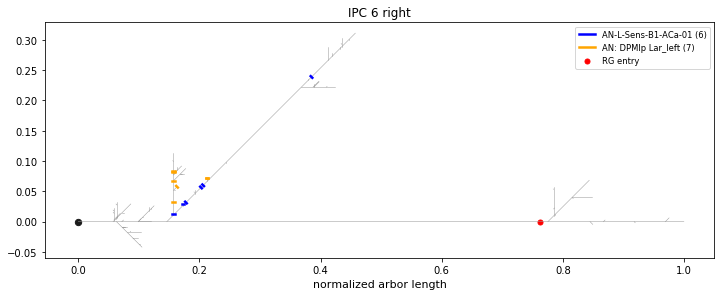

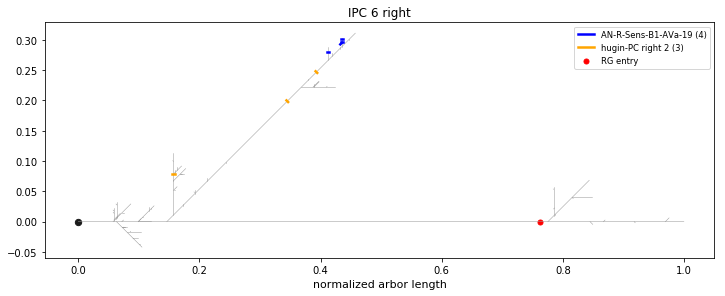

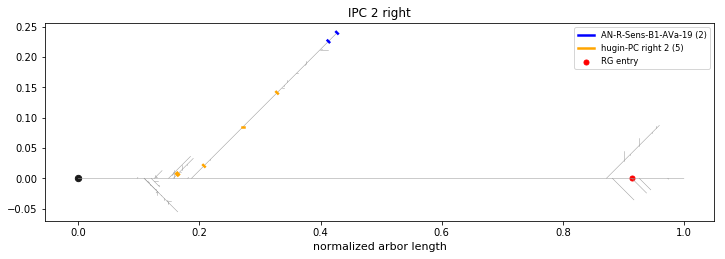

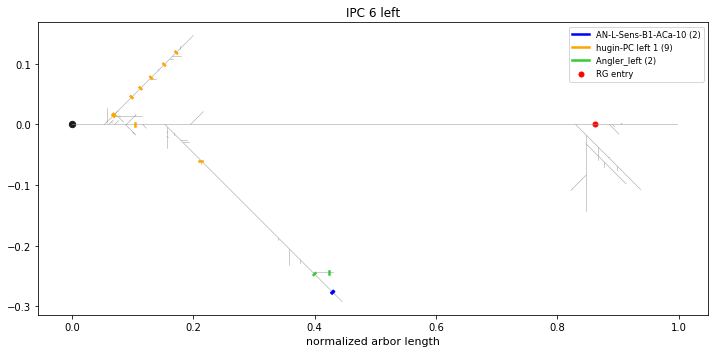

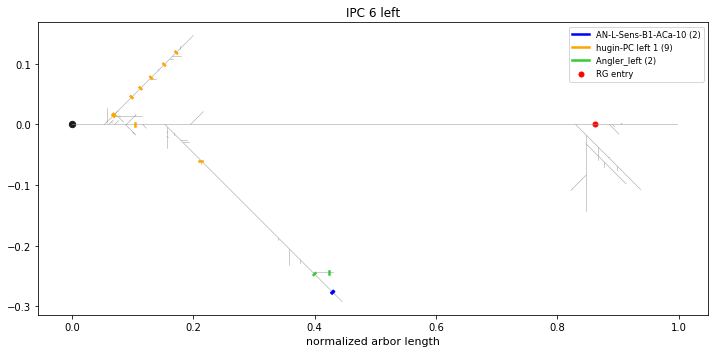

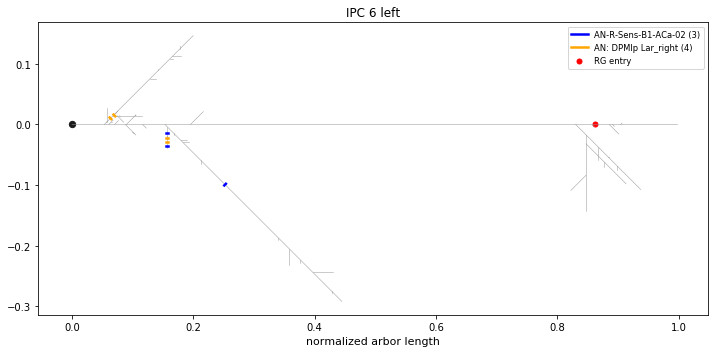

In [41]:
# all_dendrograms(ipc_sen,new_boi)

HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 33.66it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.91it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 38.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.78it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 37.88it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.76it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 38.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 38.03it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 26.58it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.86it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 38.31it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 28.04it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 38.27it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 26.69it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 26.65it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 26.55it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.24it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 34.83it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.87it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 37.67it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 28.29it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.78it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 36.99it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.63it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.89it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.79it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.97it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.55it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.00it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 26.80it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 37.51it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.72it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.50it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 38.51it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 86/86 [00:03<00:00, 27.84it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.12it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 30.04it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.45it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.07it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.31it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 28.89it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 30.01it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.32it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 30.34it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.80it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.90it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 30.02it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 28.90it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.82it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 30.14it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 30.46it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 30.05it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.70it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.79it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.85it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 79/79 [00:02<00:00, 29.71it/s]


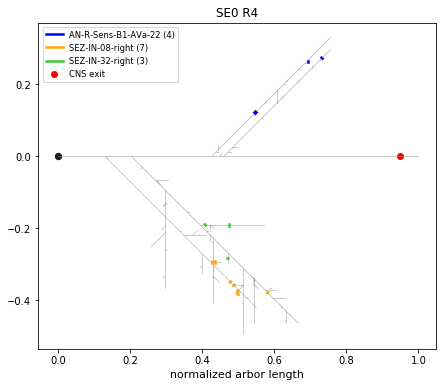

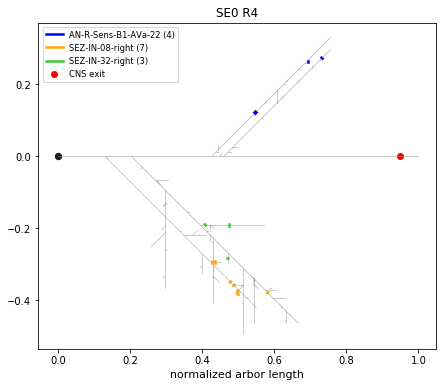

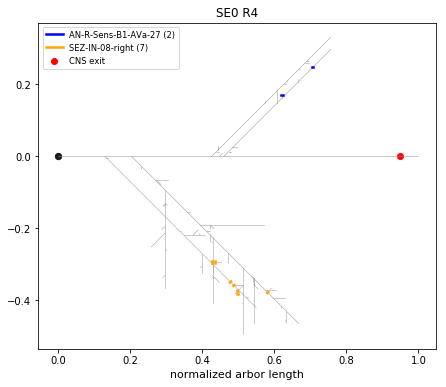

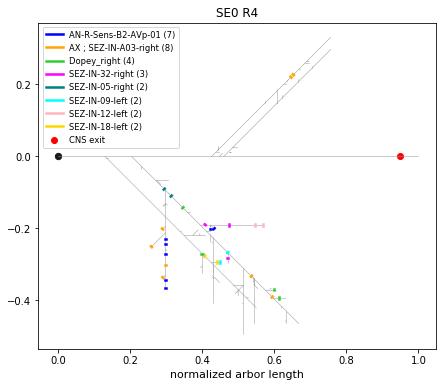

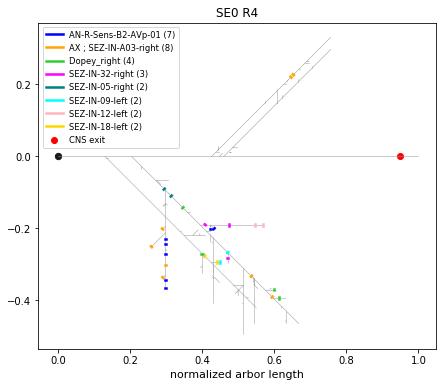

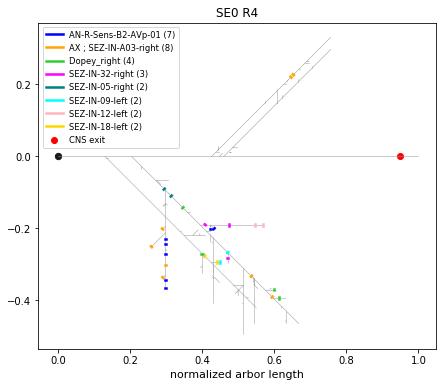

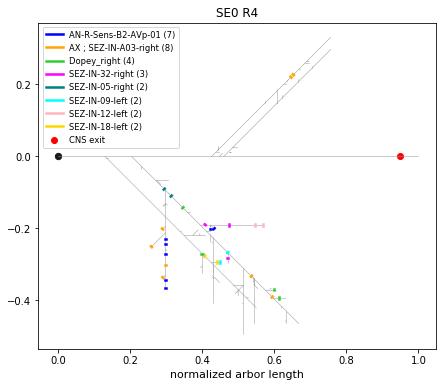

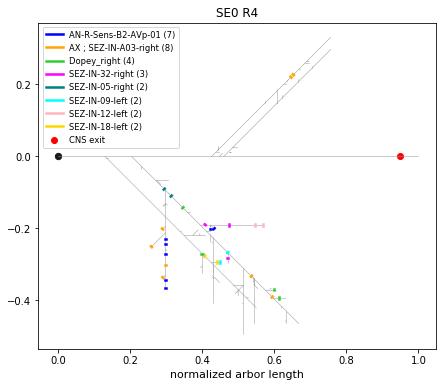

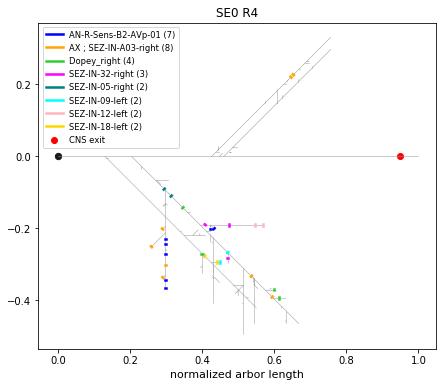

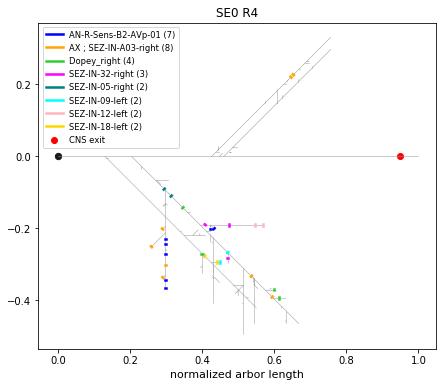

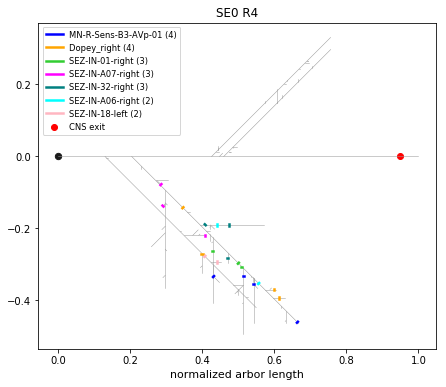

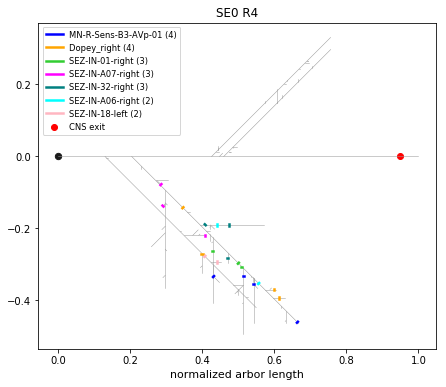

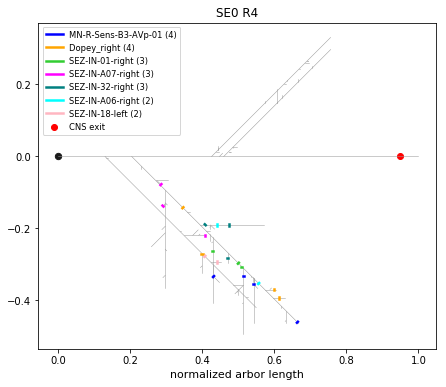

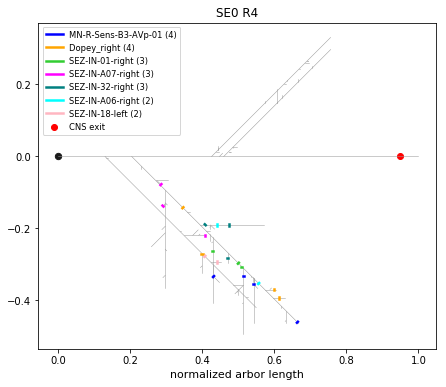

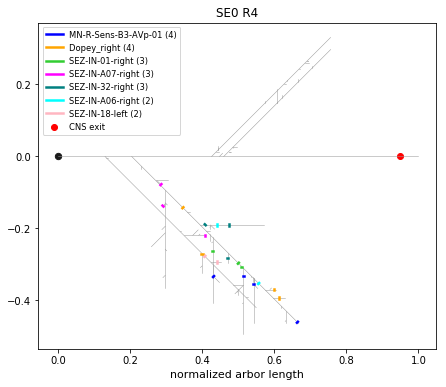

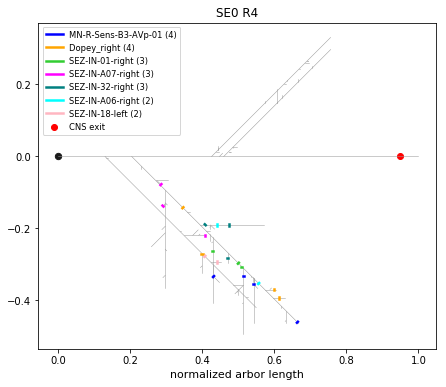

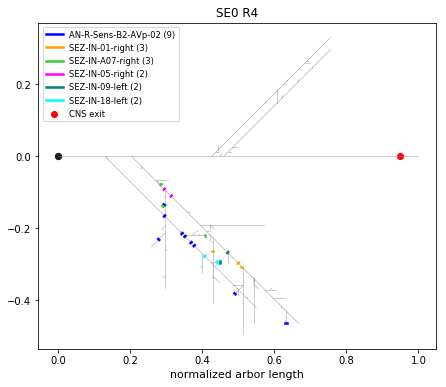

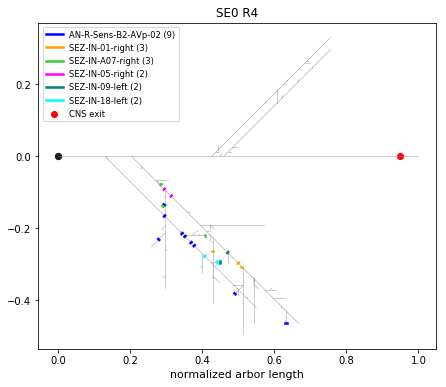

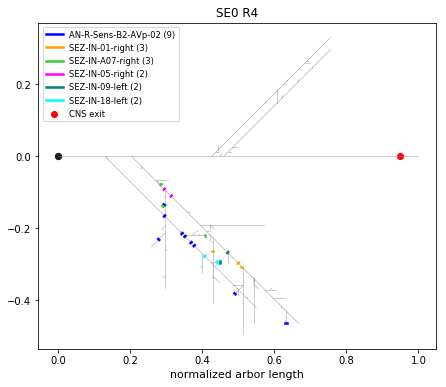

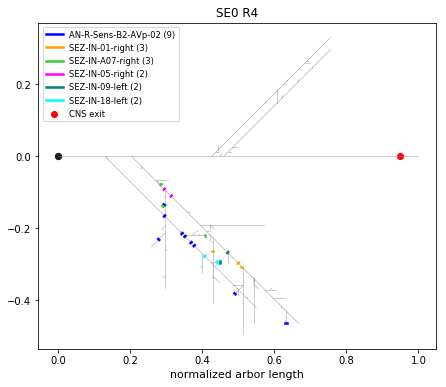

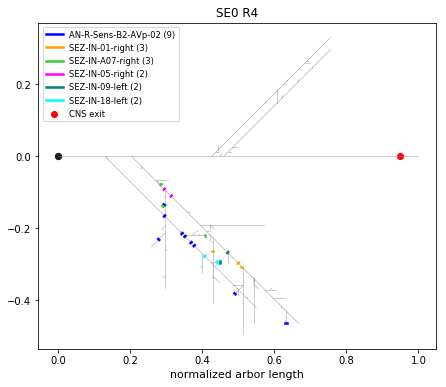

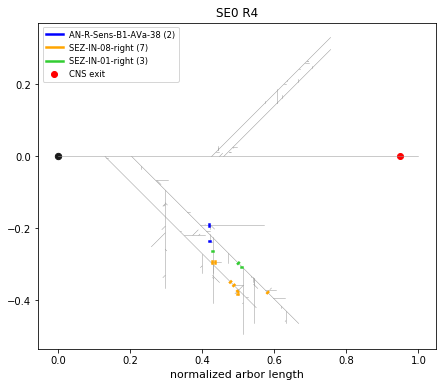

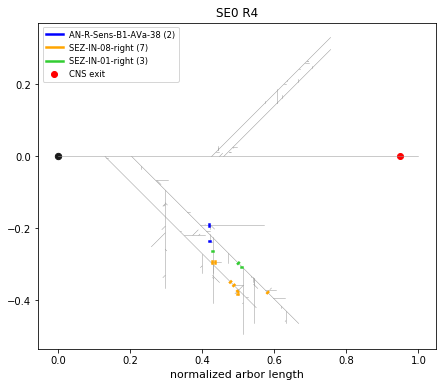

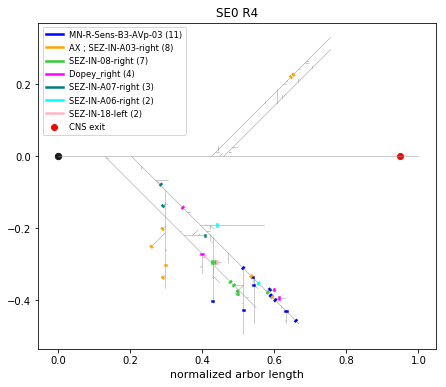

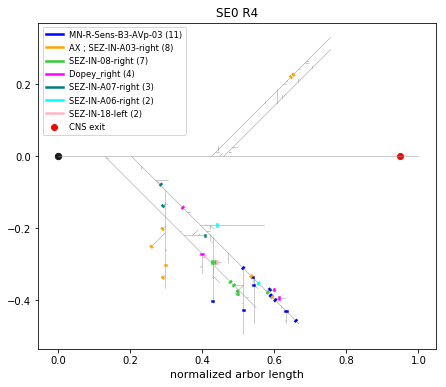

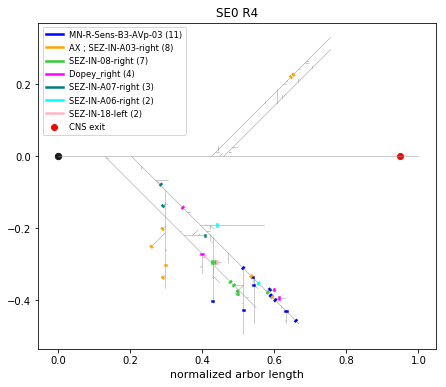

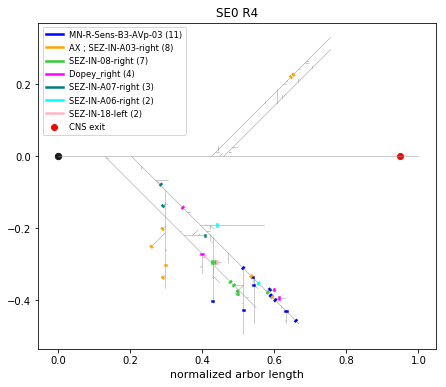

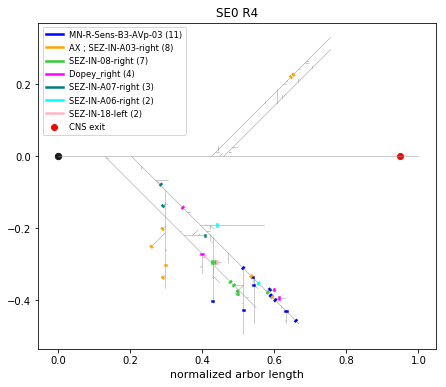

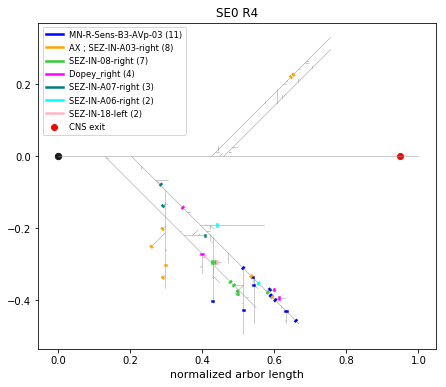

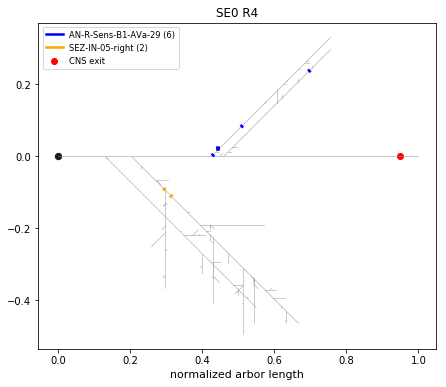

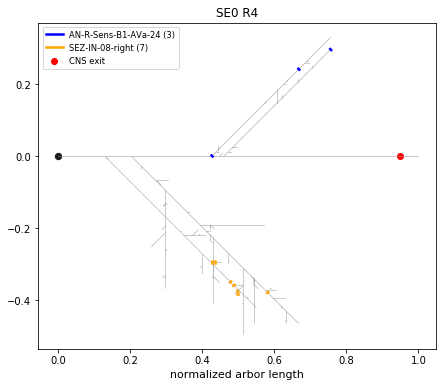

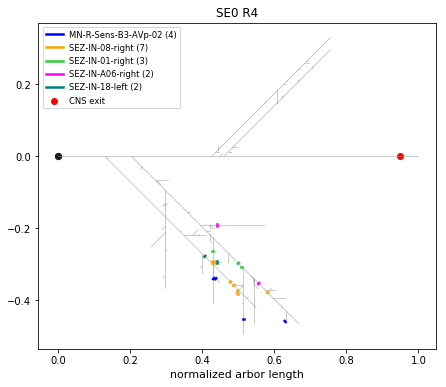

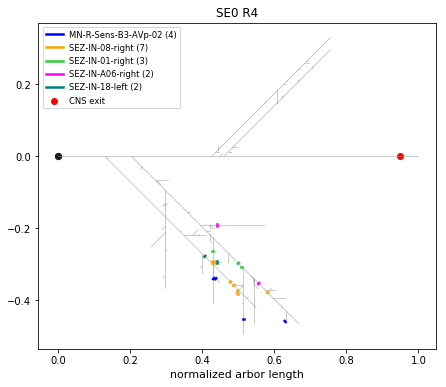

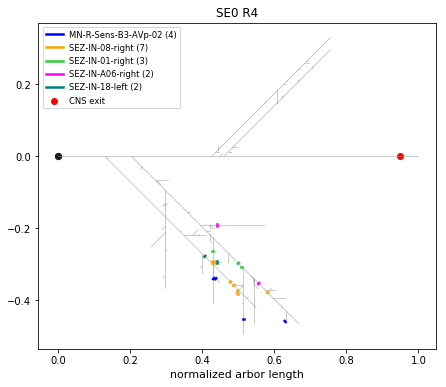

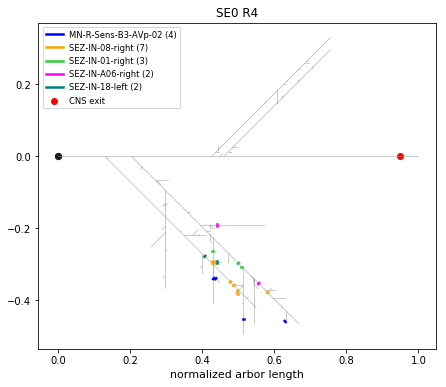

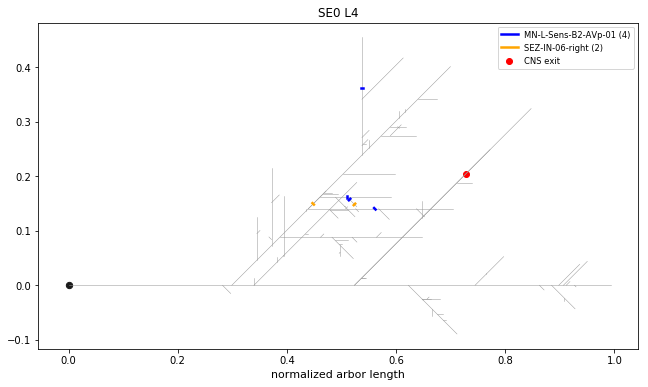

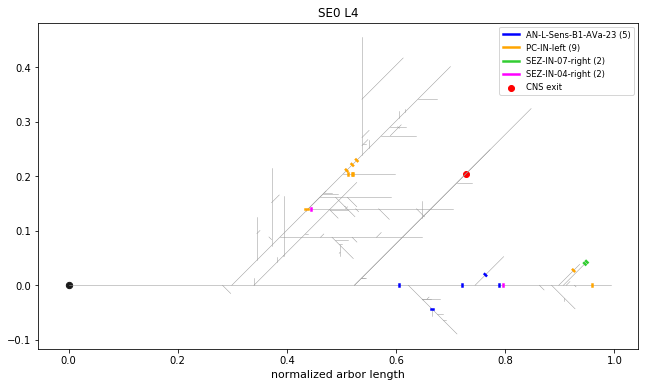

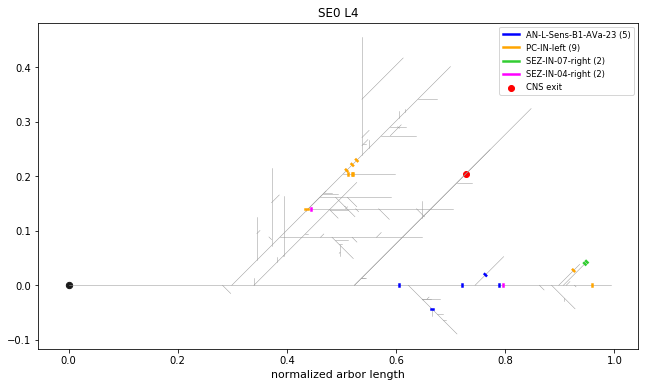

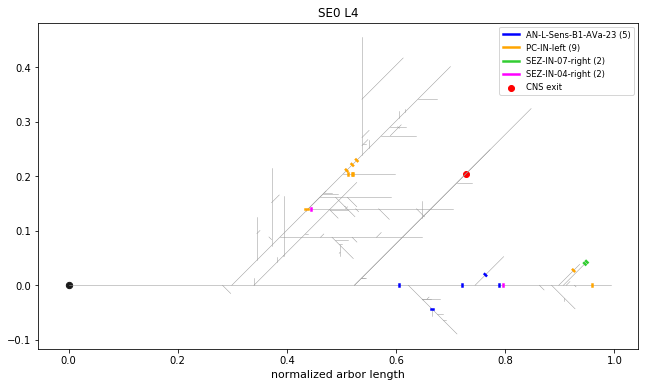

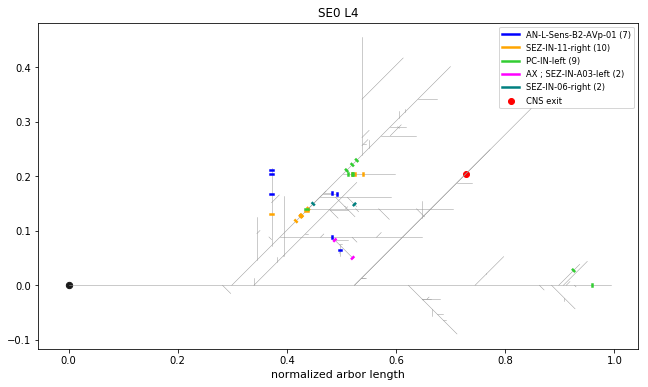

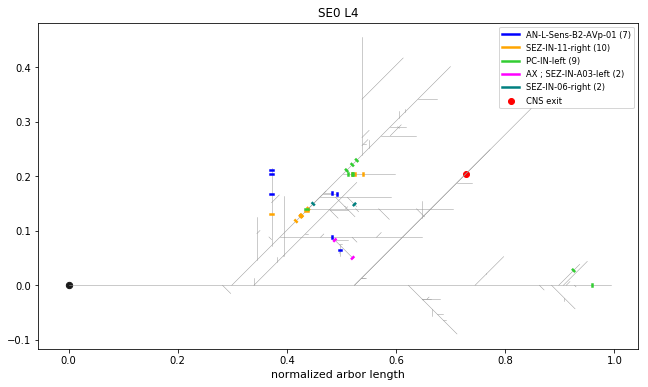

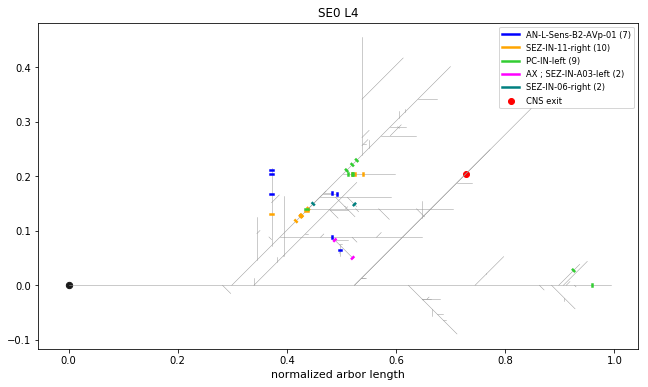

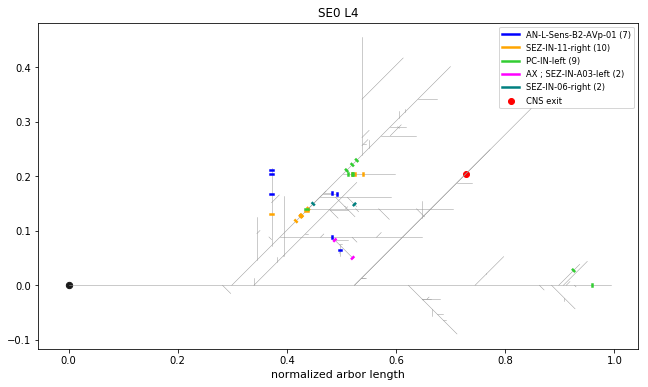

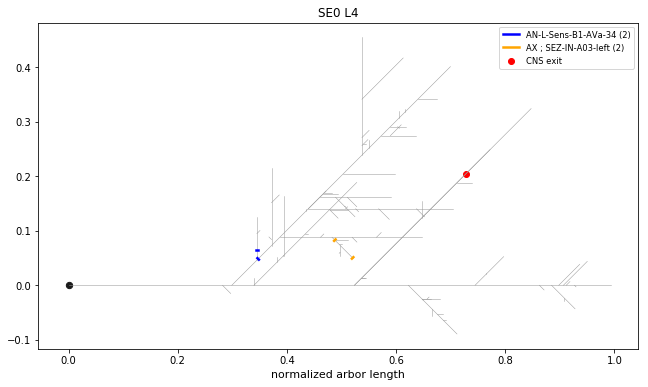

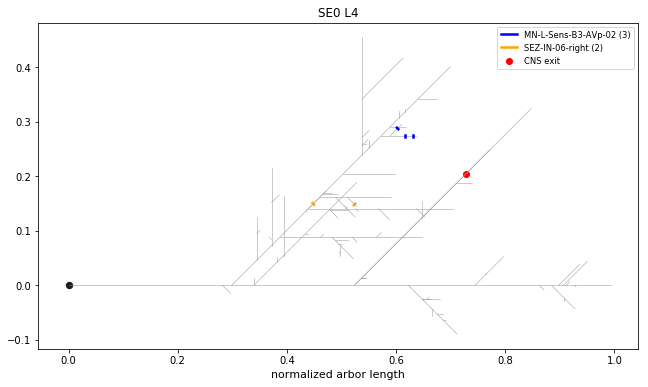

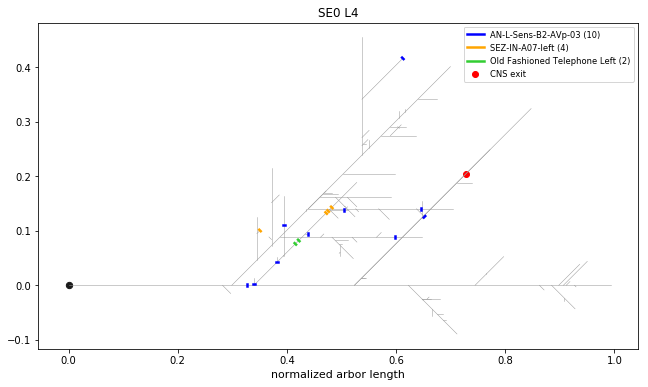

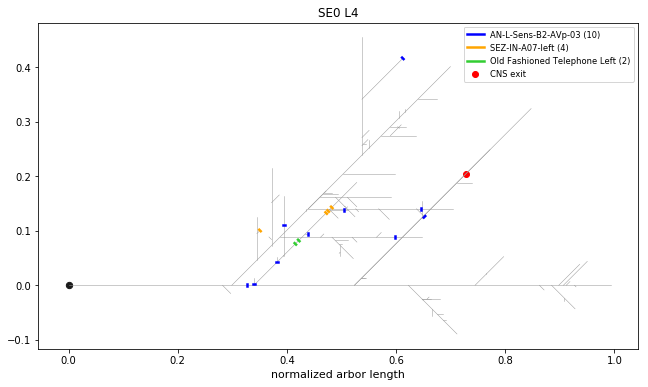

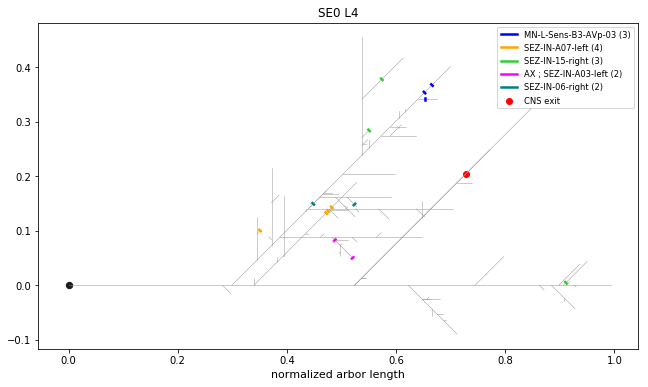

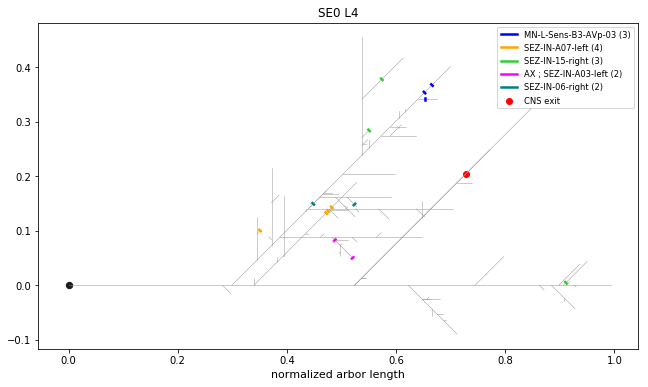

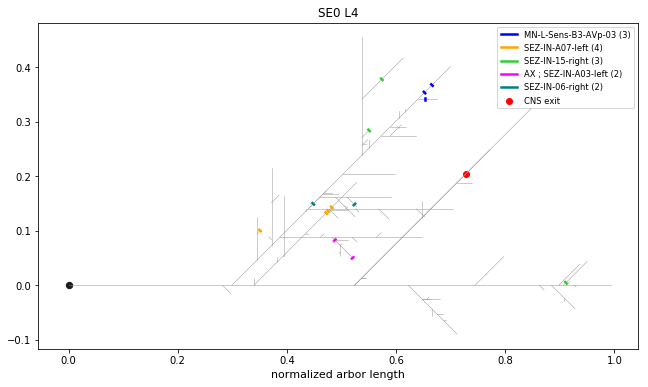

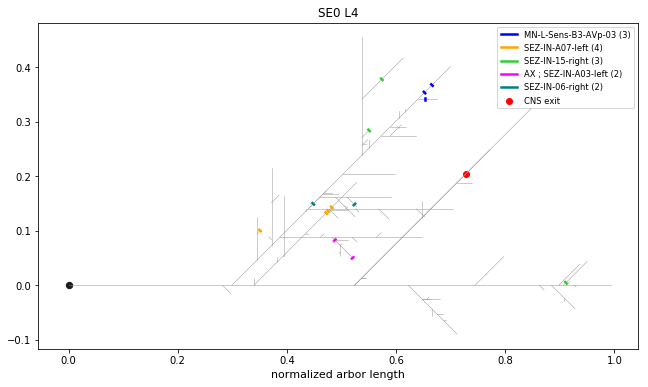

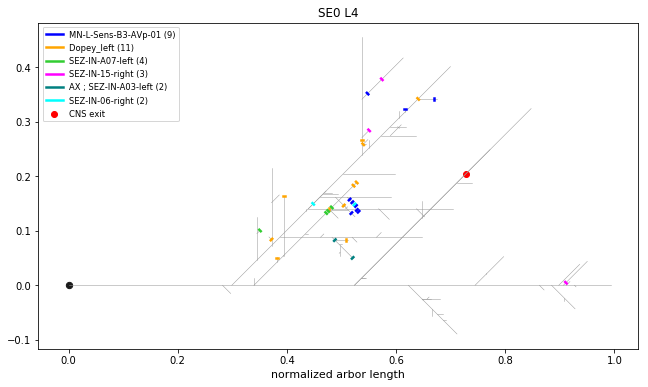

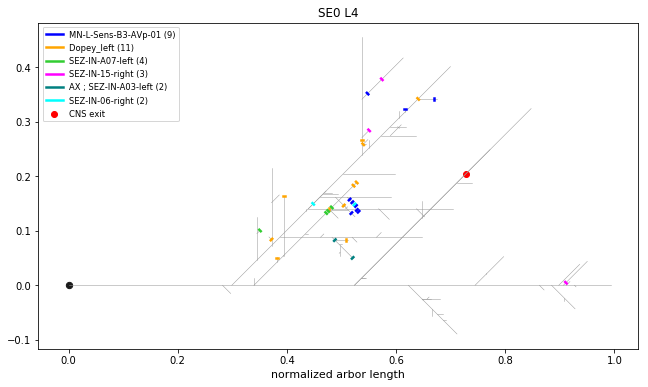

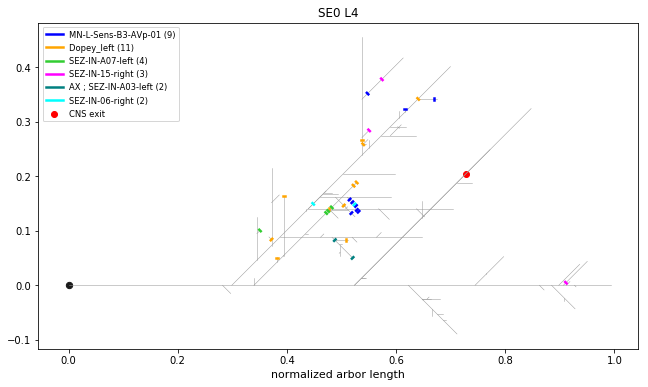

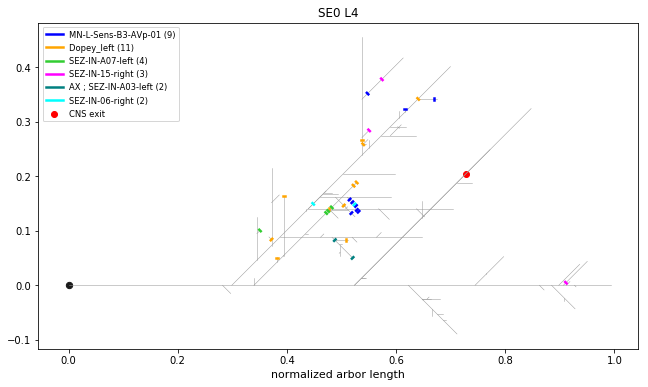

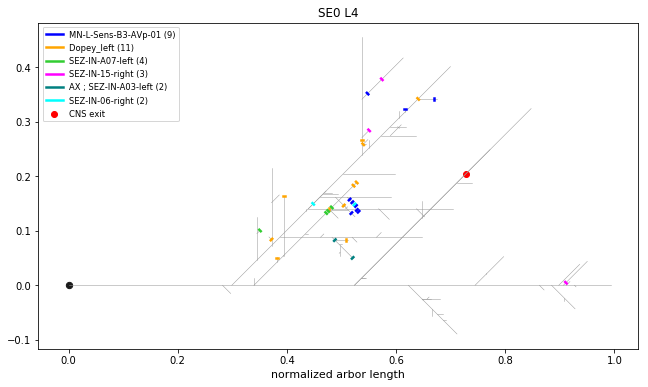

In [33]:
# all_dendrograms(se0p_sen,new_boi)

HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.51it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.56it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.52it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.19it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 23.97it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.35it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.34it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.41it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.50it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.37it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.68it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.50it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 40.10it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.29it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.01it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.37it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 39.87it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.47it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.68it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.11it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 23.22it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.27it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.39it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.40it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 39.68it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 23.53it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.50it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=7, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.02it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 39.24it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.34it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 39.90it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.18it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 39.81it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 87/87 [00:03<00:00, 24.29it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 29.96it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.31it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.07it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 29.85it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.02it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.12it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 29.83it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.17it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 27.34it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.00it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.09it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 27.77it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.25it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.13it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.25it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.17it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.28it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.21it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.26it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.06it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 80/80 [00:02<00:00, 30.26it/s]


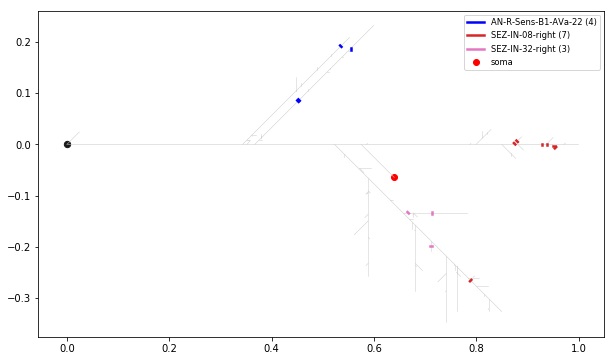

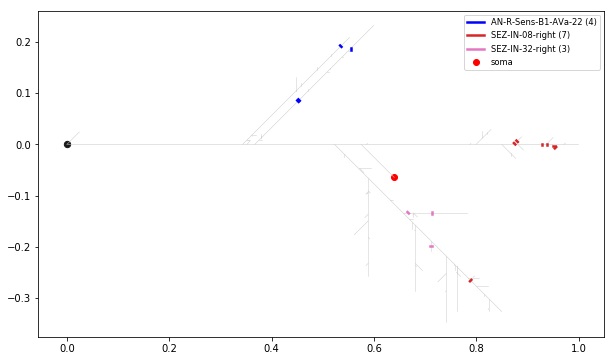

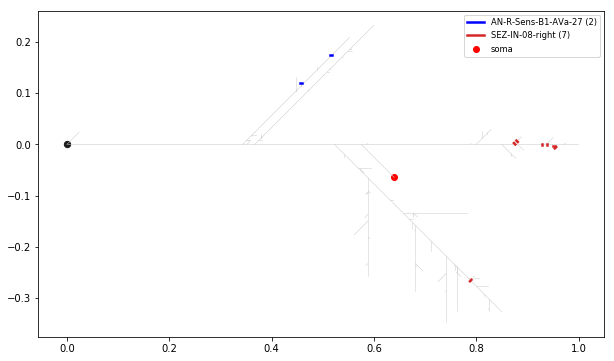

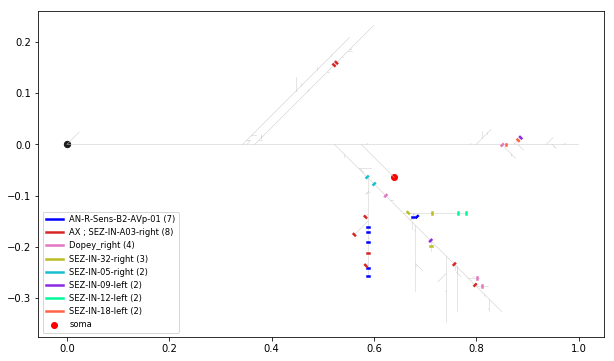

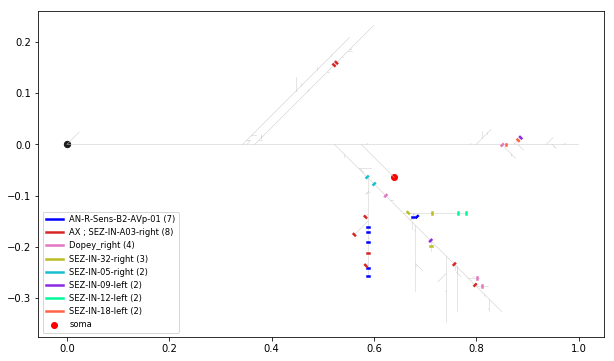

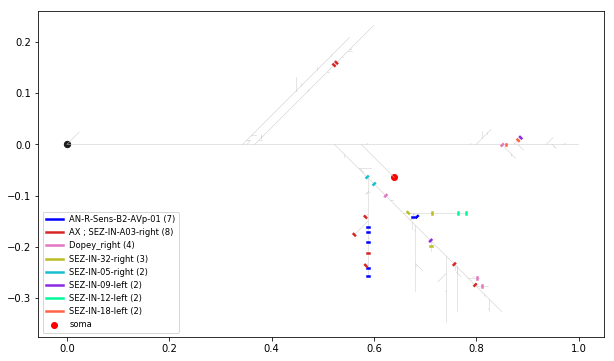

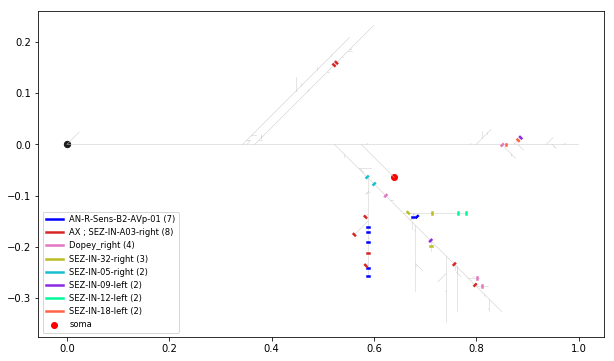

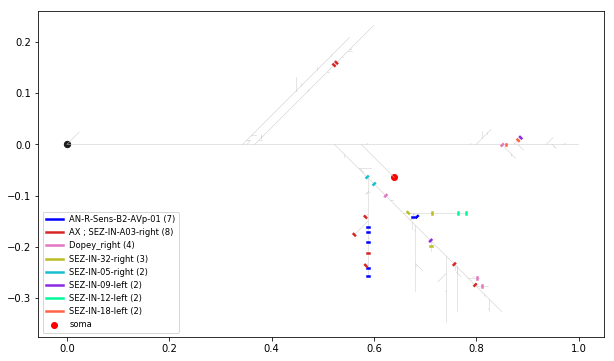

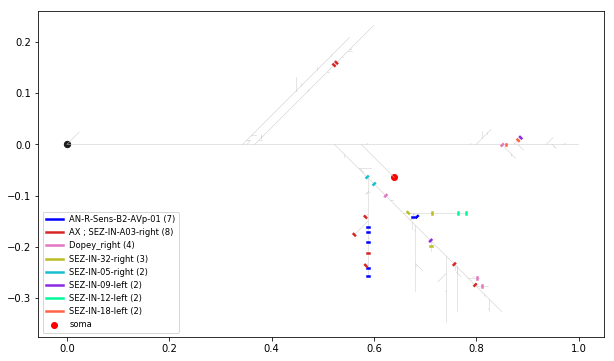

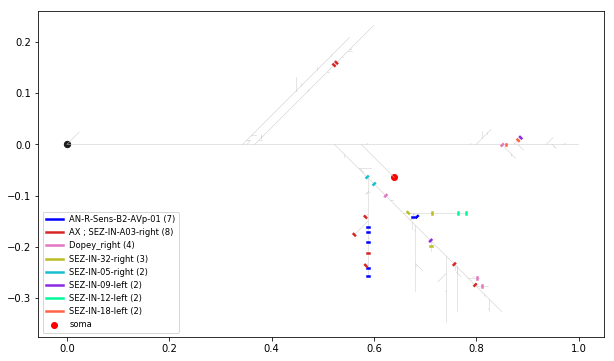

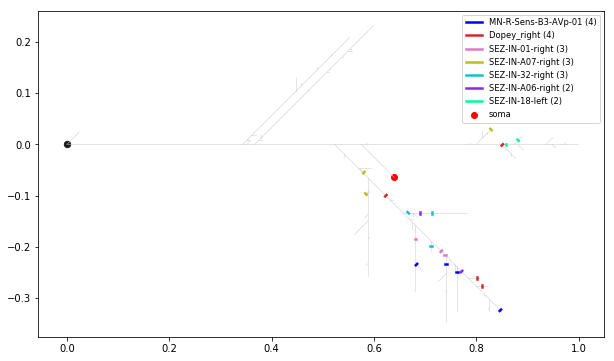

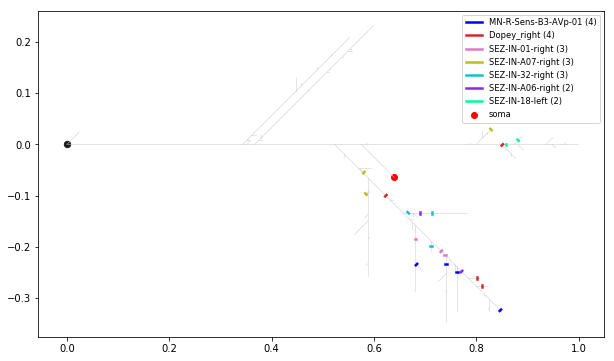

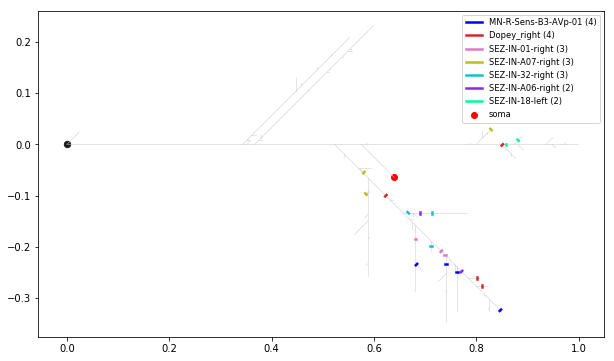

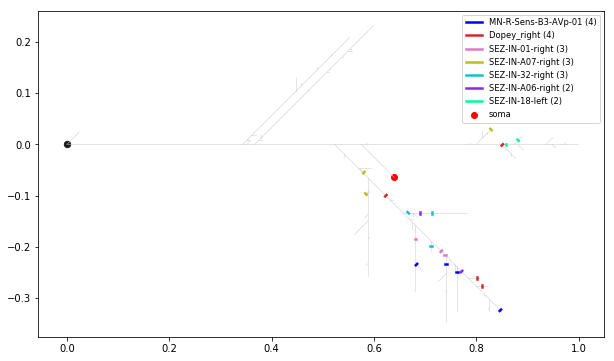

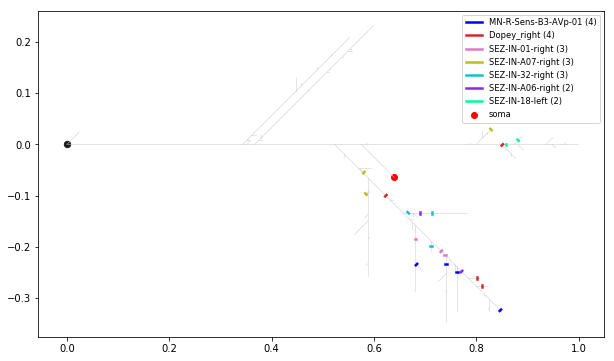

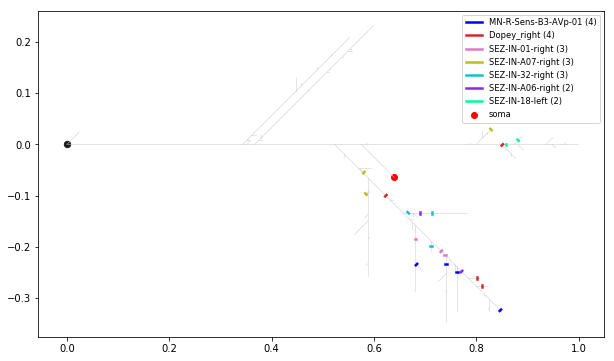

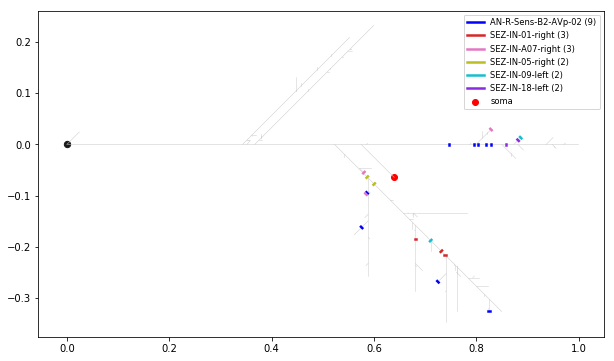

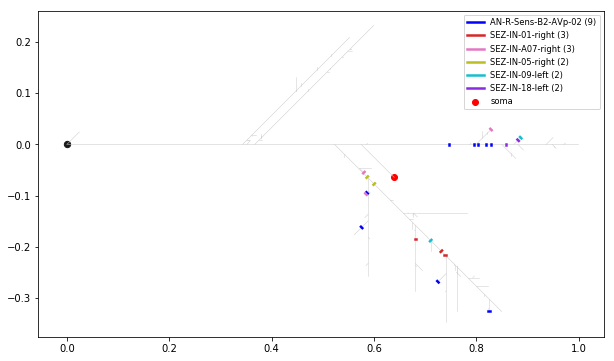

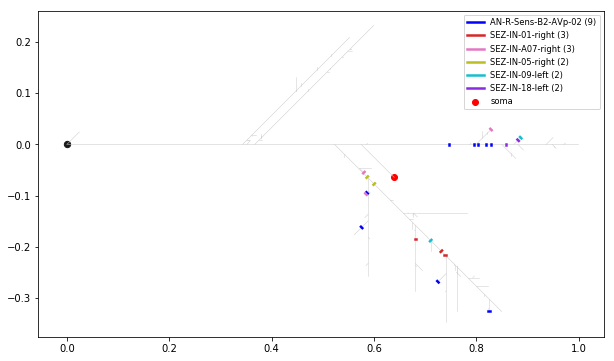

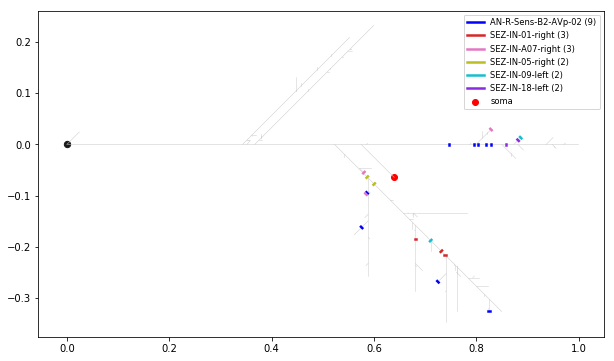

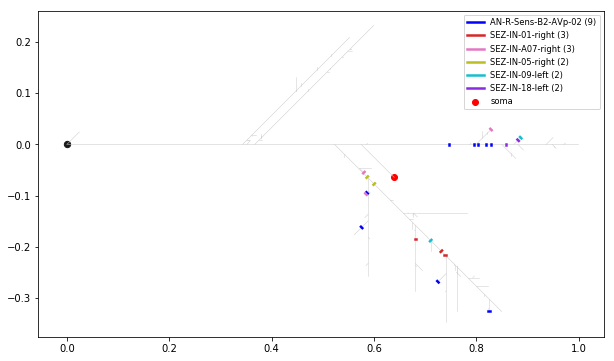

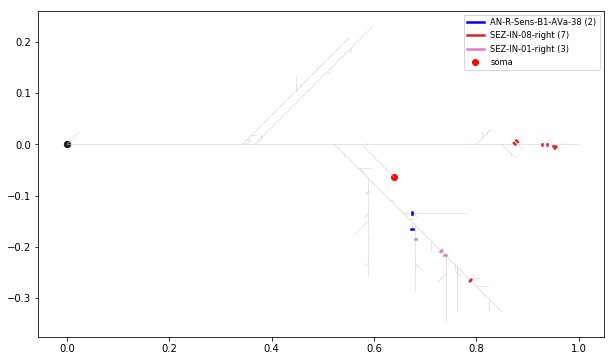

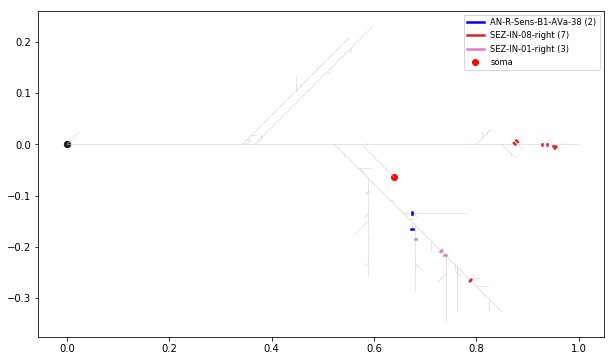

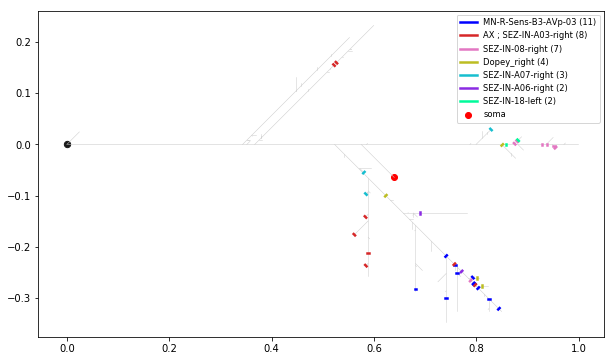

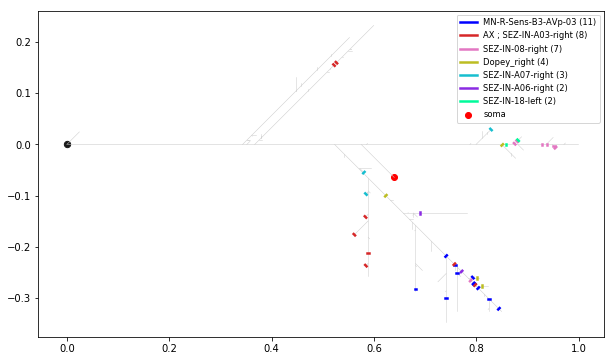

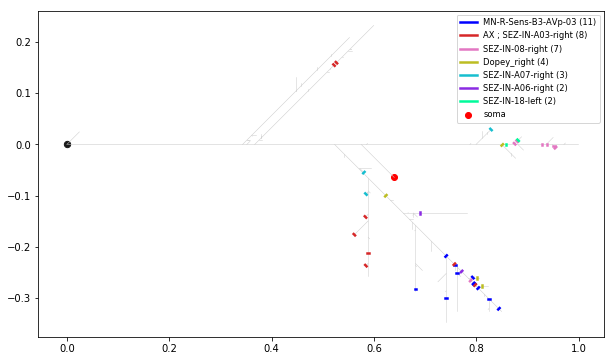

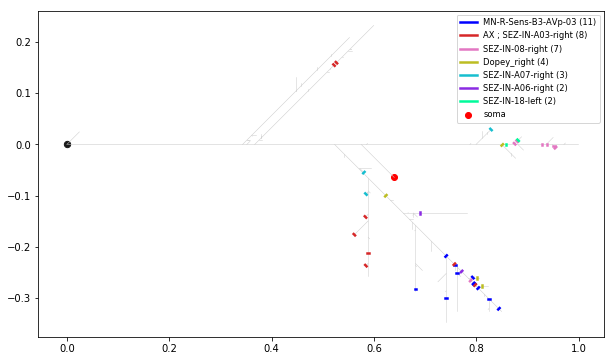

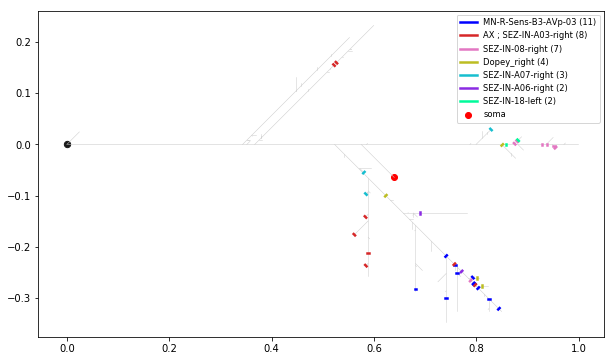

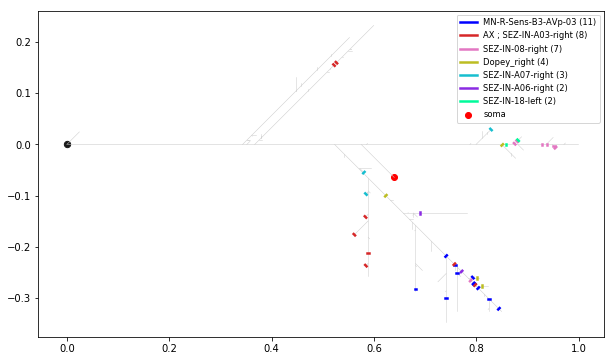

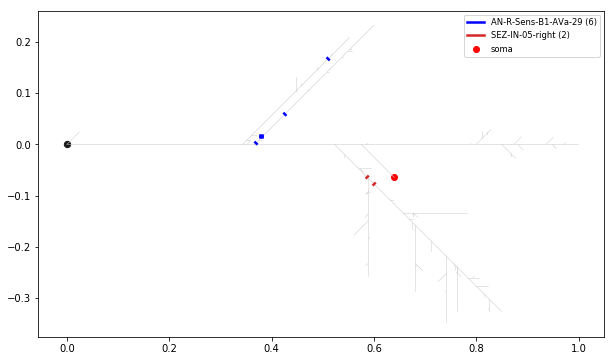

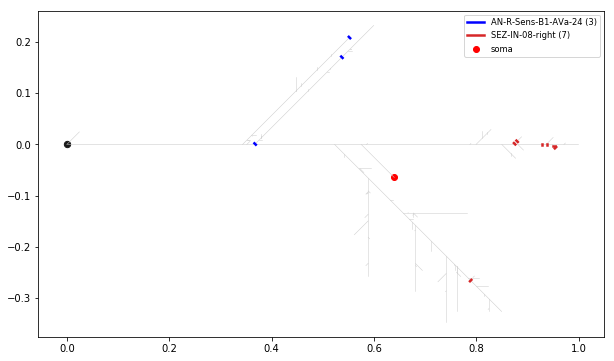

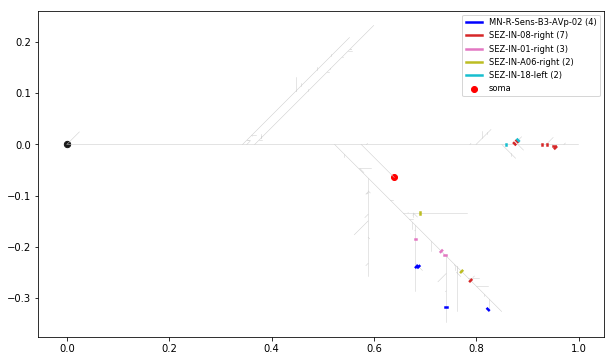

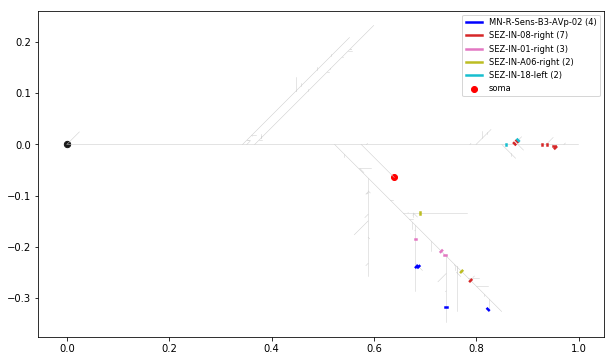

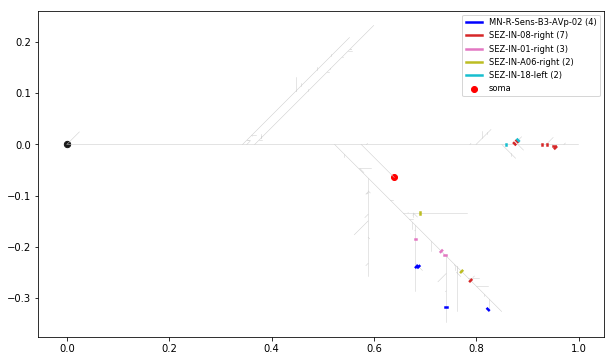

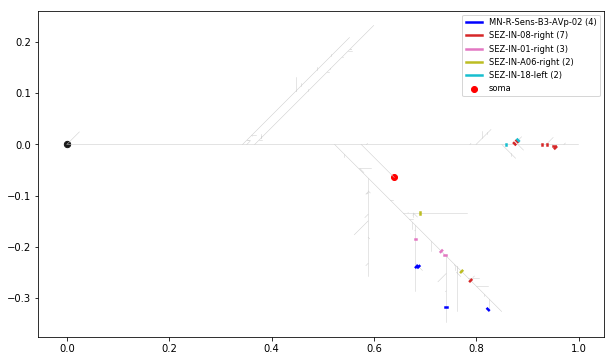

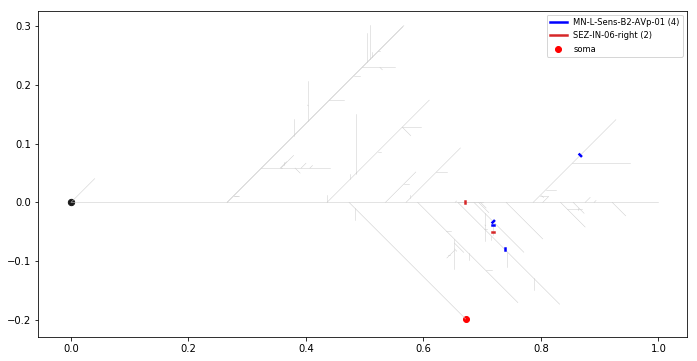

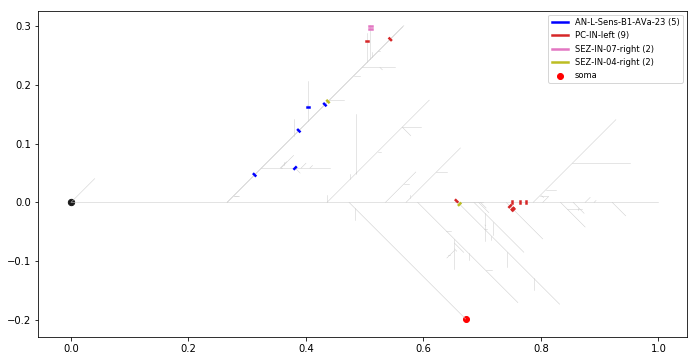

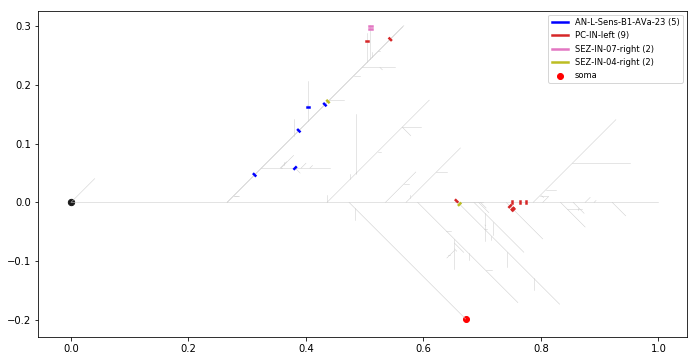

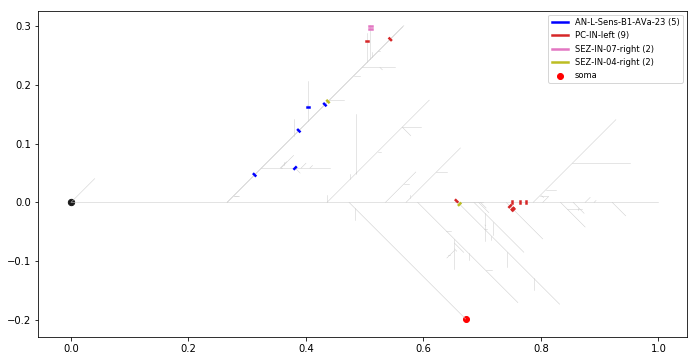

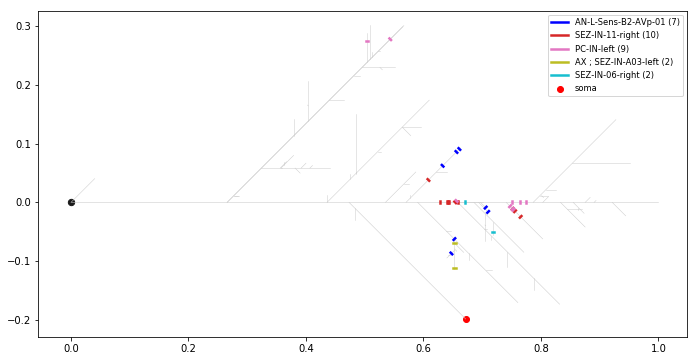

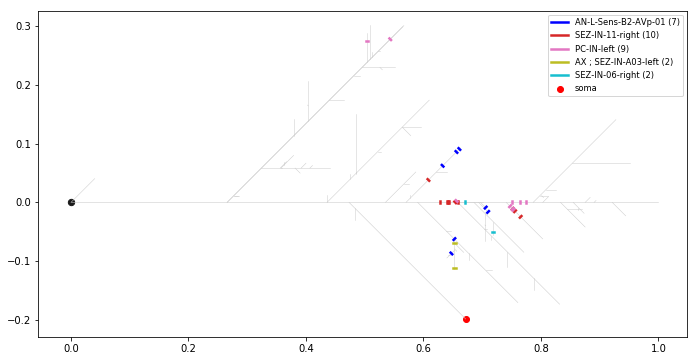

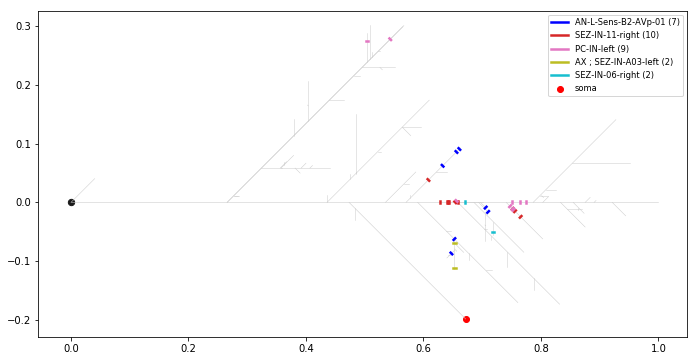

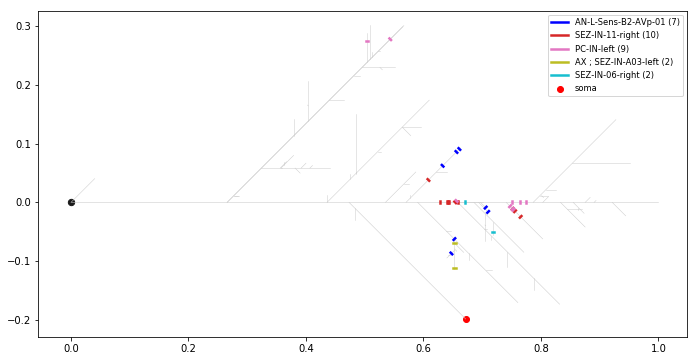

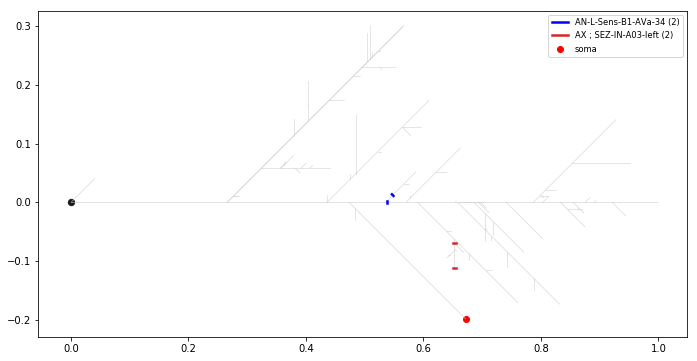

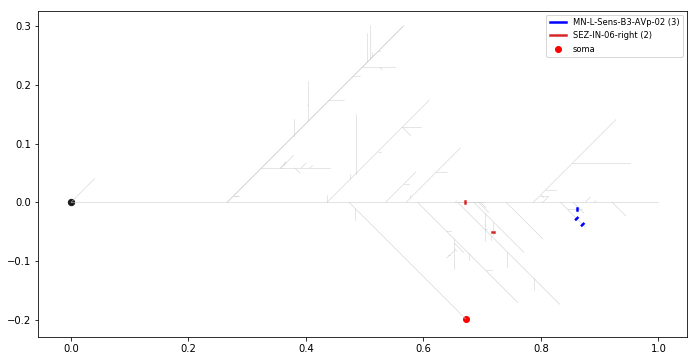

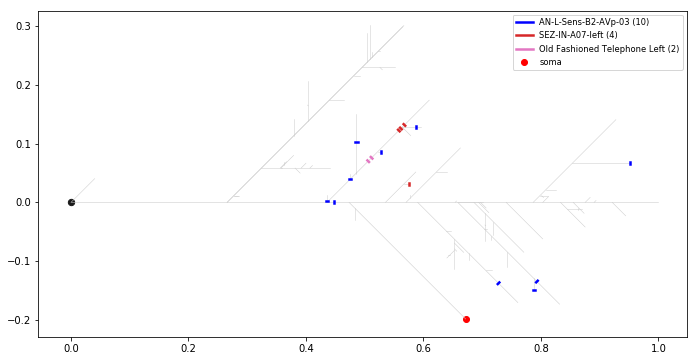

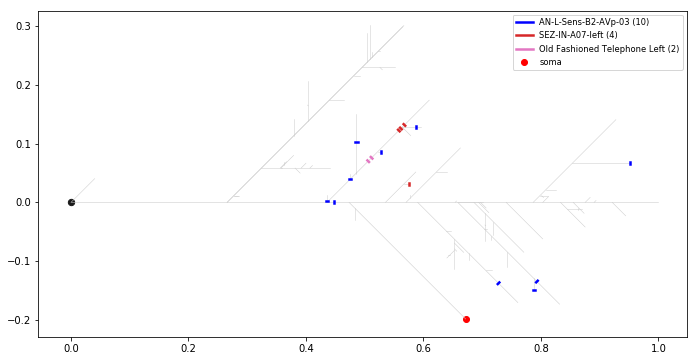

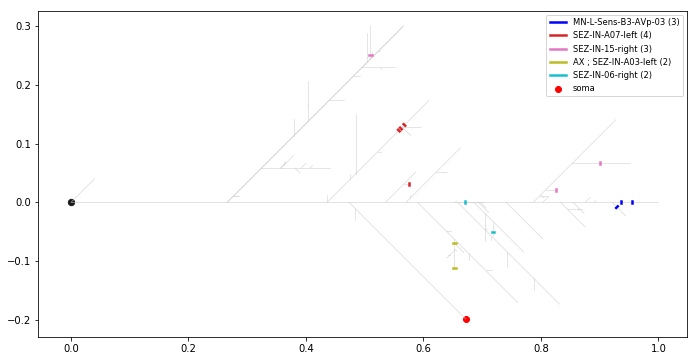

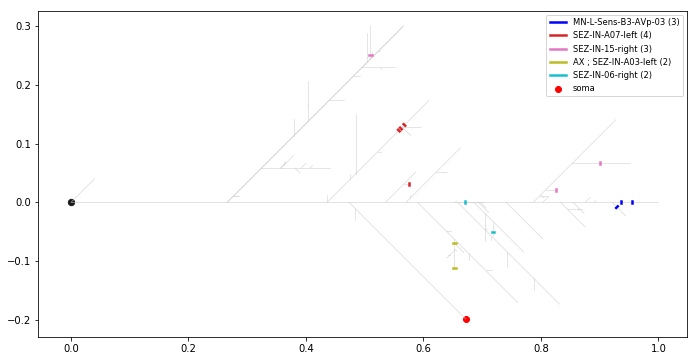

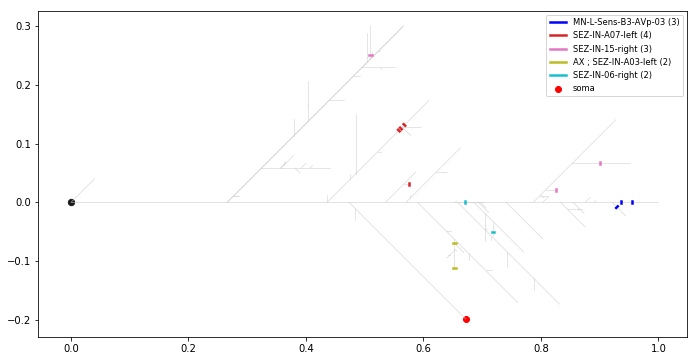

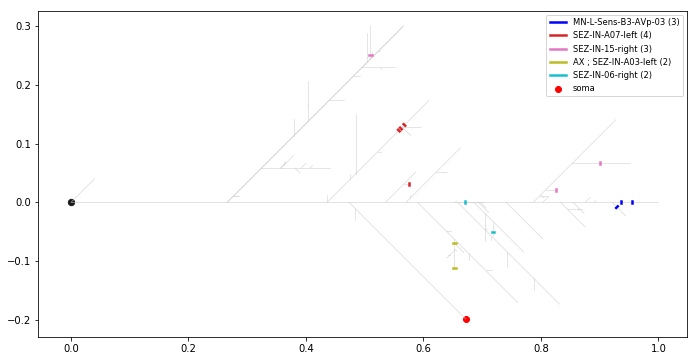

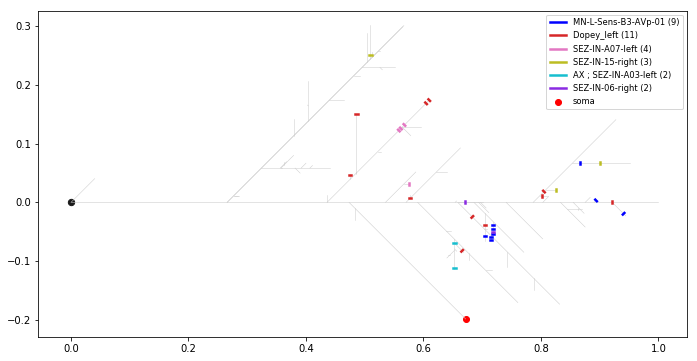

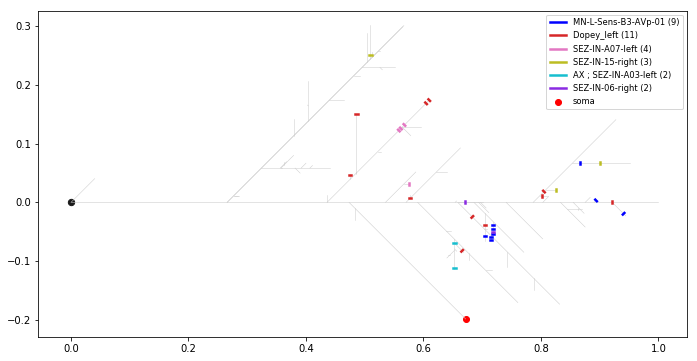

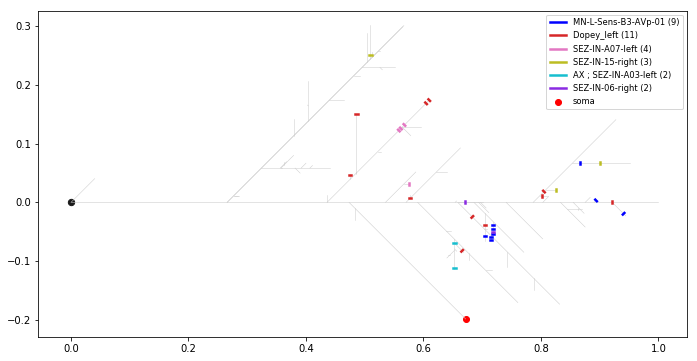

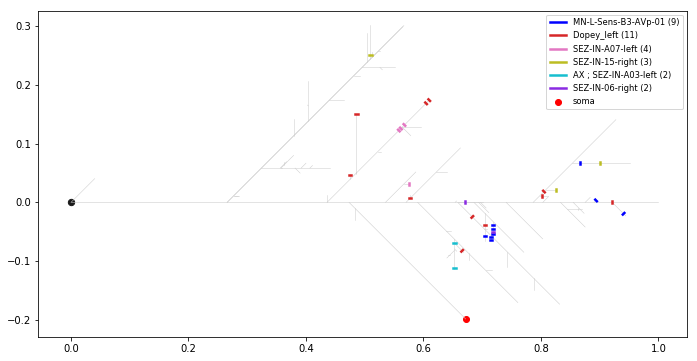

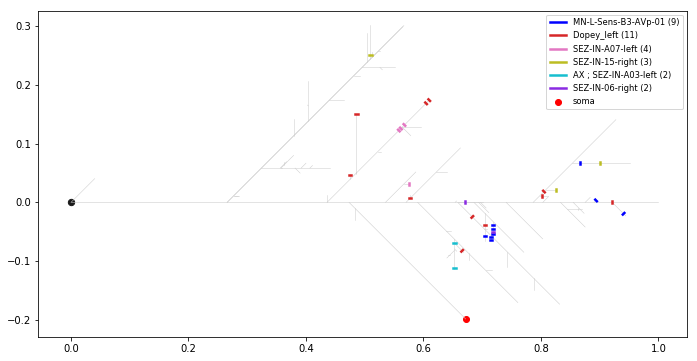

In [16]:
# all_dendrograms(se0p_sen,boi2)

HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 32.45it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 31.47it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 29.80it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 31.94it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 31.64it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 31.60it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 32.13it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 32.07it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 32.01it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 31.45it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 31.91it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 32.21it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 31.69it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:01<00:00, 31.75it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.28it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.32it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.40it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.66it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.60it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.48it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.99it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.76it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.62it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.95it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.67it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.93it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.65it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.70it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.70it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.51it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.87it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.52it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.95it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 23.05it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 23.12it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 23.27it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.94it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.99it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.98it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 23.03it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.94it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.97it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 22.95it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 23.01it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 72/72 [00:03<00:00, 23.11it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 32.91it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.42it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 32.41it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.57it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.62it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.50it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.54it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.56it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.83it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.45it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.75it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.54it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.55it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 32.47it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 21.29it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 18.20it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.50it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.13it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:06<00:00, 16.84it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 39.69it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.48it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.52it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.37it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 39.08it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 18.59it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 39.73it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.70it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.33it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 39.50it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.27it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.54it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 40.13it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 39.22it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.59it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.42it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.72it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 39.84it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.37it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.47it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 39.67it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.36it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.23it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 39.56it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.49it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 107/107 [00:05<00:00, 19.39it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.89it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.55it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.75it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 38.55it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 38.35it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.06it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.88it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.03it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.07it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.93it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.14it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.05it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.07it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.98it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.98it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.73it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 38.16it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=6, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.98it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.10it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.91it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 38.08it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.18it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 22.87it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.23it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=5, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 76/76 [00:03<00:00, 23.16it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 24.12it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 33.32it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 24.27it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 33.10it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 24.20it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 23.68it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 33.65it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 24.30it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 24.13it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 33.60it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 33.61it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 24.34it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=3, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 33.19it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 24.28it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 24.07it/s]


HBox(children=(IntProgress(value=0, description='Fetch neurons', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Make nrn', max=4, style=ProgressStyle(description_width='initial')), HTML(value='')))

Dendrogram: 100%|██████████| 54/54 [00:02<00:00, 24.38it/s]


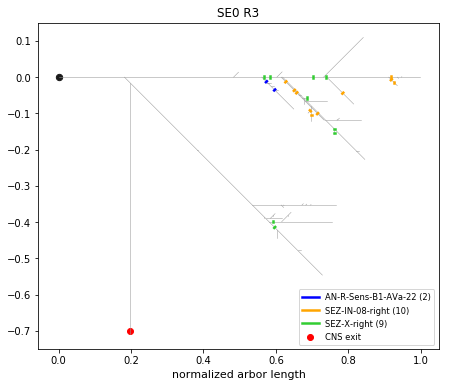

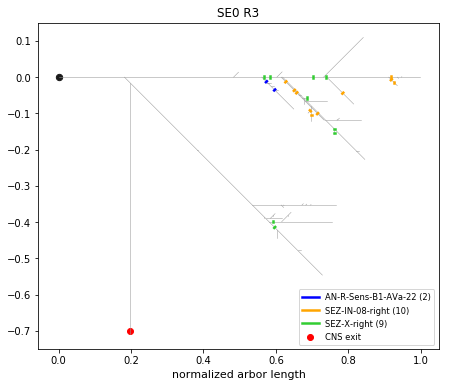

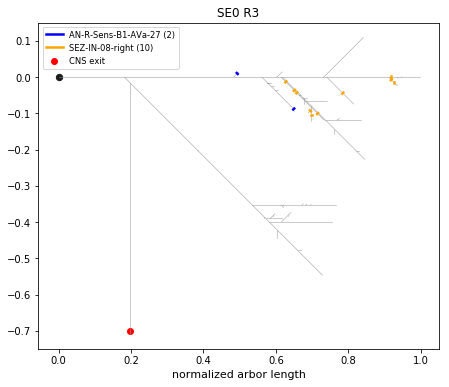

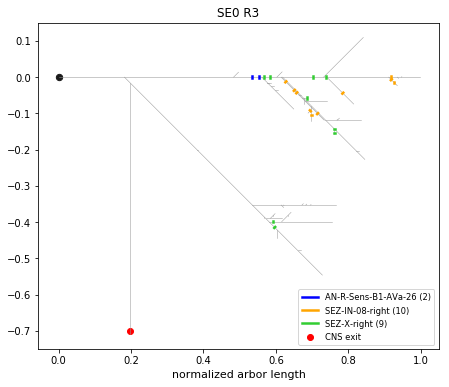

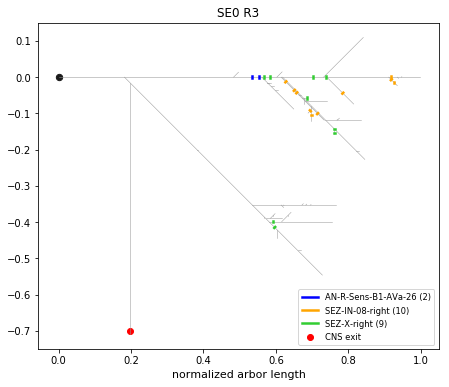

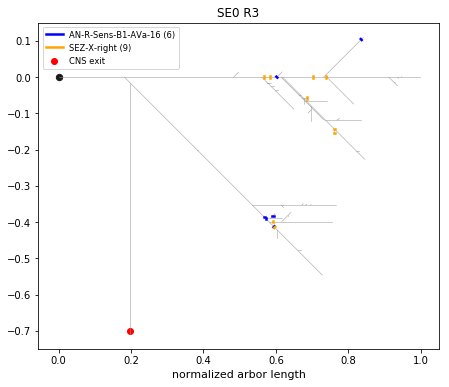

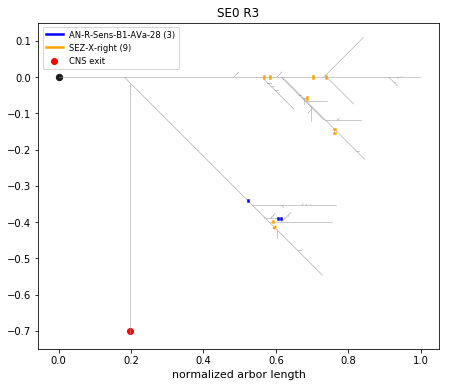

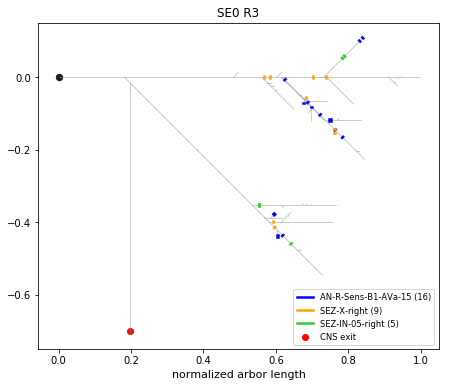

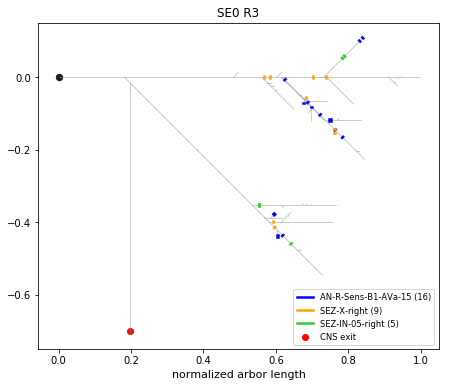

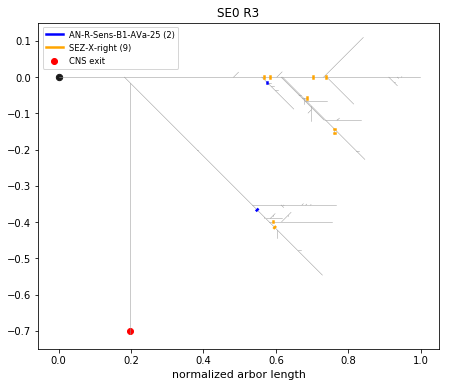

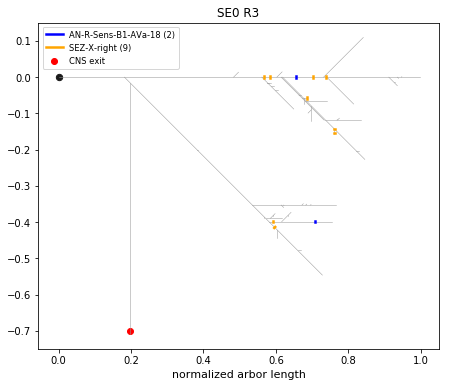

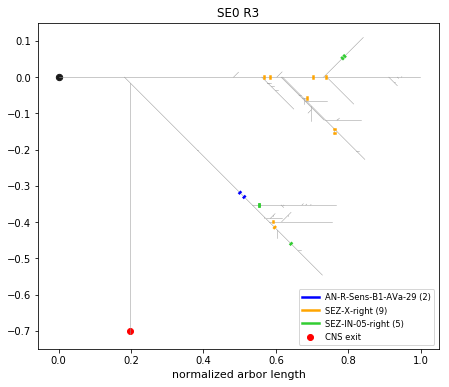

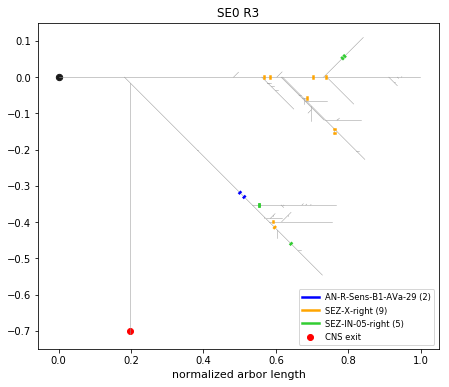

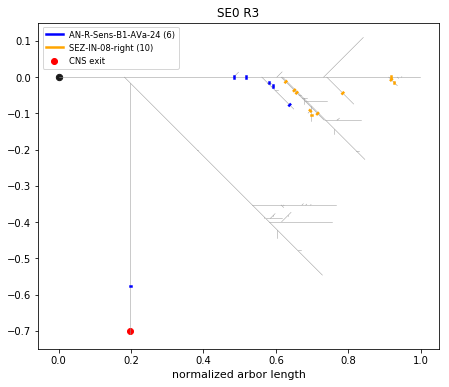

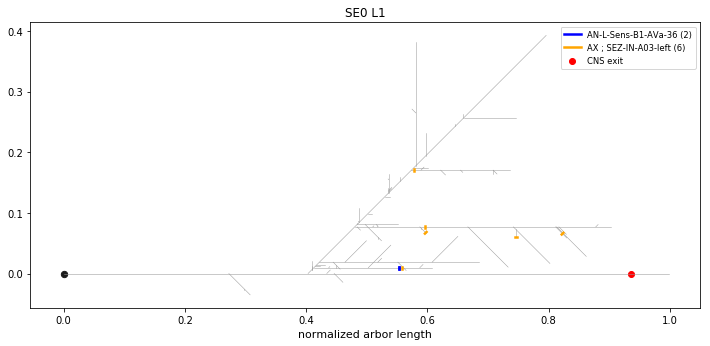

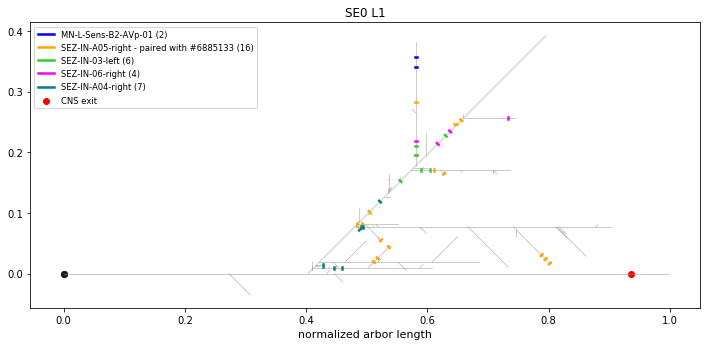

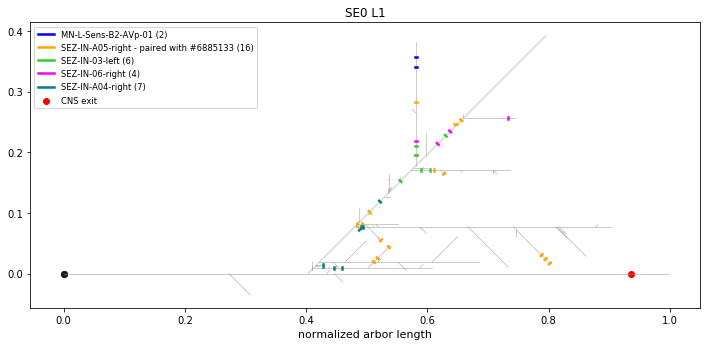

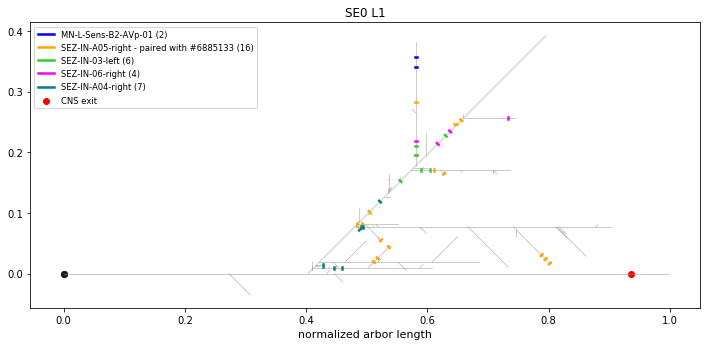

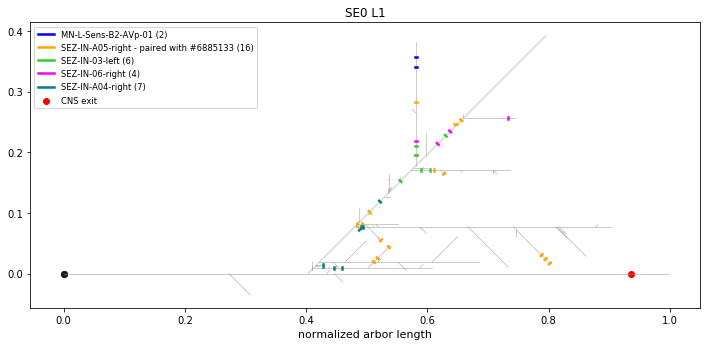

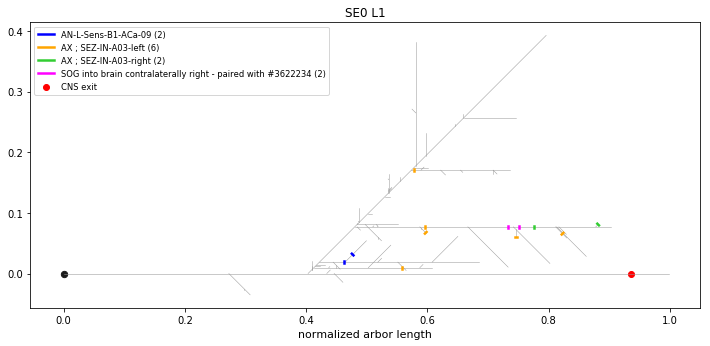

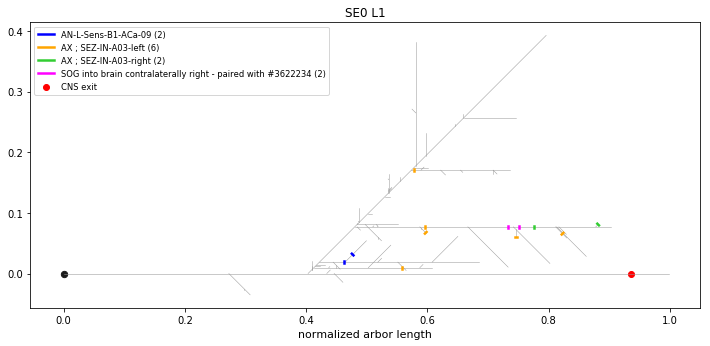

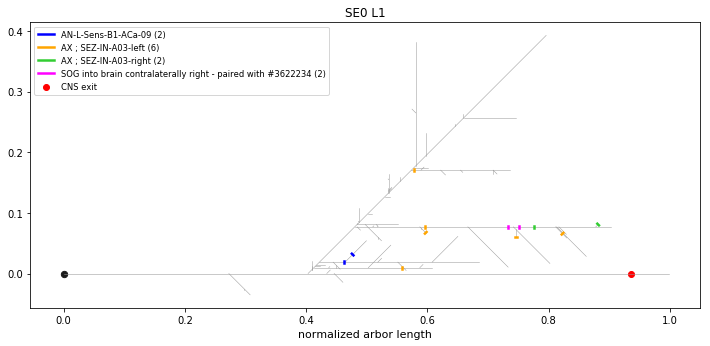

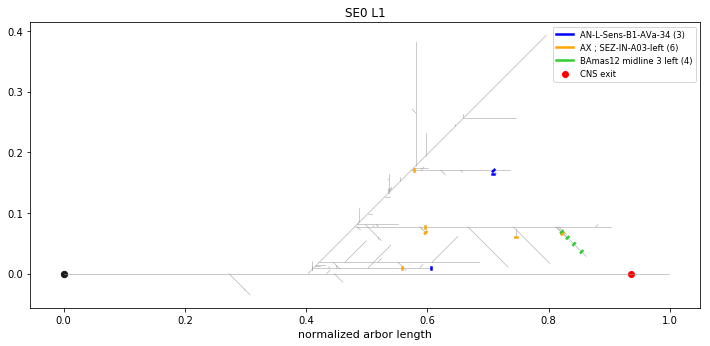

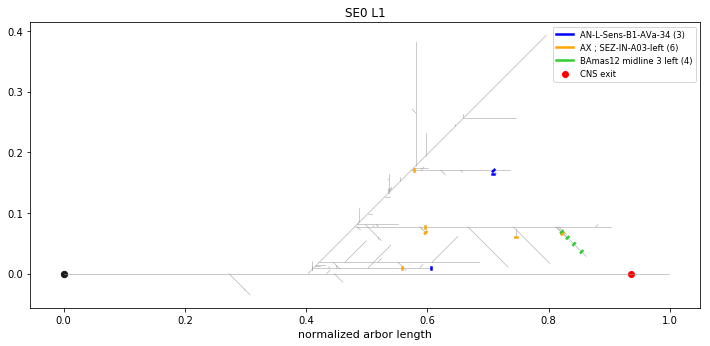

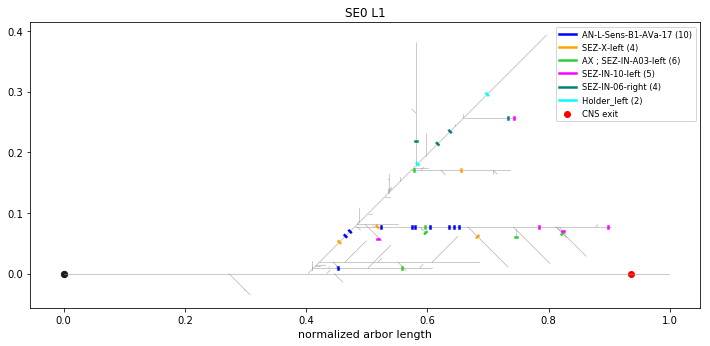

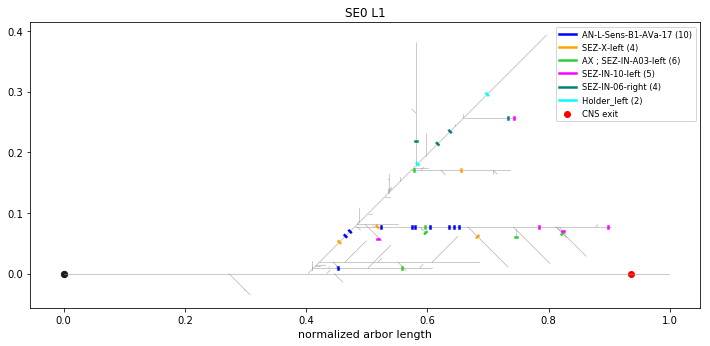

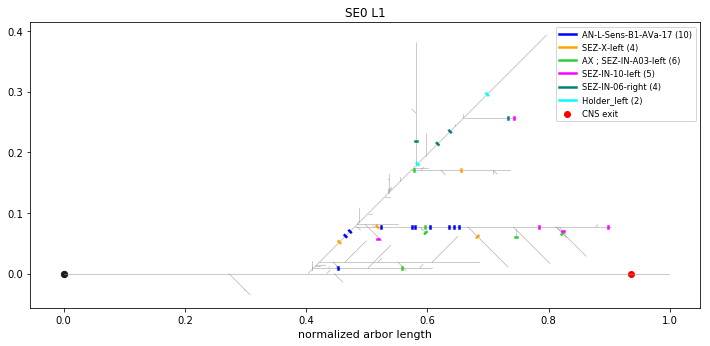

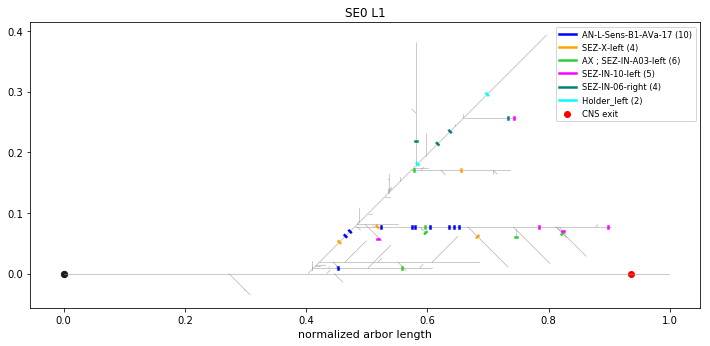

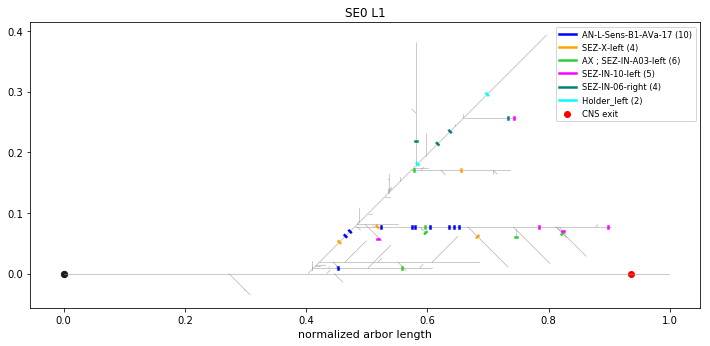

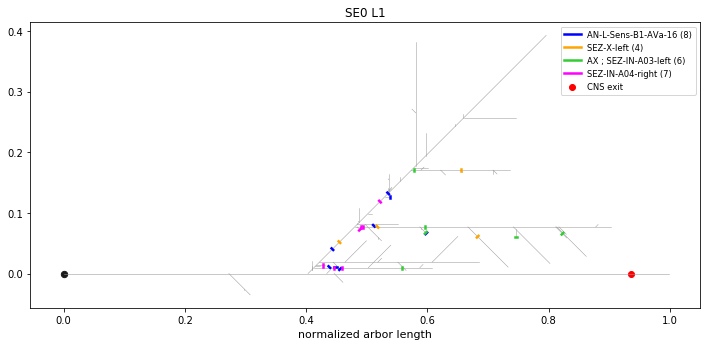

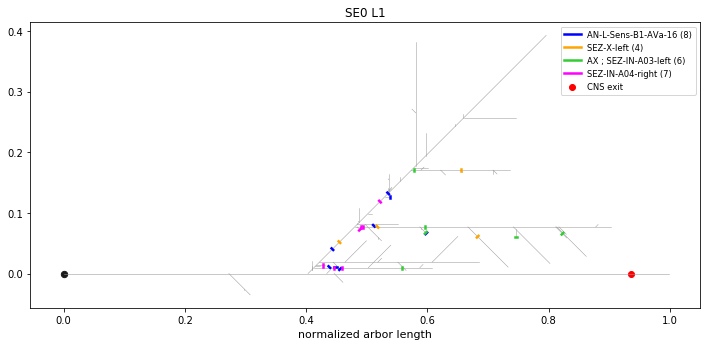

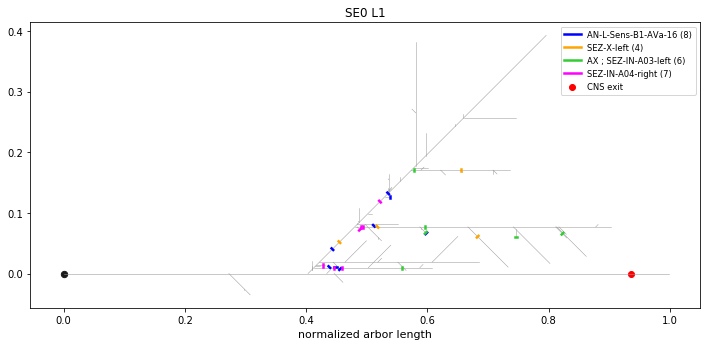

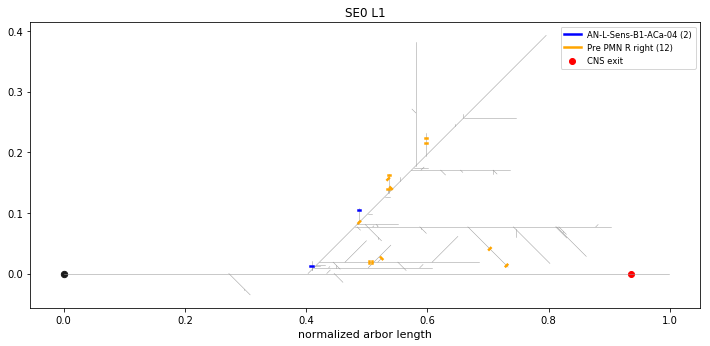

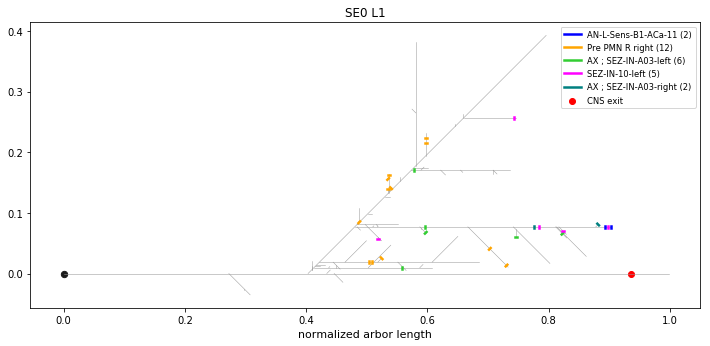

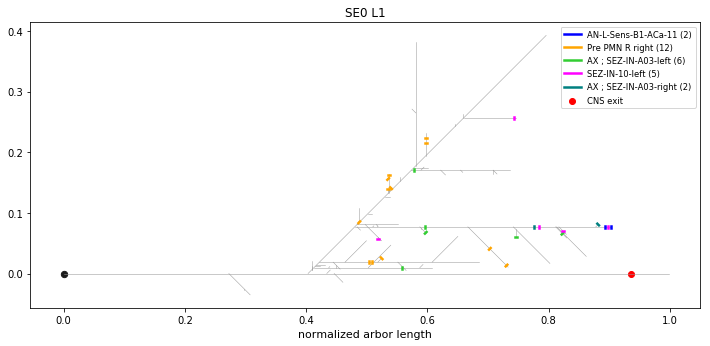

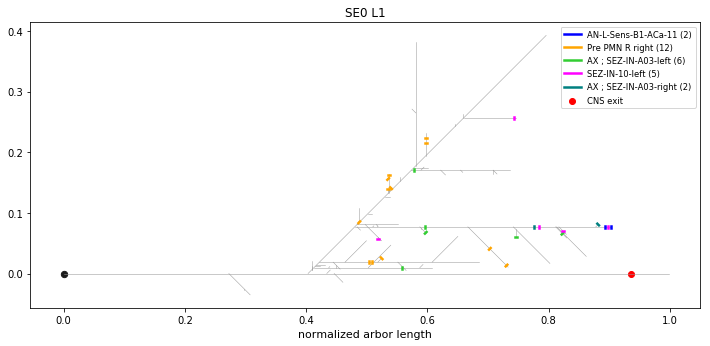

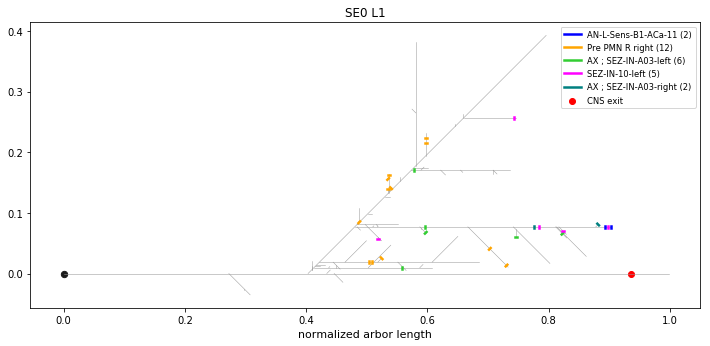

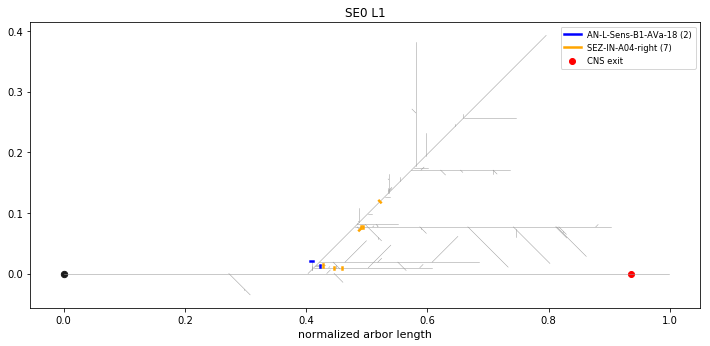

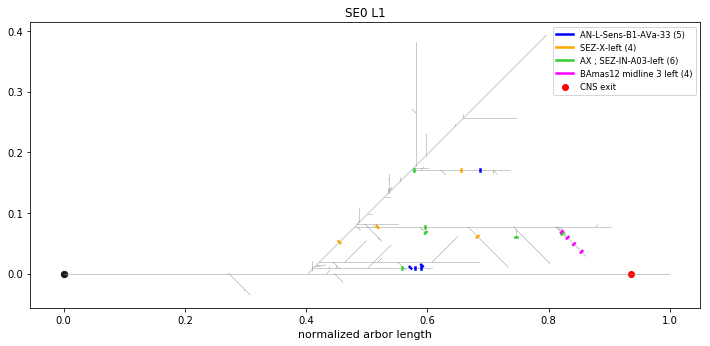

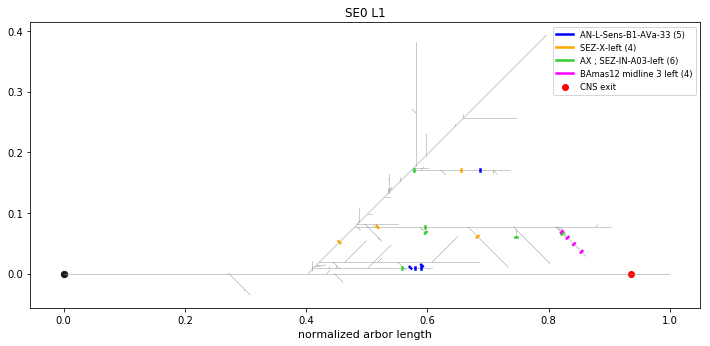

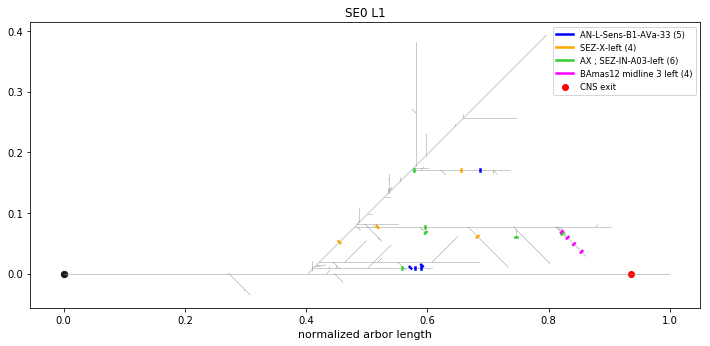

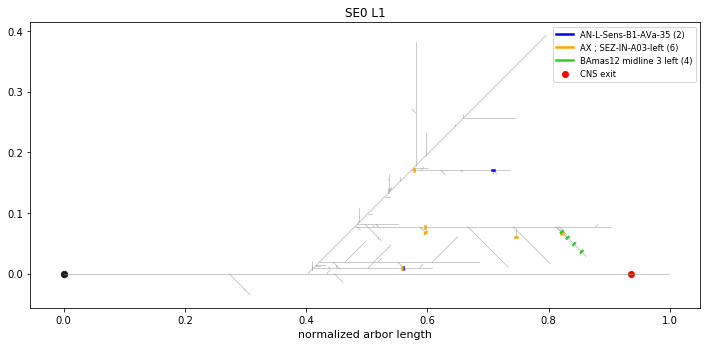

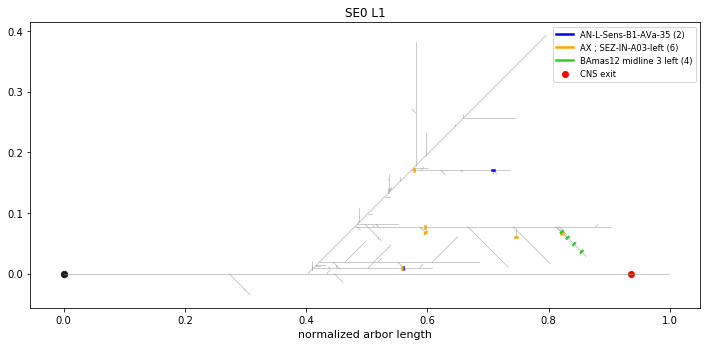

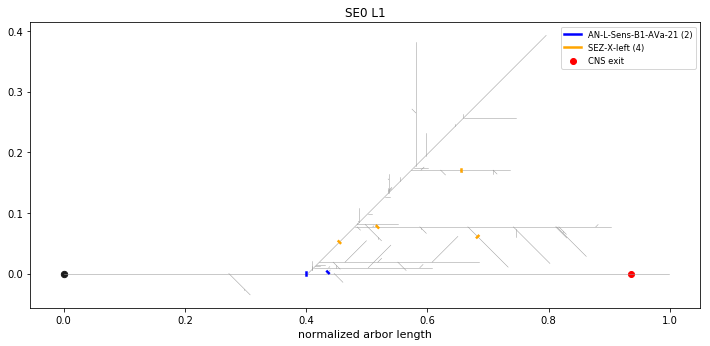

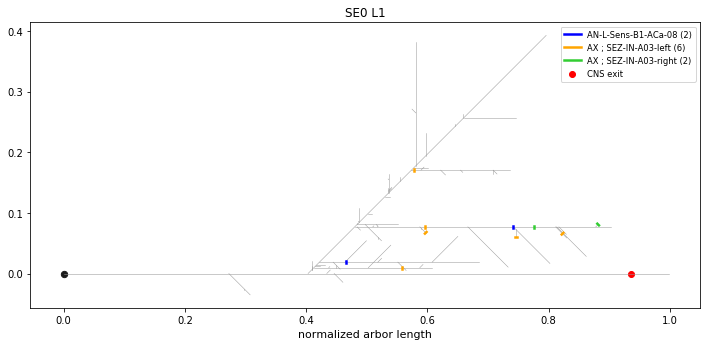

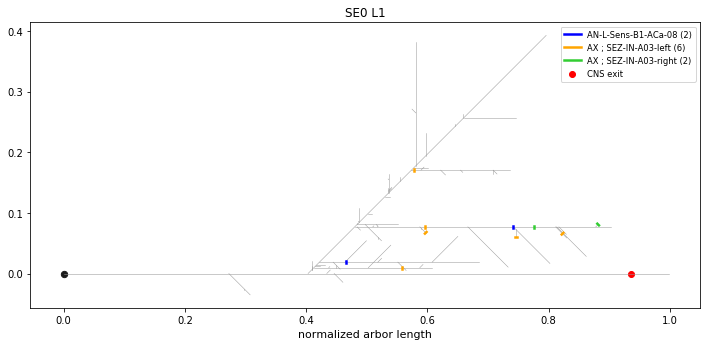

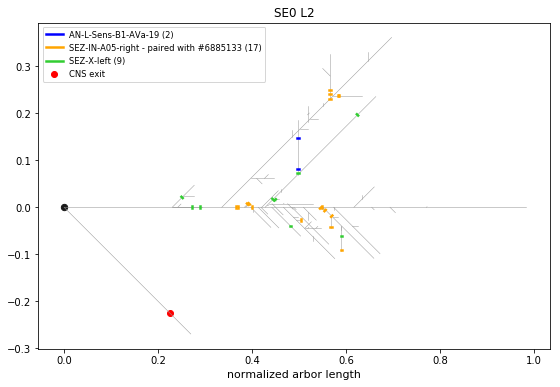

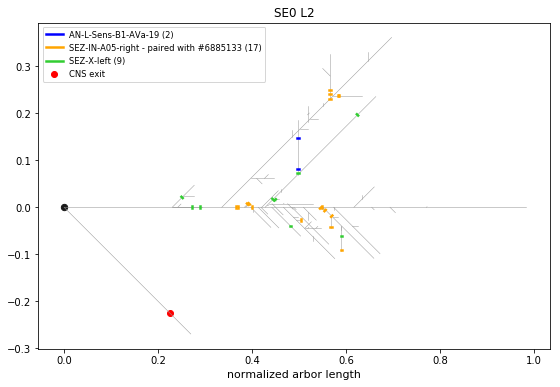

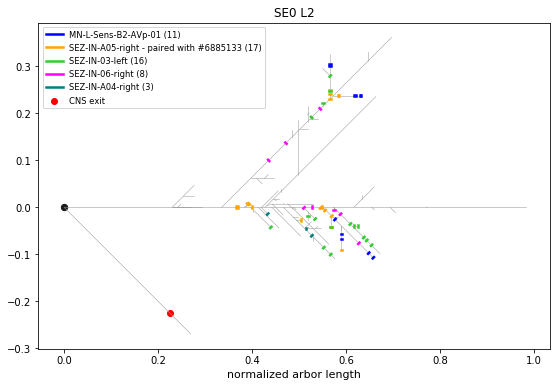

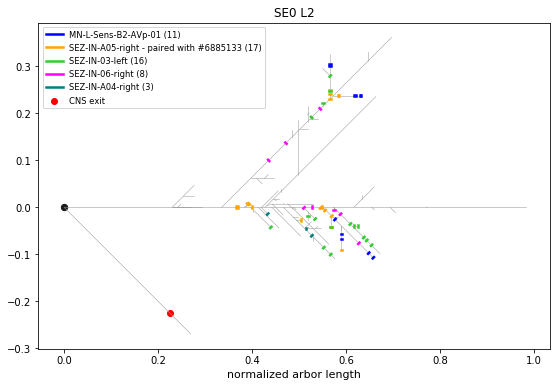

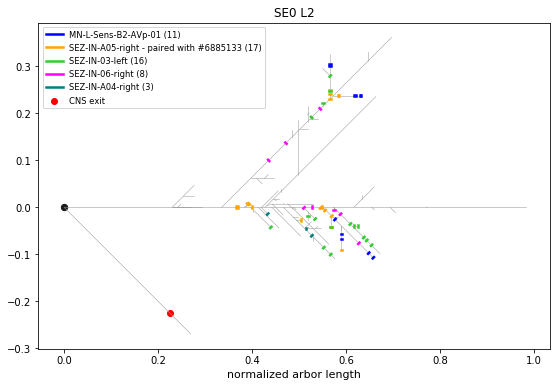

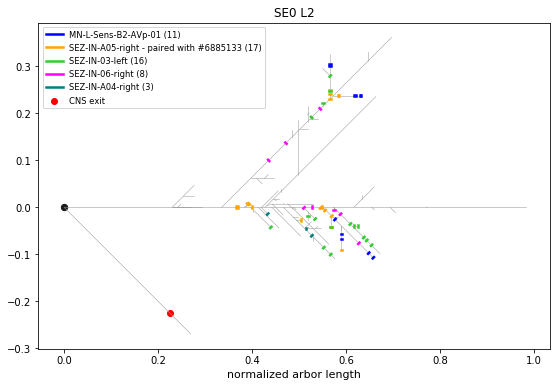

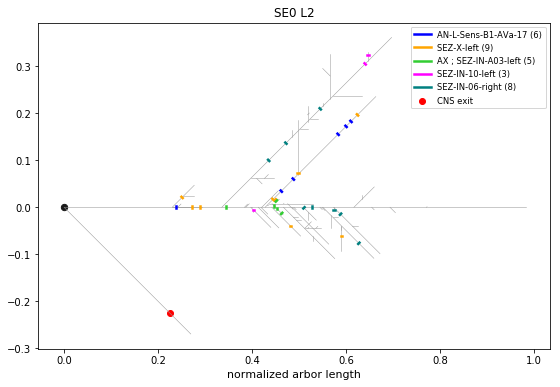

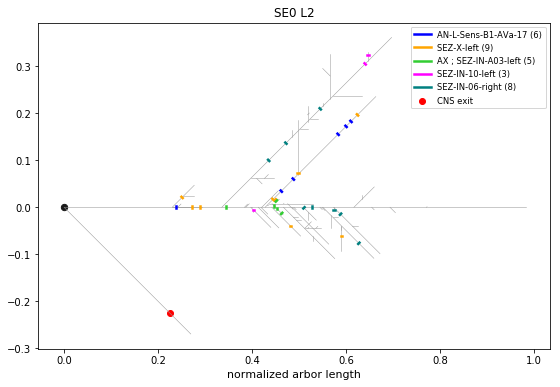

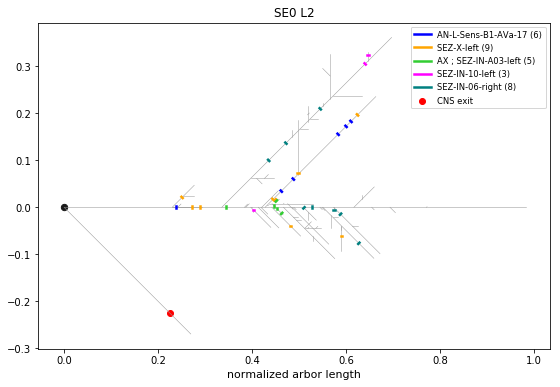

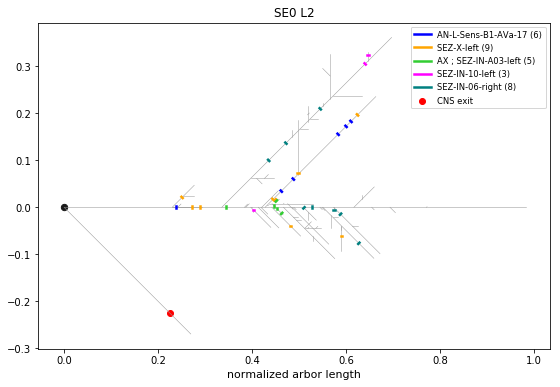

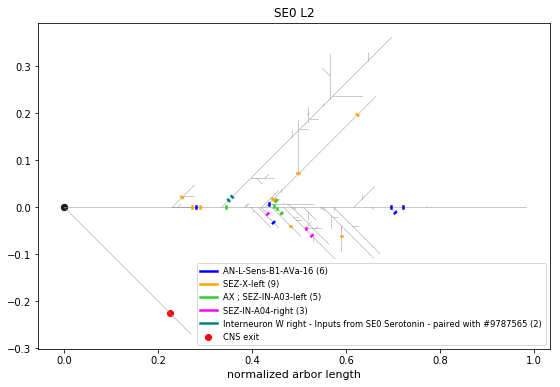

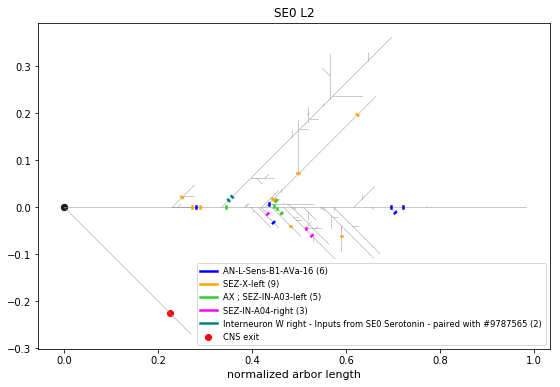

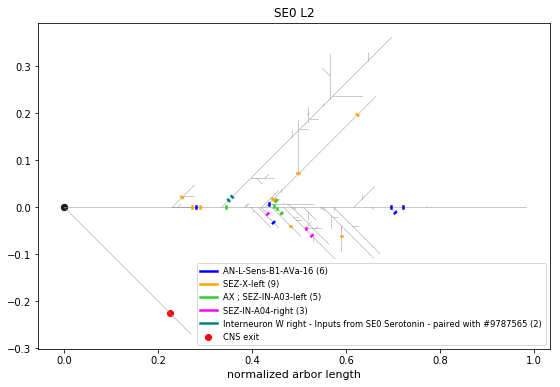

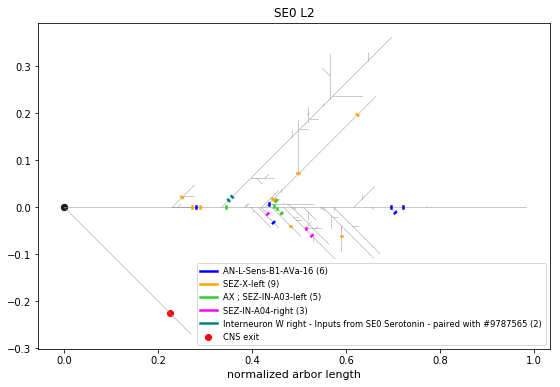

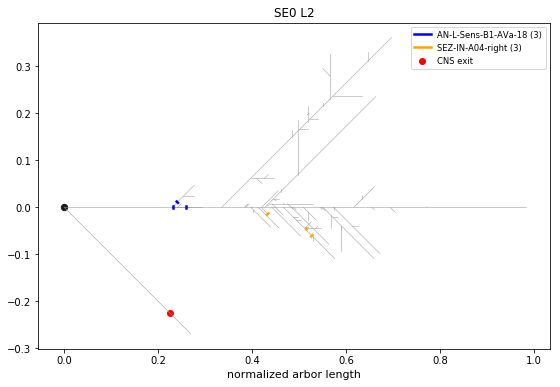

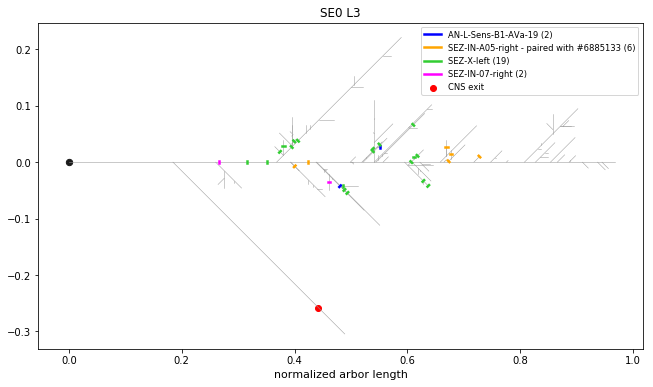

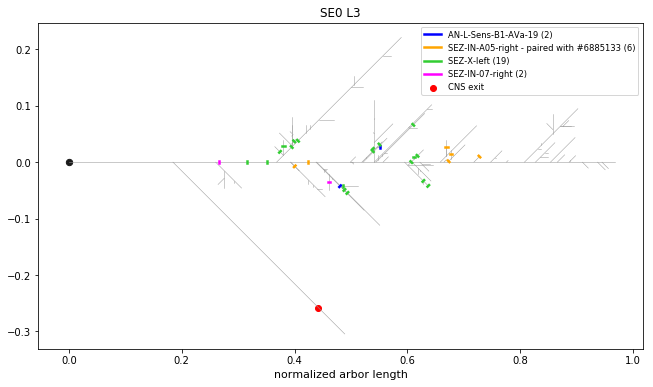

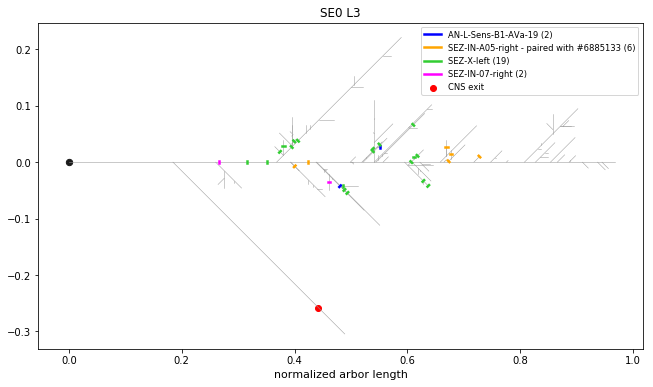

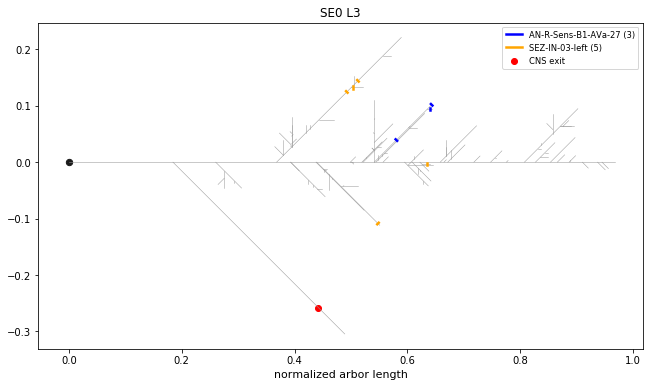

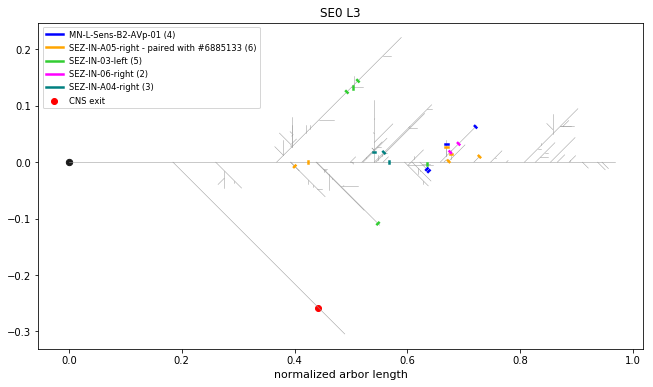

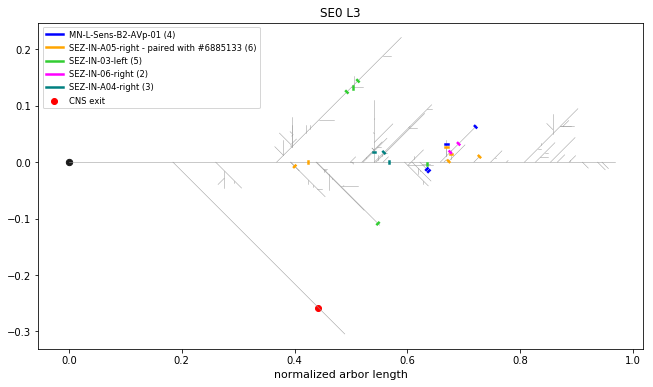

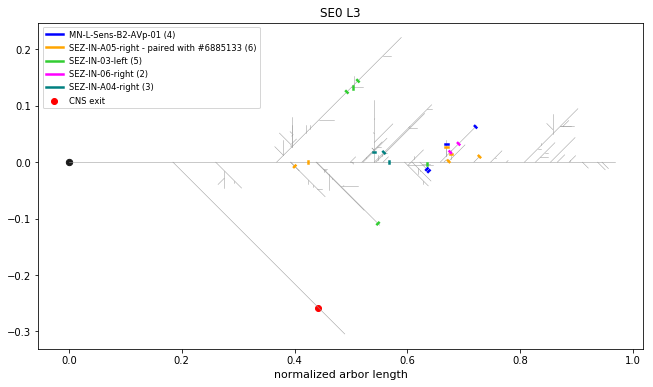

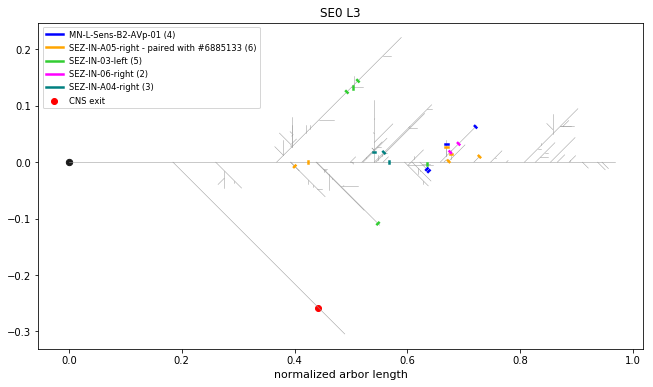

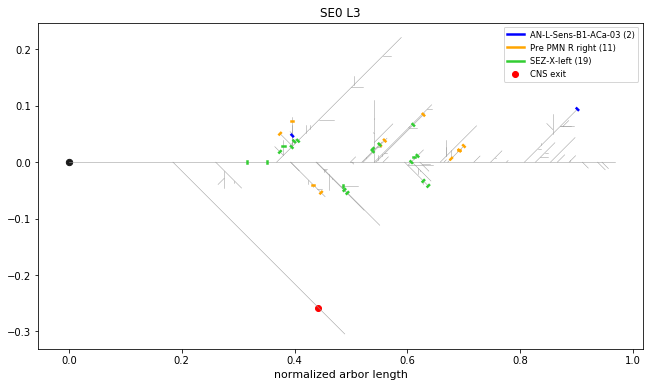

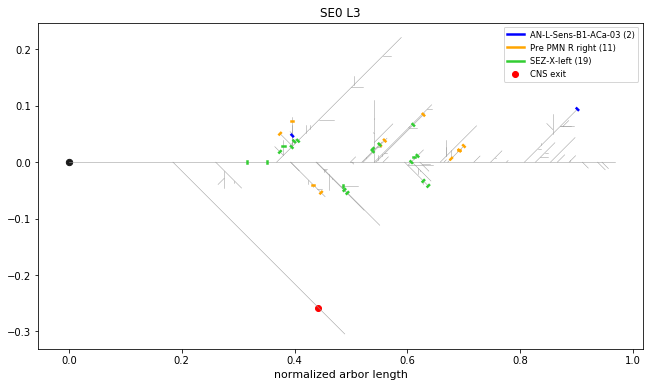

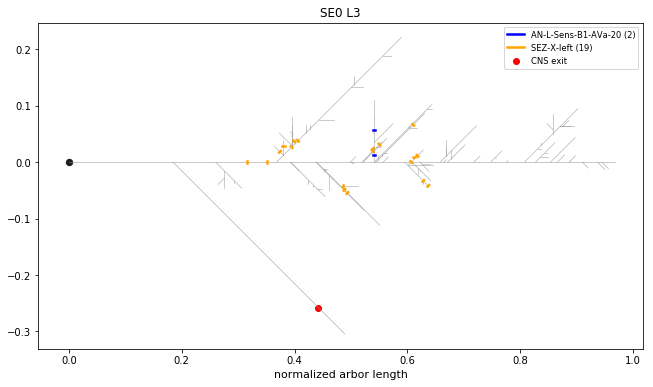

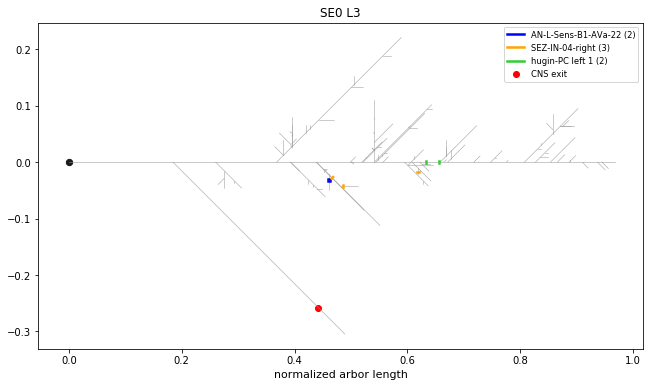

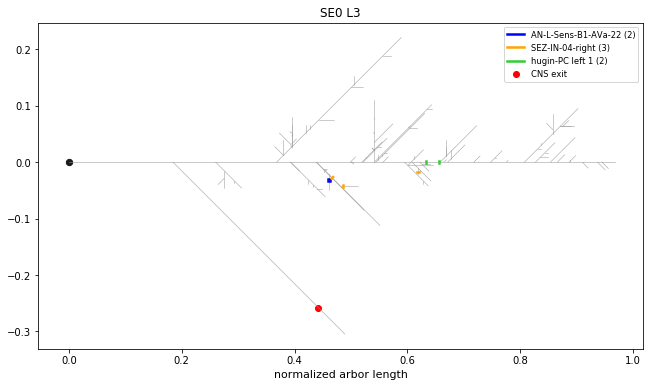

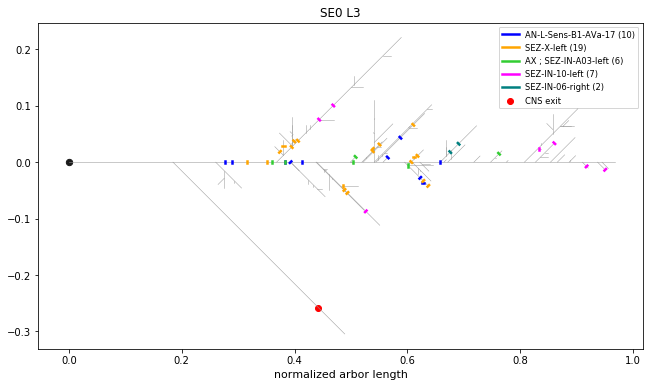

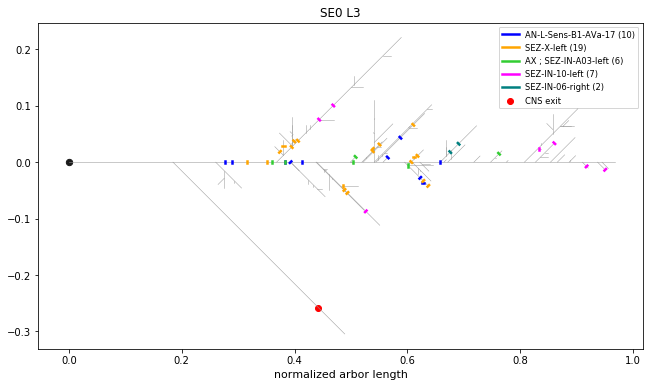

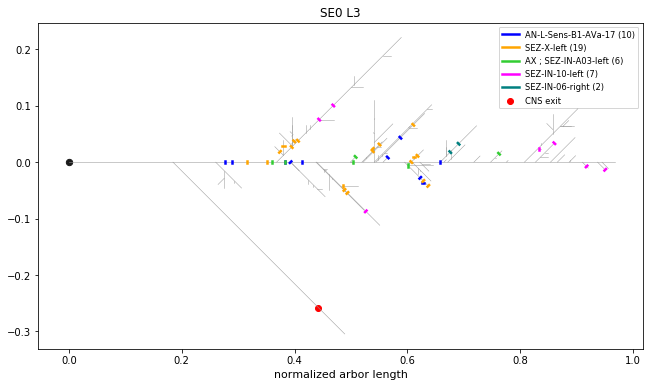

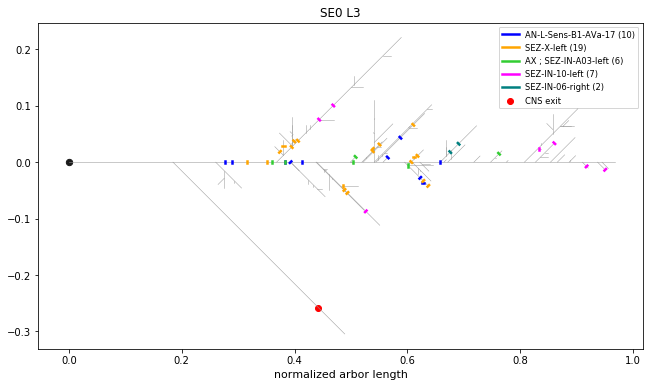

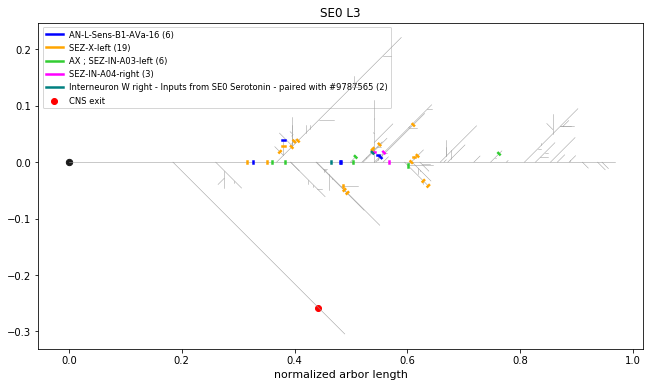

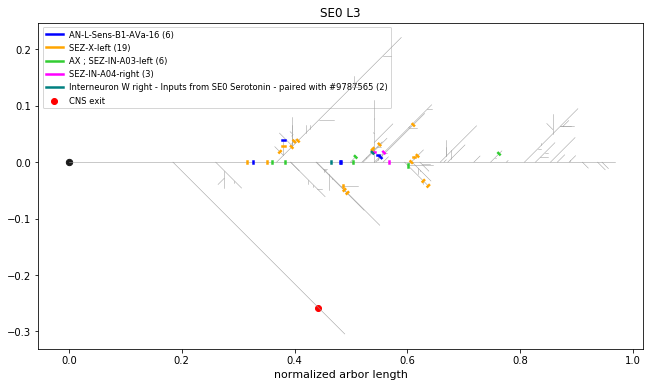

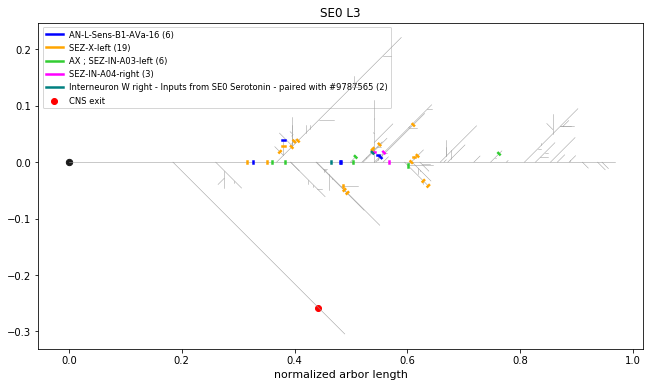

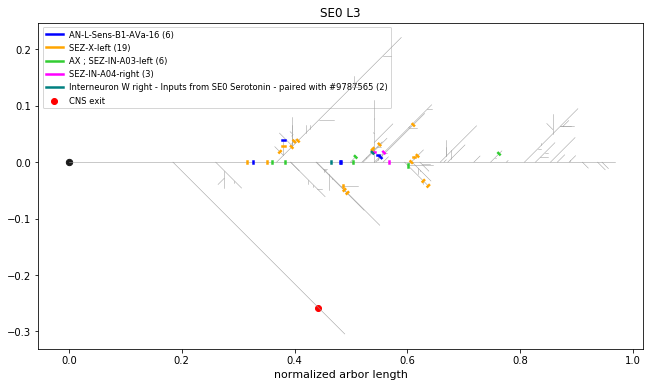

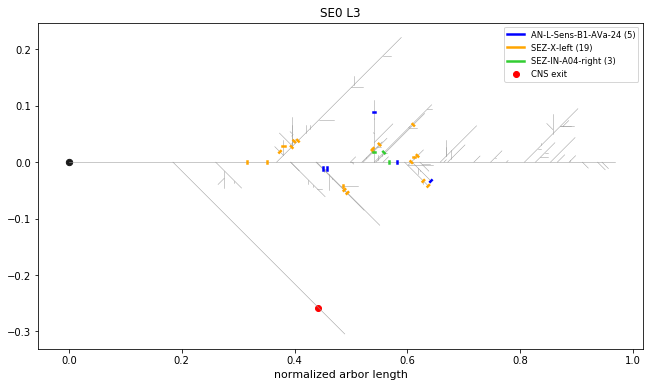

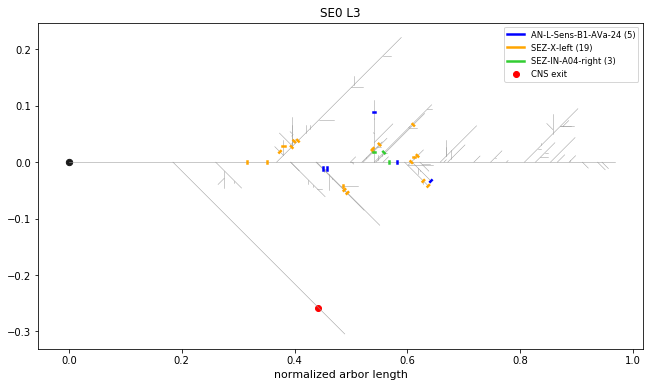

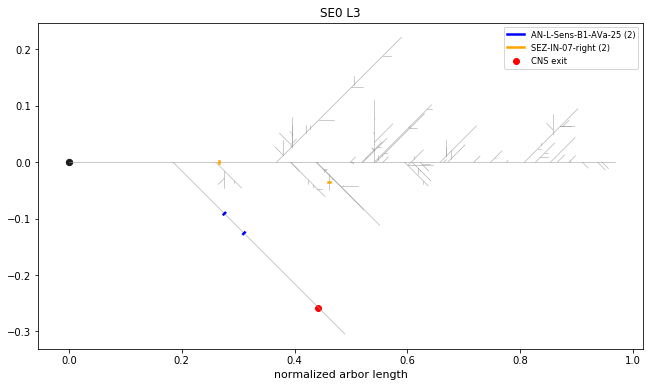

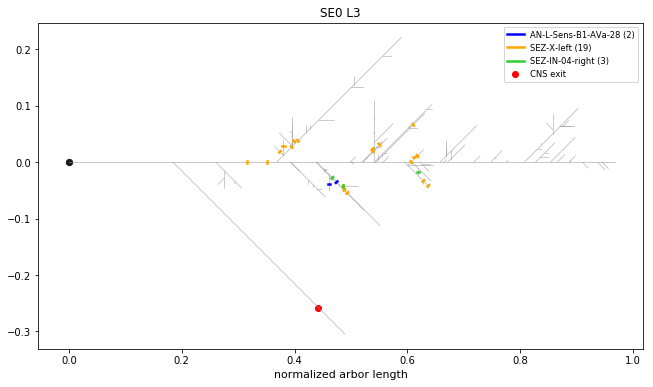

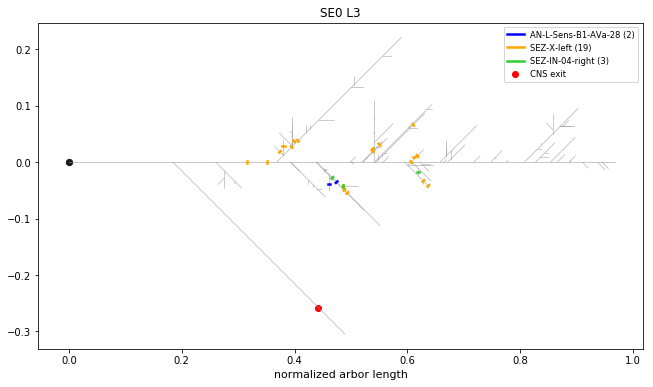

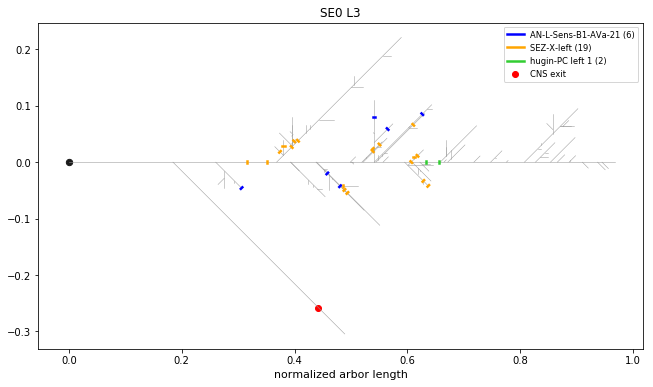

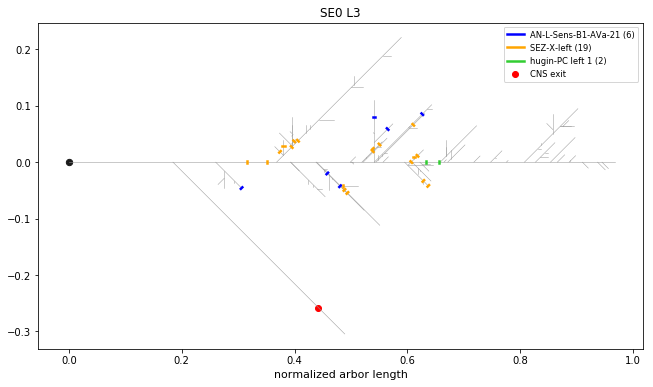

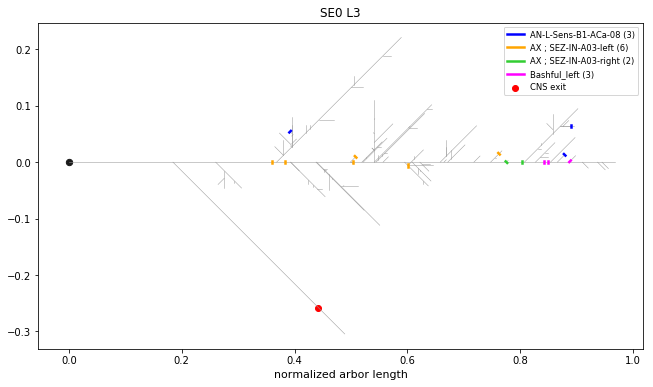

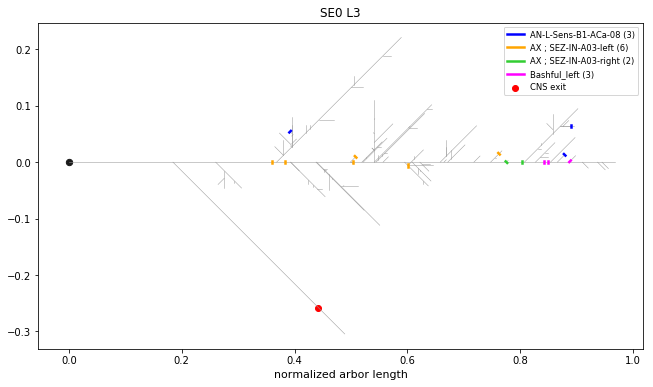

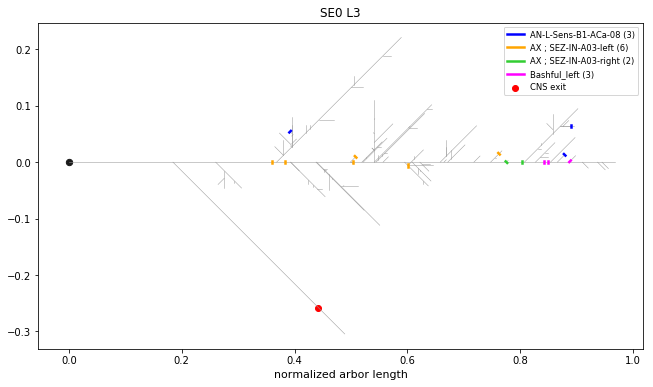

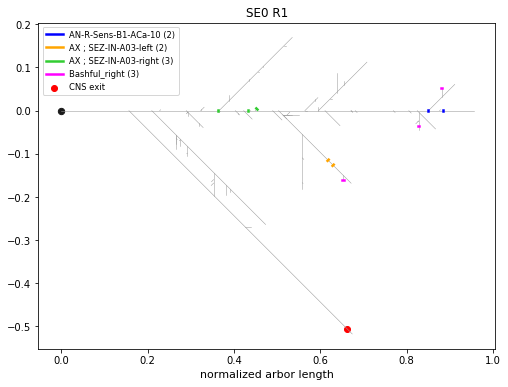

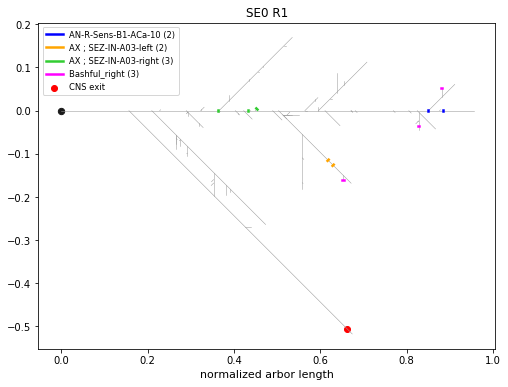

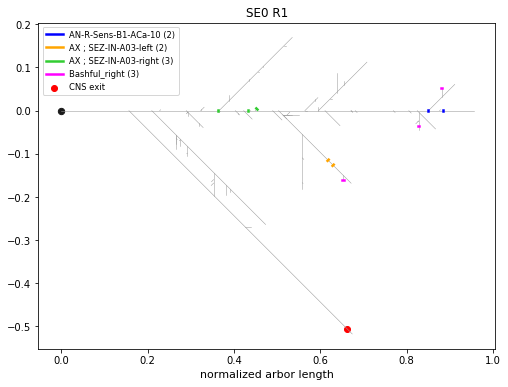

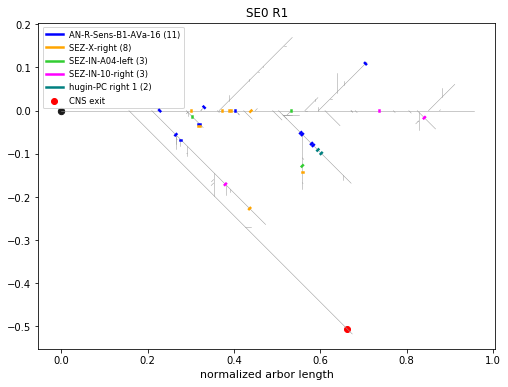

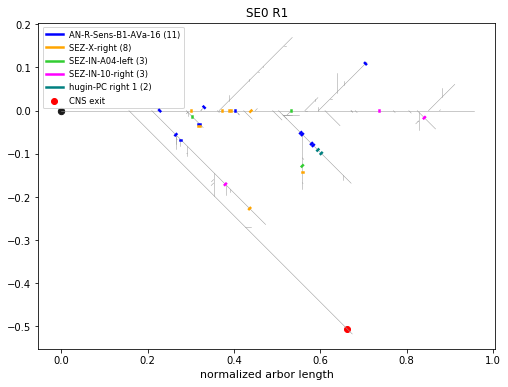

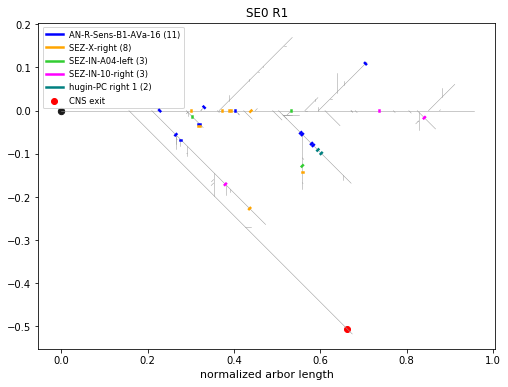

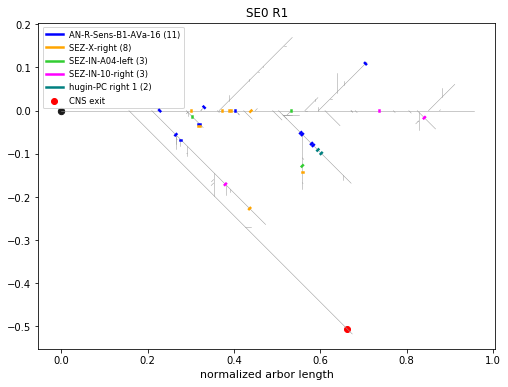

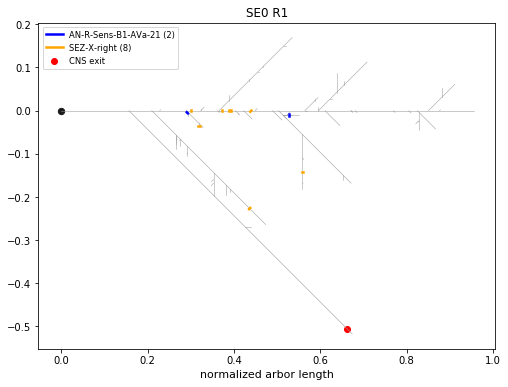

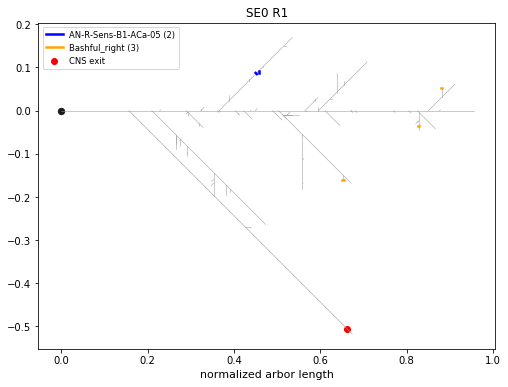

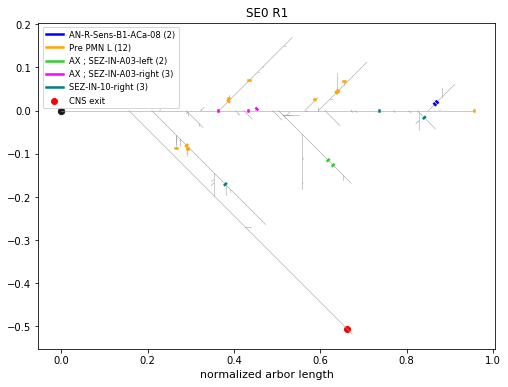

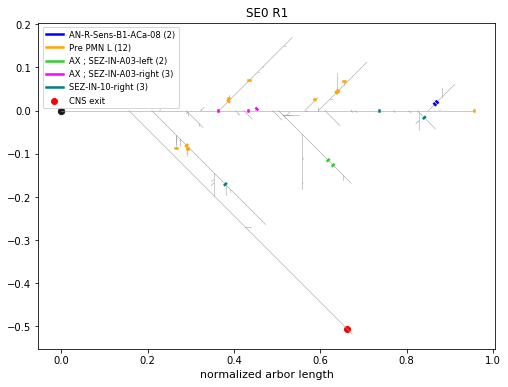

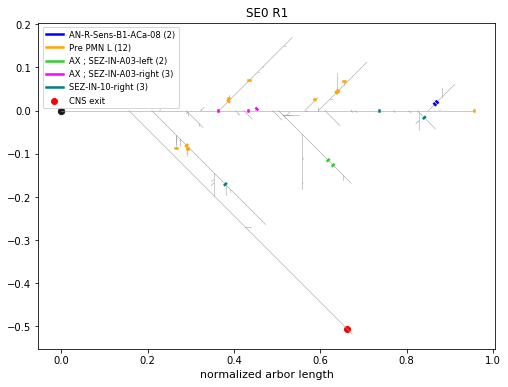

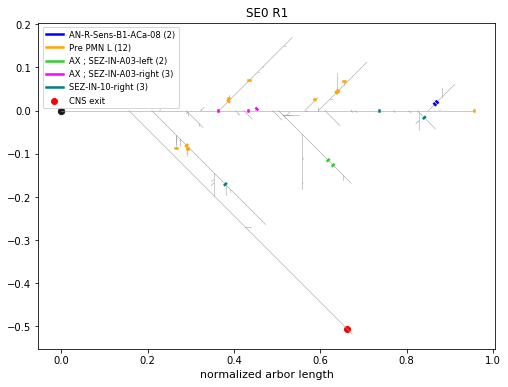

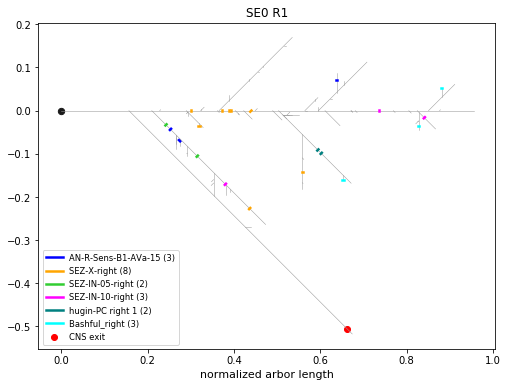

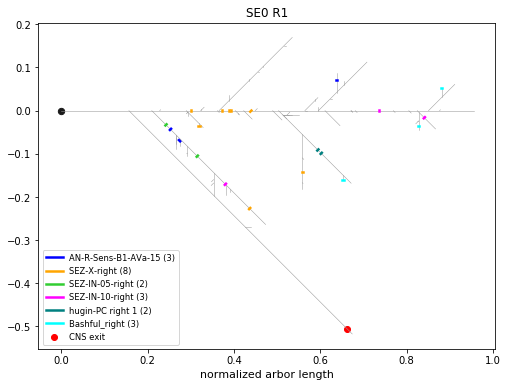

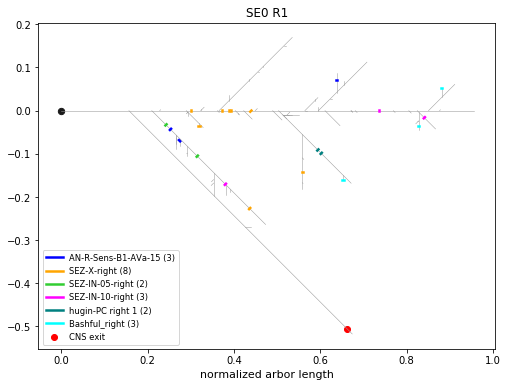

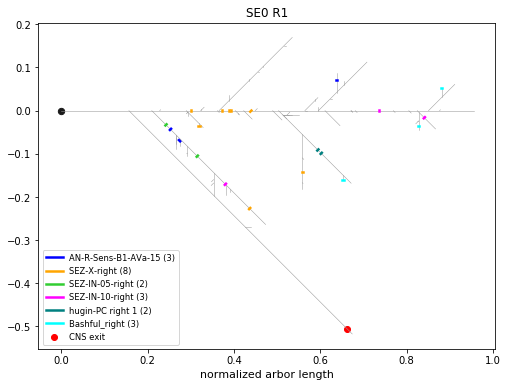

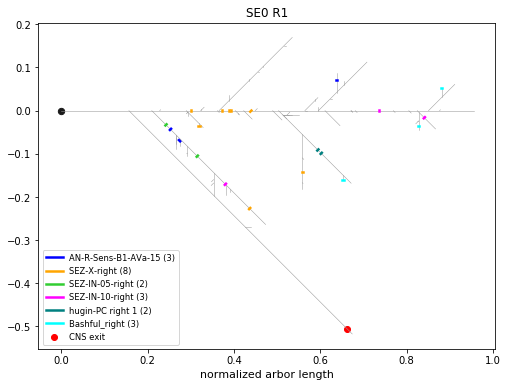

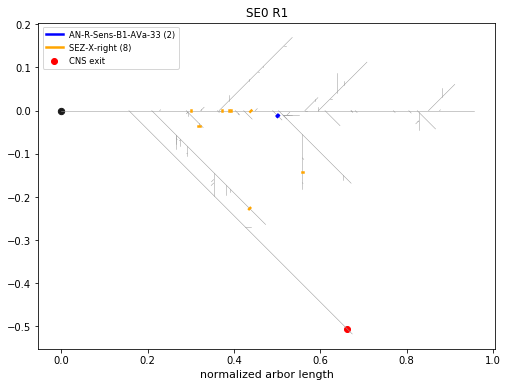

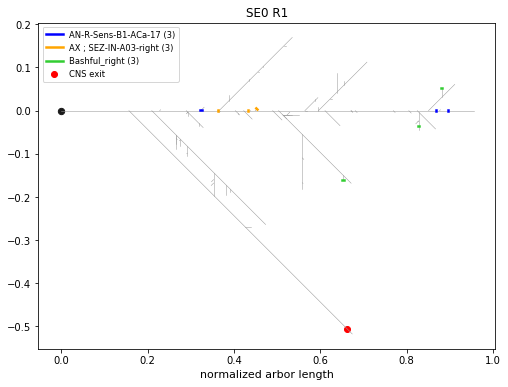

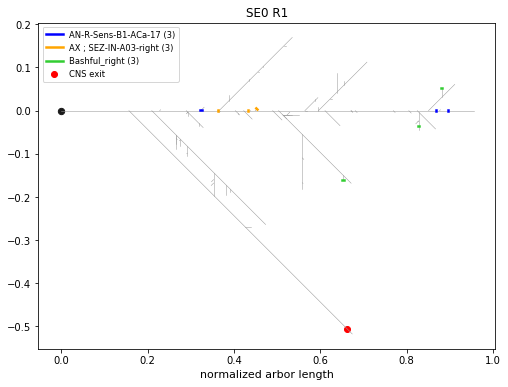

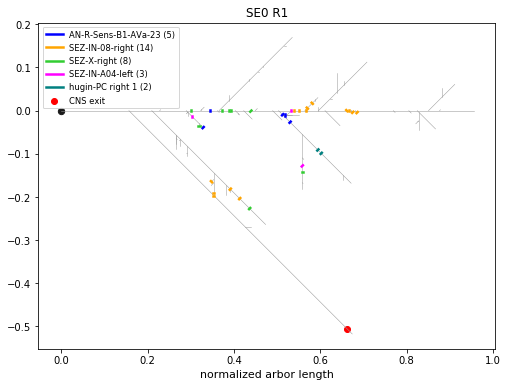

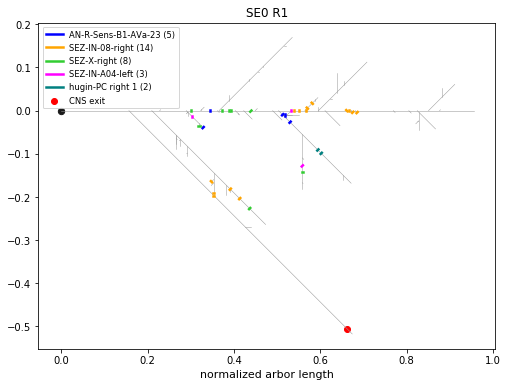

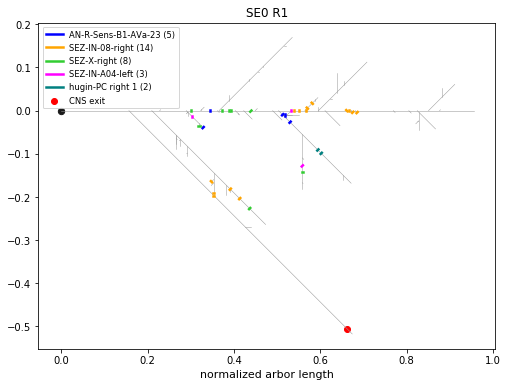

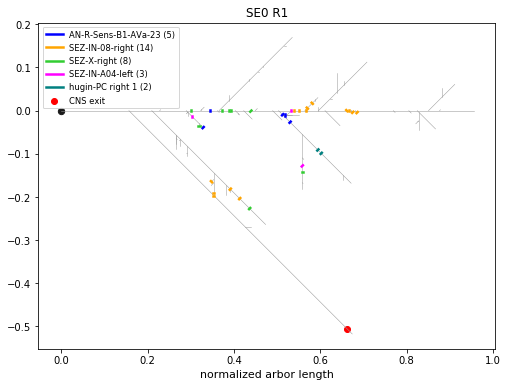

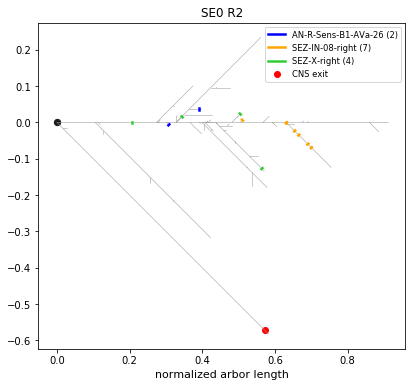

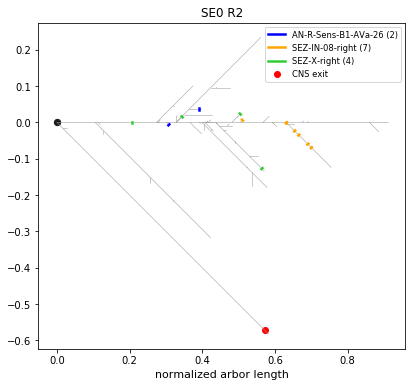

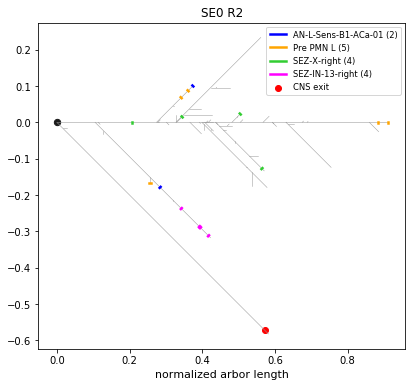

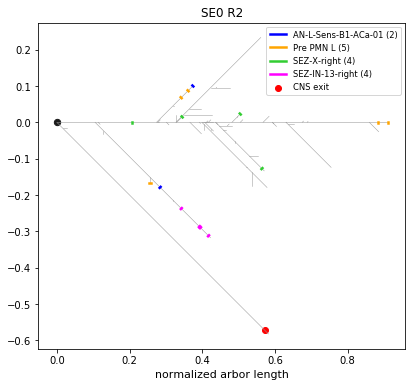

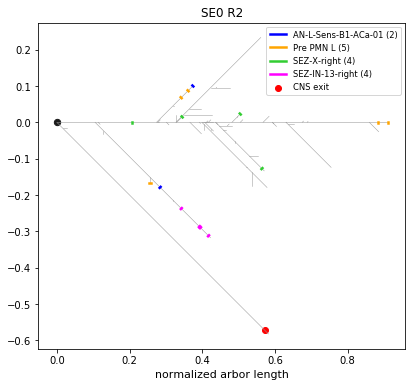

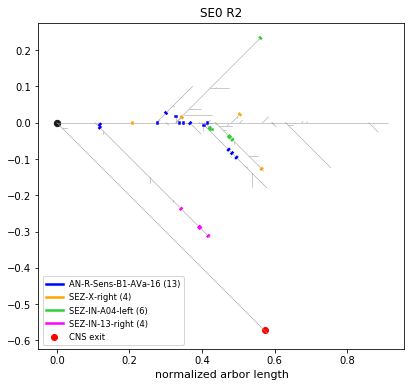

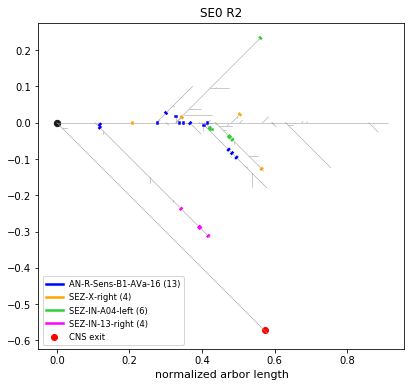

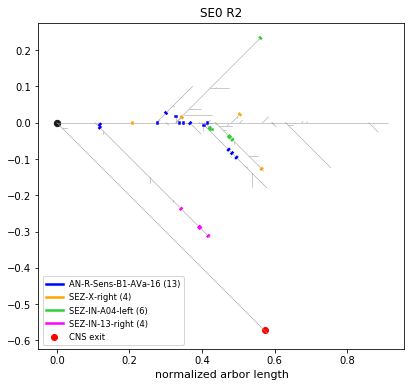

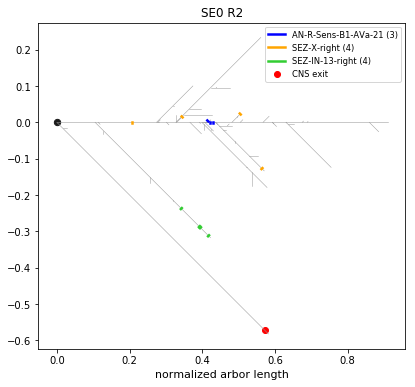

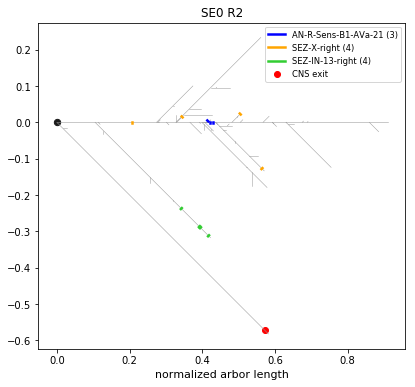

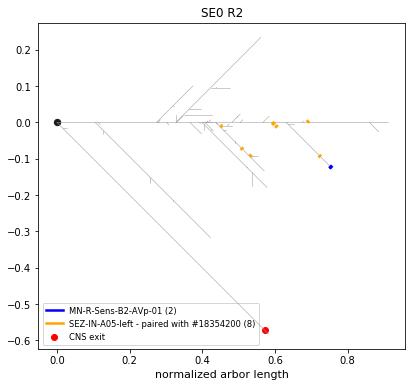

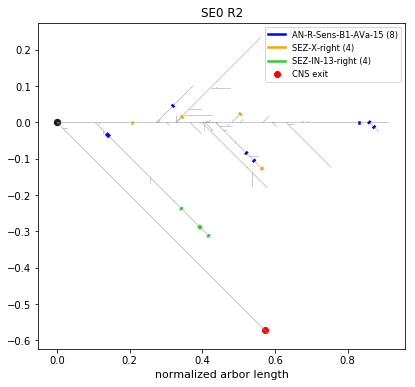

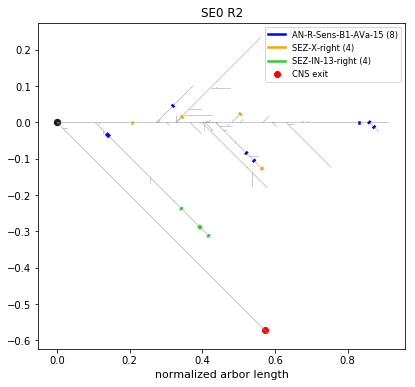

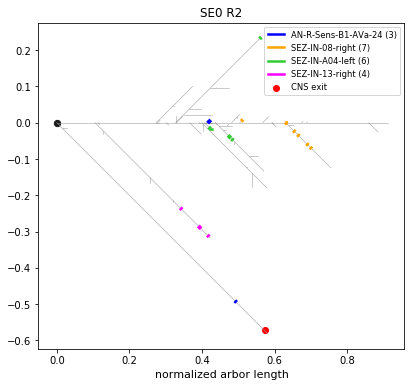

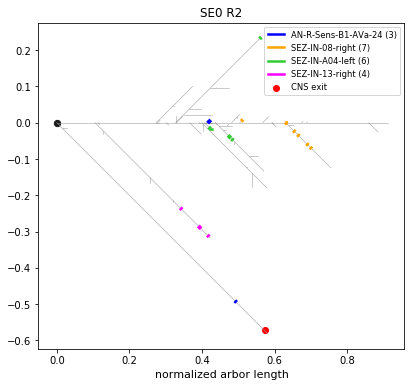

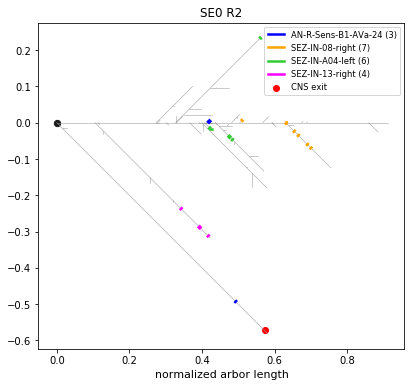

In [34]:
# all_dendrograms(se0ens_sen,new_boi)